REMARK: Difference of notations between this notebook and the article:

* Mixed layer depth is < 0 in the code (vs > 0 in the article)
* N2eq in the code is the N2h of the article
* LIONb is the "Western Mediterranean region", LABs is the "Labrador region"

All the analyses are presented here. For simplicity, these calculations have been already done and the results are provided in the npz archives available at https://doi.org/10.5281/zenodo.11236177. Thus, you have just to execute the "Imports" and "Functions" sections and then directly go to the header "Figures of the article" to realize all the figures presented in the article. For that, you have just to set-up the variable "path_to_npz_archives" just below with the path of the folder where you stored these archives.

PS: For a better readability of the Notebook, please install the "jupyter_contrib_nbextensions" and activate the "Collapsible Headings" + "Codefolding" extensions.

In [1]:
path_to_npz_archives = '/toto/'

# Imports

In [2]:
### NOT mandatory
### Opening a dask cluster for accelerating the calculations and for reducing memory leaks that 
### sometimes appear in Jupyter Notebook
### The dashboard for following the dask cluster is accessible at http://localhost:8777/status
#
#import dask
#import dask.threaded
#import dask.multiprocessing
#from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster(n_workers = 4, processes = True, dashboard_address=':8777')
#client = Client(cluster)
#client  # for showing the characteristic of the cluster

In [3]:
#!/usr/bin/env python
# coding: utf-8

# ===================
#      Imports
# ===================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import gsw
import warnings
import cartopy.crs as ccrs
import cartopy
from scipy import interpolate

#sys.path.append(r'/scm_oce/')     ### Fortran module for the 1D simulations
#from scm_oce import scm_oce       ### Fortran module for the 1D simulations

import xarray as xr
import dask
import cartopy.crs as ccrs
import cartopy
from os.path import exists
from matplotlib.ticker import FormatStrFormatter, LogLocator

plt.rcParams['figure.figsize'] = (15,8)  #(6.8,4.5)
plt.rcParams.update({'font.size': 15})

# Functions

In [4]:
### Functions for realizing the hexbin plots

def SymLogTicks(vmin, vmax, linthresh):  
    """Function for adding ticks when using a symlog colorbar scale."""
    log_max = int(np.ceil(np.log10(vmax)))
    log_min = int(np.ceil(np.log10(-vmin)))
    log_linthresh = int(np.floor(np.log10(linthresh)))
    tick_locations = np.array( [vmin]
                       + [-a*(10.0**x) for x in range(log_min-1,log_linthresh-1,-1) for a in range(9,0,-1)]
                       + [0.0]
                       + [a*(10.0**x) for x in range(log_linthresh,log_max) for a in range(1,10)]
                       + [vmax] )
    tick_locations = tick_locations[(tick_locations >= vmin) & (tick_locations <= vmax)]
    tick_locations = tick_locations[(tick_locations != linthresh) & (tick_locations != -linthresh)]
    # removing the "lintresh" tick because we will create a special one at this location
    return(tick_locations)

def hexbin_symlog(x,y,c,xmin,xmax=None,ymin=None,ymax=None,gridsize=30,norm=None,vmin=None,vmax=None,reduce_C_function=np.mean,cmap='bwr',xlabel='x',ylabel='y',clabel='c',ticksize=17,dynamicalNbTicks=False,mincnt=None,figsize=(15,8)):
    """ For generating 2 two hexbin logplots (one with the positive x-values: ax0, and one with the
    negative ones: ax1) that are stuck horizontally one to the other. ax2 is the colorbar.
    Be careful, the values of the left part of the plot are displayed negative but they are
    internally positive. Then, for example, if you want to draw a vertical line at -10, you need 
    to draw it at 10 on the ax0 !"""
    
    fig = plt.figure(figsize=figsize)
    if (xmax is None) | (ymin is None) | (ymax is None):
        extent = None
    else:
        extent = (np.log10(xmin),np.log10(xmax),np.log10(ymin),np.log10(ymax))
    
    width_left = 1
    width_right = 1
    width_cb = width_left * 0.05
    gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[width_left, width_right, width_cb]) 
    
    ax0 = plt.subplot(gs[0])
    mask_left = x<-xmin
    x_left = x[mask_left]
    y_left = y[mask_left]
    if (c is None):
        c_left = None
    else:
        c_left = c[mask_left]

    sc0 = ax0.hexbin(-x_left,y_left,C=c_left,reduce_C_function=reduce_C_function,norm=norm,extent=extent,vmin=vmin,vmax=vmax,xscale='log',yscale='log',cmap=cmap,gridsize=gridsize,mincnt=mincnt)
    ax0.invert_xaxis()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmax,xmin)
    plt.ylim(ymin,ymax)
    ax0.set_facecolor('silver')
    
    # **RQ1**: The location of the line "ax0.tick_params(labelsize=XX)" changes the final behavior. 
    # If placed before the "visible_xticks" definition, the nb of ticks will be ajusted 
    # according to the size of the labels. If placed afterwards, the size is changed directly 
    # on the existing labels
    if dynamicalNbTicks == True:
        ax0.tick_params(labelsize=ticksize)
    
    
    # >= ax0.get_xlim()[1] and <= ax0.get_xlim()[0] because axis in the reverse order ! 
    # This is linked with the caution in the docstring of the function "Be careful, the values
    # of the left part of the plot are displayed negative but they are internally positive"
    visible_xticks = [tick for tick in ax0.get_xticks() if tick >= ax0.get_xlim()[1] and tick <= ax0.get_xlim()[0]]
    xticklabels_left = ['']*np.size(visible_xticks)

    for i in range(np.size(xticklabels_left)):
        xticklabels_left[i]='-' + '$\\mathdefault{10^{' + str(int(np.log10(visible_xticks[i]))) + '}}$'
    
    ax0.xaxis.set_ticks(visible_xticks)
    ax0.set_xticklabels(xticklabels_left)
    ax0.xaxis.label.set_size(25)
    ax0.yaxis.label.set_size(25)
    if dynamicalNbTicks == False:  # please see **RQ1** few lines above
        ax0.tick_params(labelsize=ticksize)  
    
    
    hexbin0 = sc0.get_array()
    if (norm is None):
        if (vmin is None):
            if hexbin0.size != 0:
                vmin = hexbin0.min()
            else:
                vmin = None
        if (vmax is None):
            if hexbin0.size != 0:
                vmax = hexbin0.max() 
            else:
                vmax = None
            
    ax1 = plt.subplot(gs[1], sharey = ax0)
    mask_right = x>xmin
    x_right = x[mask_right]
    y_right = y[mask_right]
    if (c is None):
        c_right = None
    else:
        c_right = c[mask_right]

    sc1 = ax1.hexbin(x_right,y_right,C=c_right,reduce_C_function=reduce_C_function,norm=norm,extent=extent,vmin=vmin,vmax=vmax,xscale='log',yscale='log',cmap=cmap,gridsize=gridsize,mincnt=mincnt)
    plt.xlabel(xlabel)
    plt.xlim(xmin,xmax)
    ax1.set_facecolor('silver')
    ax1.xaxis.label.set_size(25)
    
    # The two following lines avoid that the choose of the size of the ticks
    # affects the nb of ticks that are displayed
    if dynamicalNbTicks == False:
        visible_xticks = [tick for tick in ax1.get_xticks() if tick >= ax1.get_xlim()[0] and tick <= ax1.get_xlim()[1]]
        ax1.xaxis.set_ticks(visible_xticks)
    
    ax1.tick_params(labelsize=ticksize)
    
    vmin_left = vmin_right = vmax_left = vmax_right = 0
    
    hexbin1 = sc1.get_array()
    if not(norm is None):   # if a "norm" objet was given, extract vmin and vmax value
        vmin = norm.vmin
        vmax = norm.vmax 
    if hexbin0.size != 0:
        vmin_left = hexbin0.min()
        vmax_left = hexbin0.max()
    if hexbin1.size != 0:
        vmin_right = hexbin1.min()
        vmax_right = hexbin1.max()

    vmin_total = np.min([vmin_left,vmin_right])
    vmax_total = np.max([vmax_left,vmax_right])

    ax2 = plt.subplot(gs[2])
    
    if type(norm) == type(matplotlib.colors.SymLogNorm(1e1,vmin=1e0,vmax=1e2,base=10)):     # creating the colorbar ticks if it is a log norm
        cb = matplotlib.colorbar.Colorbar(ax2,sc1,ticks = LogLocator(subs=range(10))) #,format='%g')

        vmin = my_norm.vmin
        vmax = my_norm.vmax
        linthresh = my_norm.linthresh
        cb.minorticks_on()
        cb.ax.minorticks_on()
        if (vmin < 0) & (vmax > 0):  # otherwise it is a simple logscale
            cb.ax.yaxis.set_ticks(SymLogTicks(vmin, vmax, linthresh), major=True);
            thresh_ticks = np.array([-linthresh, linthresh])
            thresh_ticks = thresh_ticks[(thresh_ticks > vmin) & (thresh_ticks < vmax)]
            cb.ax.yaxis.set_ticks(thresh_ticks, minor=True);   # showing where the linear scale starts
            cb.ax.tick_params(which='major', width=2, color='k')
            cb.ax.tick_params(which='minor', length=8, width=5, color='r')
    else:
        cb = matplotlib.colorbar.Colorbar(ax2,sc1) #,format='%g')
    
    cb.set_label(clabel)
    cb.ax.yaxis.label.set_size(18)
        
    plt.subplots_adjust(wspace=.0)   # remove vertical gap between subplots
    return ax0,ax1,ax2,sc0,sc1,cb

def hexbin_log(x,y,c,xmin,xmax=None,ymin=None,ymax=None,gridsize=30,norm=None,vmin=None,vmax=None,reduce_C_function=np.mean,cmap='bwr',xlabel='x',ylabel='y',clabel='c',ticksize=17,dynamicalNbTicks=False,mincnt=None,figsize=(7.4,7.2)):
    """Same as hexbin_symlog but for x taking only positive values"""
    
    fig = plt.figure(figsize=figsize)
    if (xmax is None) | (ymin is None) | (ymax is None):
        extent = None
    else:
        extent = (np.log10(xmin),np.log10(xmax),np.log10(ymin),np.log10(ymax))
    
    width = 1
    width_cb = width * 0.05
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[width, width_cb]) 
    
    ax0 = plt.subplot(gs[0])
    sc0 = ax0.hexbin(x,y,C=c,reduce_C_function=reduce_C_function,norm=norm,extent=extent,vmin=vmin,vmax=vmax,xscale='log',yscale='log',cmap=cmap,gridsize=gridsize,mincnt=mincnt)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    ax0.set_facecolor('silver')
    
    # The two following lines avoid that the choose of the size of the ticks
    # affects the nb of ticks that are displayed
    if dynamicalNbTicks == False:
        visible_xticks = [tick for tick in ax0.get_xticks() if tick >= ax0.get_xlim()[0] and tick <= ax0.get_xlim()[1]]
        ax0.xaxis.set_ticks(visible_xticks)
    
    ax0.tick_params(labelsize=ticksize)
    ax0.xaxis.set_ticks(visible_xticks)
    ax0.xaxis.label.set_size(25)
    ax0.yaxis.label.set_size(25)

    
    hexbin0 = sc0.get_array()
    if (norm is None):
        if (vmin is None):
            if hexbin0.size != 0:
                vmin = hexbin0.min()
            else:
                vmin = None
        if (vmax is None):
            if hexbin0.size != 0:
                vmax = hexbin0.max() 
            else:
                vmax = None

    
    vmin_left = vmin_right = vmax_left = vmax_right = 0
    
    if not(norm is None):   # if a "norm" objet was given, extract vmin and vmax value
        vmin = norm.vmin
        vmax = norm.vmax 

    vmin_total = hexbin0.min()
    vmax_total = hexbin0.max()
    
    ax1 = plt.subplot(gs[1])
    
    if type(norm) == type(matplotlib.colors.SymLogNorm(1e1,vmin=1e0,vmax=1e2,base=10)):     # creating the colorbar ticks if it is a log norm
        cb = matplotlib.colorbar.Colorbar(ax1,sc1,ticks = LogLocator(subs=range(10))) #,format='%g')

        vmin = my_norm.vmin
        vmax = my_norm.vmax
        linthresh = my_norm.linthresh
        cb.minorticks_on()
        cb.ax.minorticks_on()
        if (vmin < 0) & (vmax > 0):  # otherwise it is a simple logscale
            cb.ax.yaxis.set_ticks(SymLogTicks(vmin, vmax, linthresh), major=True);
            thresh_ticks = np.array([-linthresh, linthresh])
            thresh_ticks = thresh_ticks[(thresh_ticks > vmin) & (thresh_ticks < vmax)]
            cb.ax.yaxis.set_ticks(thresh_ticks, minor=True);   # showing where the linear scale starts
            cb.ax.tick_params(which='major', width=2, color='k')
            cb.ax.tick_params(which='minor', length=8, width=5, color='r')
    else:
        cb = matplotlib.colorbar.Colorbar(ax1,sc0) #,format='%g')
    
    cb.set_label(clabel)
    cb.ax.yaxis.label.set_size(18)
        
    plt.subplots_adjust(wspace=.0)   # remove vertical gap between subplots
    return ax0,ax1,sc0,cb

def assign_MLDregime(C):
    """To class the given array C in one of the 4 defined mixed layer depth dynamics regimes 
    (StrongDeepening : 0.99, Deepening : 0.66, Stable : 0.33 and Restrat : 0.01). 
    Moreover, the information of the significativity of this result is also stored by adding 
    +0.0075 to this value is the hexagon is non significant, +0.0050 if it is significant and 
    +0 if it is highly significant"""
    A = np.array(C)
    n = np.size(A)
    
    threshold75 = 0.75
    threshold50 = 0.5
    nb_StrongDeepening = (A >= 10).sum() / n          # percentage of "StrongDeepening" points inside the hexagon 
    nb_Deepening = ((A >= 1) & (A <= 10)).sum() / n   # percentage of "Deepening" points inside the hexagon 
    nb_Stable = ((A >= -1) & (A <= 1)).sum() / n      # percentage of "Stable" points inside the hexagon
    nb_Restrat = (A <= -1).sum() / n                  # percentage of "Restratification" points inside the hexagon 
    
    ### For (rare) equality, StrongDeepening wins against Deepening, Deepening against Stable and Stable against Restrat 
    if (nb_StrongDeepening >= nb_Deepening) & (nb_StrongDeepening >= nb_Stable) & (nb_StrongDeepening >= nb_Restrat):
        if nb_StrongDeepening < threshold50:
            return(0.9950)
        elif nb_StrongDeepening < threshold75:
            return(0.9975)
        else:
            return(0.99)
    elif (nb_Deepening >= nb_StrongDeepening) & (nb_Deepening >= nb_Stable) & (nb_Deepening >= nb_Restrat):
        if nb_Deepening < threshold50:
            return(0.6650)
        elif nb_Deepening < threshold75:
            return(0.6675)
        else:
            return(0.66)
    elif (nb_Stable >= nb_StrongDeepening) & (nb_Stable >= nb_Deepening) & (nb_Stable >= nb_Restrat):
        if nb_Stable < threshold50:
            return(0.3350)
        elif nb_Stable < threshold75:
            return(0.3375)
        else:
            return(0.33)
    elif (nb_Restrat >= nb_StrongDeepening) & (nb_Restrat >= nb_Deepening) & (nb_Restrat >= nb_Stable):
        if nb_Restrat < threshold50:
            return(0.0150)
        elif nb_Restrat < threshold75:
            return(0.0175)
        else:
            return(0.01)
        

In [5]:
### Some calculations about MLD, rho, alpha, beta...

def rhoNL (T,S):
    """Calculation of the density through a non-linear equation of state
    T in °C and S in g/kg (PSU)"""
    QR=+999.842594  ; Q01=+6.793952e-2;  Q02=-9.095290e-3;  
    Q03=+1.001685e-4; Q04=-1.120083e-6;  Q05=+6.536332e-9;  
    Q10=+0.824493   ; Q11=-4.08990e-3 ;  Q12=+7.64380e-5;   
    Q13=-8.24670e-7 ; Q14=+5.38750e-9 ;  QS0=-5.72466e-3;   
    QS1=+1.02270e-4 ; QS2=-1.65460e-6 ;  Q20=+4.8314e-4;
    
    sqrtS   = np.sqrt(S)
    rho =   QR+T*(Q01+T*(Q02+T*(Q03+T*(Q04+T*Q05)))) \
             +S*(Q10+T*(Q11+T*(Q12+T*(Q13+T*Q14)))    \
             +sqrtS*(QS0+T*(QS1+T*QS2))+S*Q20)
    return(rho)

def alphaTS(T,S):
    """Calculation of the thermal expansion coefficient of the linear equation of state"""
    dT = 0.01
    alpha = 1/rhoNL(T,S) * (rhoNL(T,S) - rhoNL(T+dT,S))/dT
    return alpha

def betaTS(T,S):
    """Calculation of the haline contraction coefficient of the linear equation of state"""
    dS = 0.001
    beta = 1/rhoNL(T,S) * (rhoNL(T,S+dS) - rhoNL(T,S))/dS
    return beta

def glsMin(tke_min, eps_min, turbulence_scheme, stability_function):
    """Calculations of the minimal "psi" corresponding to the given minimal turbulent kinetic 
    energy and given minimal dissipation"""
    rp = rm = rn = 0.0        
    if   turbulence_scheme == 1:
        rp = -1.0 ; rm = 0.5  ; rn = -1.0
    elif turbulence_scheme == 2:
        rp = 3.0  ; rm = 1.5  ; rn = -1.0
    elif turbulence_scheme == 3:
        rp = 0.0  ; rm = 1.0  ; rn = -0.67 
    
    c1=5.; c2=0.8; c3=1.968; c4=1.136
    if   stability_function == 1:
        c1=3.6; c2=0.8;    c3=1.2;    c4=1.2
    elif stability_function == 2:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 3:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 4:
        c1=3.;  c2=0.8;    c3=2.;     c4=1.118
    elif stability_function == 5:
        c1=5.;  c2=0.6983; c3=1.9664; c4=1.094
    elif stability_function == 6:          
        c1=5.;  c2=0.7983; c3=1.968;  c4=1.136    

    nn  = 0.5*c1
    a1  = 0.66666666667-0.5*c2
    a2  = 1.-0.5*c3
    a3  = 1.-0.5*c4            
    cm0 =  pow( (a2*a2 - 3.0*a3*a3 + 3.0*a1*nn)/(3.0*nn*nn), 0.25 )     
    cff     = pow(cm0,3) * pow(tke_min,1.5) / eps_min                     
    gls_min = pow(cm0,rp) * pow(tke_min,rm) * pow(cff,rn) 
    return(gls_min)

In [6]:
#### These 4 functions come from Li et al. 2019 codes and are used for calculating the joint PDF
#### They can be found in gotmwork/visualization/examples/Regime_diagram.ipynb and in tools/gotmanalysis.py 
#### These files are available here : https://github.com/qingli411/gotmwork or here : https://doi.org/10.26300/mknw-3842


def plot_dist_3p(hst, xi, yi, axis=None, filled=False, fcolors=None, **kwargs):
    """Plot bi-dimensional histogram. Show the contours of the
       histogram which enclose the highest 30%, 60%, and 90%
       centered distribution.

    :his: (2D numpy array) bi-dimensional histogram
    :xi: (1D numpy array) centers of x dimension
    :yi: (1D numpy array) centers of y dimension
    :axis: (matplotlib.axes, optional) axis to plot figure on
    :filled: (bool) filled contour if True
    :fcolors: (list, optional) color string or sequence of colors, optional)
    :return: (matplotlib figure object) figure

    """
    vl = [0.3, 0.6, 0.9]
    fig = plot_dist_xp(hst, xi, yi, axis=axis, levels=vl, filled=filled, fcolors=fcolors, **kwargs)
    return fig

def plot_dist_4p(hst, xi, yi, axis=None, filled=False, fcolors=None, **kwargs):
    """Plot bi-dimensional histogram. Show the contours of the
       histogram which enclose the highest 30%, 60%, 90% and 99%
       centered distribution.

    :his: (2D numpy array) bi-dimensional histogram
    :xi: (1D numpy array) centers of x dimension
    :yi: (1D numpy array) centers of y dimension
    :axis: (matplotlib.axes, optional) axis to plot figure on
    :filled: (bool) filled contour if True
    :fcolors: (list, optional) color string or sequence of colors, optional)
    :return: (matplotlib figure object) figure

    """
    vl = [0.3, 0.6, 0.9, 0.99]
    fig = plot_dist_xp(hst, xi, yi, axis=axis, levels=vl, filled=filled, fcolors=fcolors, **kwargs)
    return fig

def plot_dist_xp(hst, xi, yi, axis=None, levels=None, filled=False, fcolors=None, **kwargs):
    """Plot bi-dimensional histogram. Show the contours of the
       histogram which enclose the highest p1%, p2%, ... and pN%
       centered distribution.

    :his: (2D numpy array) bi-dimensional histogram
    :xi: (1D numpy array) centers of x dimension
    :yi: (1D numpy array) centers of y dimension
    :axis: (matplotlib.axes, optional) axis to plot figure on
    :levels: (list of float, optional) contour levels, 0.0-1.0
    :filled: (bool) filled contour if True
    :fcolors: (list, optional) color string or sequence of colors
    :return: (matplotlib figure object) figure

    """
    # use curret axis if not specified
    if axis is None:
        axis = plt.gca()
    hsum = np.sum(hst)
    hlist = -np.sort(-hst.flatten())/hsum
    hcum = np.cumsum(hlist)
    vl = levels
    nv = len(vl)
    vlev = np.zeros(nv)
    for i in np.arange(nv):
        ind = np.argmin(abs(hcum-vl[i]))
        vlev[i] = hlist[ind]
    ### Remarque : Cette façon de calculer ce qui entourent 30%/60%/90% des points ne fonctionnent que 
    ### si on a une distribution unimodale du heatmap dans l'espace des paramètres. En effet on fait ici
    ### l'hypothèse que ces limites 30%/60%/90% peuvent se trouver en prenant les localisations de valeurs 
    ### de la PDF. Par exemple on dit limite 30% <=> contour PDF = 0.1 et limite 60% <=> contour PDF = 0.03. 
    ### Cette méthode ne fonctionne que si le contour PDF = 0.1 forme un contour fermé qui est entièrement 
    ### contenu dans le contour fermé PDF = 0.03, ce qui n'est pas du tout forcément le cas ! (et ce qui 
    ### n'est notamment pas parfaitement vrai dans notre cas, c'est la raison pour laquelle on a des petits 
    ### contours fermés qui apparaissent en plus des grands contours). En fait, de façon plus précise, 
    ### cette méthode ne fonctionne que si chaque contour de valeur PDF = A forme un contour fermé (pas 
    ### forcément le cas) qui contient entièrement le contour (fermé) de valeur PDF = A - ɛ (pas forcément 
    ### le cas). C'est par ailleurs une bonne approximation qui permet de se faire une idée de ces 30%/60%...
    
    pdfData = hst/hsum
    pdfData[pdfData==0] = 1e-12
    if not filled:
        fig = axis.contour(xi, yi, np.log10(np.transpose(pdfData)), levels=np.log10(vlev[::-1]), **kwargs)
    else:
        if fcolors is None:
            cmap = cm.get_cmap('bone')
            fcolors = cmap(np.linspace(1.0, 0.0, 11)[0:nv+1])
        else:
            nfc = len(fcolors)
            if nfc != nv+1:
                raise ValueError('Length of fcolors should equal to number of levels + 1.')
        fig = axis.contourf(xi, yi, np.log10(np.transpose(pdfData)), levels=np.log10(vlev[::-1]),
                            colors=fcolors, extend='both', **kwargs)
    return fig

def loglog_hist2d(xdata, ydata, xpr, ypr):
    hist, xi, yi, c = plt.hist2d(xdata, ydata, range=(xpr, ypr), bins=100)
    # clean the figure
    plt.clf()
    # get the centers from the edges
    xi = 0.5*(xi[0:-1]+xi[1:])
    yi = 0.5*(yi[0:-1]+yi[1:])
    # convert back to actual values
    xi = 10**xi
    yi = 10**yi
    return hist, xi, yi


# Parameters for the 1D simulations

In [7]:
#%%  INITIALISATION

#====================
# Input parameters
#====================

# Physical parameters ===========================================================
cp            = 4000.      # specific heat [J/kg/K] 
dpdx          = 0.         # barotropic pressure gradient [m/s2]
r_D           = 0.         # bottom friction  CD * ||ubot||
Zob           = 0.         # bottom rugosity length
Neu_bot       = True       # bottom boundary condition (Neumann)
lin_eos       = False      # type of the equation of state, we use a non-linear EOS 
nuwm          = 1.0e-4     # minimal value of the turbulent viscosity 
nuws          = 0.1e-4     # minimal value of the turbulent diffusivity 
rho0          = 1030       # reference density [kg/m3]

# Spatial and temporal grids ====================================================
dt            = 360.       # time step [s]
dt_out        = 24*3600                     # output time step [s]
output_period = int(dt_out/dt)              # storage every x time steps
nb_steps_per_day = int(24*3600/dt)          # automatic, do not change
ntra          = 2                           # nb of tracers : 2 (temperature + salinity)
nt            = 2                           # nb of time steps stored : 2 (n et n+1)
ngls          = 2                           # nb of variable for GLS closure : 2 (TKE + GLS)  

In [8]:
forc_type = 'ORCA1_global15deg'    # ORCA1_LIONb or ORCA1_LABs or ORCA1_global15deg

In [9]:
## =============================================================================
##                          Definition of the forcings
## =============================================================================
if (forc_type == 'ORCA1_LIONb') | (forc_type == 'ORCA1_LABs'):
    
    if (forc_type == 'ORCA1_LIONb'):
        Boxn          = 'LIONb'       # Name of the region
        nyear_ORCA1   = 20            # nb of years of simulations for each of these localizations
        nsample_ORCA1 = 18            # nb of localizations where simulations will be performed
        total_time    = 24*3600*365*nyear_ORCA1*nsample_ORCA1   # total simulation time [s], 20 years at 18 localizations
        nb_steps      = int(total_time/dt)                      # nb of time steps
    elif (forc_type == 'ORCA1_LABs'):
        Boxn          = 'LABs'        # Name of the region
        nyear_ORCA1   = 20            # nb of years of simulations for each of these localizations
        nsample_ORCA1 = 36            # nb of localizations where simulations will be performed
        total_time    = 24*3600*365*nyear_ORCA1*nsample_ORCA1    # total simulation time [s], 20 years at 18 localizations
        nb_steps      = int(total_time/dt)                       # nb of time steps
        
    dTdz0         = 0
    
    flxT_ORCA1         = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2000-2019.1d_flxT_{Boxn}.nc')
    WndStressT_ORCA1   = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2000-2019.1d_tauxtauy_gridT_{Boxn}.nc')
    gridT_1stJan_ORCA1 = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2000-2019m01d01.1d_gridT_{Boxn}.nc')
    bathy_ORCA1 = - xr.open_dataset(path_to_npz_archives + f'eORCA1_R1_bathy_meter_v2.2_{Boxn}.nc').Bathymetry

    bathy_ORCA1_data = np.array(bathy_ORCA1)
    xy_possible = np.argwhere(bathy_ORCA1_data < -2000.)
    x_selected = xy_possible[:,1]
    y_selected = xy_possible[:,0]
    
    
    # Choose only the selected years
    year_extract = np.isin(flxT_ORCA1.time_counter.values.astype('datetime64[Y]').astype(int)+1970,np.arange(2000,2000+nyear_ORCA1))
    flxT_ORCA1 = flxT_ORCA1.isel(time_counter=year_extract)
    WndStressT_ORCA1 = WndStressT_ORCA1.isel(time_counter=year_extract)
    
    year_extract_gridT = np.isin(gridT_1stJan_ORCA1.time_counter.values.astype('datetime64[Y]').astype(int)+1970,np.arange(2000,2000+nyear_ORCA1))
    gridT_1stJan_ORCA1['deptht']      = -gridT_1stJan_ORCA1.deptht       # put the minus sign on the depths
    gridT_1stJan_ORCA1['deptht_bnds'] = -gridT_1stJan_ORCA1.deptht_bnds       # put the minus sign on the depths
    gridT_1stJan_ORCA1  = gridT_1stJan_ORCA1.reindex(deptht=gridT_1stJan_ORCA1.deptht[::-1])  # convention k=0 bottom, k=N surface 
    gridT_1stJan_ORCA1  = gridT_1stJan_ORCA1.isel(time_counter=year_extract_gridT)
    
    
    
if (forc_type == 'ORCA1_global15deg'):
    
    Boxn          = 'global15deg' # Name of the region
    nsample_ORCA1 = 234           # nb of localizations where simulations will be performed
    nyear_ORCA1   = 10            # nb of years of simulations for each of these localizations
    total_time    = 24*3600*365*nyear_ORCA1*nsample_ORCA1    # total simulation time [s], 20 years at 18 localizations
    nb_steps      = int(total_time/dt)                       # nb of time steps
    
    dTdz0         = 0
    flxT_ORCA1         = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2006-2015.1d_flxT_global15deg.nc')
    WndStressT_ORCA1   = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2006-2015.1d_tauxtauy_gridT_global15deg.nc')
    gridT_1stJan_ORCA1 = xr.open_dataset(path_to_npz_archives + f'eORCA1-GJM2020c_y2006-2015m01d01.1d_gridT_global15deg.nc')
    bathy_ORCA1 = - xr.open_dataset(path_to_npz_archives + f'eORCA1_R1_bathy_meter_v2.2_global15deg.nc').Bathymetry
    
    bathy_ORCA1_data = np.array(bathy_ORCA1)
    xy_possible = np.argwhere(bathy_ORCA1_data < -2000.)
    x_selected = xy_possible[:,1]
    y_selected = xy_possible[:,0]
    
    
    # Choose only the selected years
    year_extract = np.isin(flxT_ORCA1.time_counter.values.astype('datetime64[Y]').astype(int)+1970,np.arange(2006,2006+nyear_ORCA1))
    flxT_ORCA1 = flxT_ORCA1.isel(time_counter=year_extract)
    WndStressT_ORCA1 = WndStressT_ORCA1.isel(time_counter=year_extract)
    
    year_extract_gridT = np.isin(gridT_1stJan_ORCA1.time_counter.values.astype('datetime64[Y]').astype(int)+1970,np.arange(2006,2006+nyear_ORCA1))
    gridT_1stJan_ORCA1['deptht']      = -gridT_1stJan_ORCA1.deptht       # put the minus sign on the depths
    gridT_1stJan_ORCA1['deptht_bnds'] = -gridT_1stJan_ORCA1.deptht_bnds       # put the minus sign on the depths
    gridT_1stJan_ORCA1  = gridT_1stJan_ORCA1.reindex(deptht=gridT_1stJan_ORCA1.deptht[::-1])  # convention k=0 bottom, k=N surface 
    gridT_1stJan_ORCA1  = gridT_1stJan_ORCA1.isel(time_counter=year_extract_gridT)

    
z_ORCA1      = gridT_1stJan_ORCA1.deptht               # cell depth [m]
zbnds_ORCA1  = gridT_1stJan_ORCA1.deptht_bnds          # cell boundaries [m]
e3t_ORCA1    = gridT_1stJan_ORCA1.e3t                  # cell thickness [m]
    
# z_r = [-1945m => -0.5m]
# z_w = [-2022m => -1m , Last level = 0m] 
z_r = z_ORCA1[21:].values               # 1D simu vertical grid (T,S,rho)
nz  = z_r.size                          # 1D simu nb of vertical levels
z_w = np.zeros(nz+1)                    # 1D simu vertical grid (fluxes)
z_w[0:-1] = zbnds_ORCA1[21:,1].values   # Last level is kept at 0m
Hz     = np.zeros(nz)                   # 1D simu thicknesses of the grid cells
for k in range(nz):
    Hz[k] = z_w[k+1]-z_w[k]
    
T_1stJan_ORCA1      = gridT_1stJan_ORCA1.votemper
S_1stJan_ORCA1      = gridT_1stJan_ORCA1.vosaline
T_1stJan = T_1stJan_ORCA1.data[:,:,y_selected,x_selected].transpose((1, 2, 0)).reshape(75,-1)  # (z, nb_pts, nb_years)
S_1stJan = S_1stJan_ORCA1.data[:,:,y_selected,x_selected].transpose((1, 2, 0)).reshape(75,-1)  # (z, nb_pts, nb_years)
# Order : All the days at point 1 then all the days at point 2 then ... etc
# Ex : [:,5] gives the 5th profile (day 5 at point 1)
    
    
    
# Removing the leap days that produce temporal shift... 
# Thks to that, the day "n * 365" is always a 1st January (this has been checked, cf t_ORCA1_chosenPoints !)
flxT_ORCA1 = flxT_ORCA1.sel(time_counter=~((flxT_ORCA1.time_counter.dt.month == 2) & (flxT_ORCA1.time_counter.dt.day == 29)))
WndStressT_ORCA1 = WndStressT_ORCA1.sel(time_counter=~((WndStressT_ORCA1.time_counter.dt.month == 2) & (WndStressT_ORCA1.time_counter.dt.day == 29)))
    
t_ORCA1_chosenPoints = WndStressT_ORCA1.time_counter.expand_dims(dim={'y':bathy_ORCA1.shape[0],'x':bathy_ORCA1.shape[1]}).transpose('time_counter','y','x')
t_ORCA1_chosenPoints = t_ORCA1_chosenPoints.data[:,y_selected,x_selected].flatten(order='F')
    
lon_chosenPoints  = bathy_ORCA1.nav_lon.data[y_selected,x_selected]
lat_chosenPoints  = bathy_ORCA1.nav_lat.data[y_selected,x_selected]
fcor_chosenPoints     = 2*7.29*1e-5*np.sin(lat_chosenPoints*np.pi/180) 

    
# CAUTION : Do not use WndStressT_ORCA1.taux and WndStressT_ORCA1.tauy directly 
# because they contain NaN values. Therefore, we recalculate them. 
taumod_ORCA1   = WndStressT_ORCA1.taumod.squeeze()         # [N/m2]
sovitdir_ORCA1 = WndStressT_ORCA1.taudir.squeeze()         # [°]
taux_ORCA1     = taumod_ORCA1 * np.sin(sovitdir_ORCA1*2*np.pi/360)  # [N/m2]
tauy_ORCA1     = taumod_ORCA1 * np.cos(sovitdir_ORCA1*2*np.pi/360)  # [N/m2]
EmP_ORCA1      = flxT_ORCA1.sowaflup.squeeze()             # [kg/m2/s] ~ [mm/s]
fsol_ORCA1     = flxT_ORCA1.soshfldo.squeeze()             # [W/m2]
fnet_ORCA1     = flxT_ORCA1.sohefldo.squeeze()

taumod_day   = np.array(taumod_ORCA1)[:,y_selected,x_selected].flatten(order='F')
ustar_day    = (taumod_day / rho0) ** (1/2)
taux_day     = np.array(taux_ORCA1)[:,y_selected,x_selected].flatten(order='F')
tauy_day     = np.array(tauy_ORCA1)[:,y_selected,x_selected].flatten(order='F')
fsol_day     = np.array(fsol_ORCA1)[:,y_selected,x_selected].flatten(order='F')
fnet_day     = np.array(fnet_ORCA1)[:,y_selected,x_selected].flatten(order='F')
EmP_day      = np.array(EmP_ORCA1)[:,y_selected,x_selected].flatten(order='F')
# Order : All the days at point 1 then all the days at point 2 then ... etc
    
fnonsol_day  = fnet_day - fsol_day    


In [10]:
### definition of u*
taux_t        = lambda t: taux_day[int(t // 86400)]  # [N.m-2]   
taux_m2s2_t   = lambda t: taux_t(t)/rho0             # zonal wind stress [m2/s2] 
tauy_t        = lambda t: tauy_day[int(t // 86400)]  # [N.m-2]   
tauy_m2s2_t   = lambda t: tauy_t(t)/rho0             # meridional wind stress [m2/s2]   
ustar_t       = lambda t: np.sqrt(np.sqrt(taux_m2s2_t(t)**2 + tauy_m2s2_t(t)**2))   # friction velocity [m/s]

### definition of fnet and freshflx
EmP_t         = lambda t: EmP_day[int(t // 86400)]       # evaporation - precipitation [kg.m-2.s-1]
fsol_t        = lambda t: np.maximum(np.cos(2.*np.pi*(t/86400.)),0.) * np.pi*fsol_day[int(t // 86400)]    # solar flux [W/m^2]
fsol_Cms_t    = lambda t: fsol_t(t) / (rho0*cp)          # solar flux [°C.m/s]
fnonsol_t     = lambda t: fnonsol_day[int(t // 86400)]   # non solar flux at the surface [W/m2]
fnet_t        = lambda t: fnonsol_t(t) + fsol_t(t)
B0_t_Tsurf_Ssurf = lambda t,Tsurf,Ssurf: 9.81/rho0 * (alphaTS(Tsurf,Ssurf)/cp * fnet_t(t) - EmP_t(t) * Ssurf * betaTS(Tsurf,Ssurf))   # buoyancy flux [m2/s3]

fnet_Cms_t         = lambda t: fnet_t(t) / (rho0*cp)           # net heat fux  [°C.m/s]
freshflx_t_Ssurf   = lambda t,Ssurf: EmP_t(t) * Ssurf / rho0   # fresh water flux (opposite of this flux to be precise) [psu.m/s]


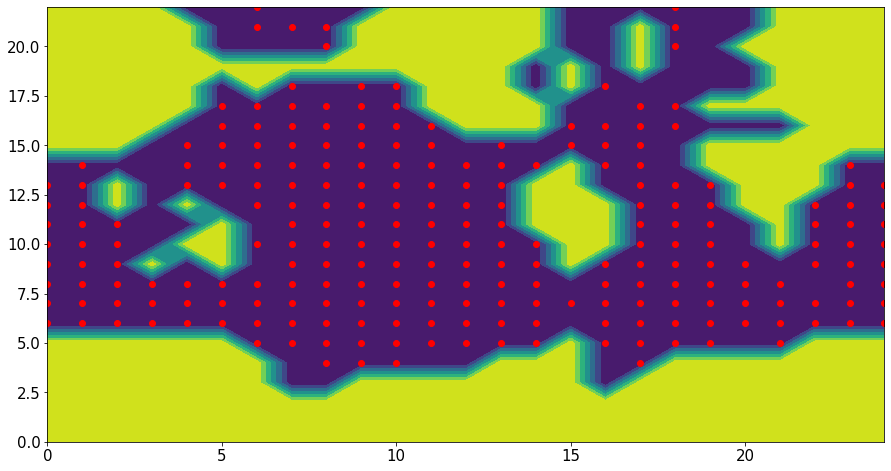

In [11]:
#### For plotting the localizations of the points
plt.contourf(bathy_ORCA1 == -0)
plt.plot(x_selected,y_selected,'ro')

# Performing the 1D simulations

In [ ]:
#===============================================
# Initialisation of output variables
#===============================================

N_sch        = 1 
list_sch     = ['TKE EVD']
# In our research code, this parameter allows to run different vertical schemes (KPP, GLS, TKE...).
# Here, for simplification and because it is the only one used in the article, only the
# TKE + EVD scheme is available. However, this parameter was kept for consistency with the 
# provided arrays given in these archives.
    
n_sch        = -1                               # index of the current model
nout         = int((nb_steps-1)/output_period+1)# nb of points stored
t_days     = np.zeros(nout)                     # output moments
T            = np.zeros((nz,nout,N_sch))        # T array
S            = np.zeros((nz,nout,N_sch))        # S array
MLD          = np.zeros((nout,N_sch))           # MLD
rho          = np.zeros((nz,nout,N_sch))        # density
Kt           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for scalar
Kv           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for momentum
T0           = 20                               # [NOT USED] reference temperature in linear EOS
S0           = 38                               # [NOT USED] reference salinity in linear EOS
alpha        = alphaTS(T0,S0)                   # [NOT USED] Coef of the eos for the temperature [1/°C]  
beta         = betaTS(T0,S0)                    # [NOT USED] Coef of the eos for the salinity [1/psu] 

T_av24h      = np.zeros((nz,nout,N_sch))        # T array, daily output of daily means
S_av24h      = np.zeros((nz,nout,N_sch))        # S array, daily output of daily means
ustar_av24h  = np.zeros((nout,N_sch))           # ustar array, daily output of daily means
B0_av24h     = np.zeros((nout,N_sch))           # B0 array, daily output of daily means

T_storage24h = np.zeros((nz,nb_steps_per_day))  # T array, storage of the results of the last 24h
S_storage24h = np.zeros((nz,nb_steps_per_day))  # S array, storage of the results of the last 24h
taux_m2s2_storage24h = np.zeros((nb_steps_per_day)) # taux_m2s2 array, storage of the results of the last 24h
tauy_m2s2_storage24h = np.zeros((nb_steps_per_day)) # tauy_m2s2 array, storage of the results of the last 24h
B0_storage24h = np.zeros((nb_steps_per_day))    # B0 array, storage of the results of the last 24h


### TKE + EVD

In [ ]:
# =============================================================================
# 
#                                   TKE + EVD
# 
# =============================================================================
ncount             = 0     # storage counter during the simulation
i24h               = -1    # counter for the daily mean calculations
c_new_start        = 0     # counting the new starts
turbulence_scheme  = 5     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
EVD                = True   
NonLocalKPP        = True  # Not relevant here but needed to be given
# ===================================
# Initial condition definition
# ===================================
uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F')  

for t in range(nt):  
    toce[:,t,0] = T_1stJan[21:,0]
    toce[:,t,1] = S_1stJan[21:,0]
Ssurf = S_1stJan[-1,0]
fcor = fcor_chosenPoints[0]
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     
# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]
# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================
Akv  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akv [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akv [0] = Akv [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
c_mu = np.zeros(nz+1)
c_mu_prime = np.zeros(nz+1)
            
#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s
    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False
    Tsurf  = toce[-1,nstp-1,0]
    Ssurf  = toce[-1,nstp-1,1]
     
    taux_m2s2     = taux_m2s2_t(time)      # zonal wind stress [m2/s2] 
    tauy_m2s2     = tauy_m2s2_t(time)      # meridional wind stress [m2/s2] 
    fsol_Cms      = fsol_Cms_t(time)       # solar flux (diurnal variation) [C.m/s]
    fnet_Cms      = fnet_Cms_t(time)       # net heat flux  [C.m/s]
    fnet          = fnet_t(time)           # net heat flux  [W/m2]
    EmP           = EmP_t(time)            # evaporation - precipitation [kg m-2 s-1]
    freshflx      = EmP * Ssurf/rho0       # fresh water flux (opposite of this flux to be precise) [psu m / s]   
                  
    # temporal integration                                          
    scm_oce.obl_stp(z_r,z_w,Hz,                                             \
                    unudge,vnudge,tnudge,                                   \
                    uoce,voce,toce,turb,lmix,eps,                           \
                    rho0,rho1,Akv,Akt,wx_NL_KPP,c_mu,c_mu_prime,r_D,        \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,         \
                    dTdz_bot,delta,fcor,Ric,hbls,                           \
                    dt,dpdx,turbulence_scheme,stability_function,           \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,NonLocalKPP,   \
                    check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    
    
    # We impose the (T,S) profiles once a year
    # Condition : ((time // 86400) % 365 == 0) => works at every time step during the day of this new year
    # Condition : (time % (86400*365) == 0) => works only at the first time step during the day of this new year
    
    if ((time // 86400) % 365 == 0):
                    
        if (time % (86400*365) == 0):  # only the first time, we re-initialise everything
            uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
            voce  = np.zeros((nz,nt), order='F')       # initial v = 0
            Akv  = np.zeros(nz+1)  
            Akt  = np.zeros((nz+1,ntra), order='F')   
            Akv [:]     = nuwm
            Akt [:,0]   = nuws
            Akt [:,1]   = nuws    
            Akv [0] = Akv [nz] = 0.
            Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
            wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
            turb = np.zeros((nz+1,2,ntra), order='F')
            turb[:,:,0] = tke_min
            turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
            lmix = np.zeros(nz+1)
            eps  = np.zeros(nz+1)
            c_mu = np.zeros(nz+1)
            c_mu_prime = np.zeros(nz+1)
            hbls = np.array([0.])
            fcor = fcor_chosenPoints[int(time // (86400*365*nyear_ORCA1))]
            c_new_start += 1
            print(c_new_start)
        
        toce[:,nnew-1,0] = T_1stJan[21:,int(time // (86400*365))]
        toce[:,nnew-1,1] = S_1stJan[21:,int(time // (86400*365))]
    
    time_nnew   = time + dt
    i24h += 1
    i24h = i24h % nb_steps_per_day
    T_storage24h[:,i24h]       = toce[:,nnew-1,0]  # T array of the results of the last 24h
    S_storage24h[:,i24h]       = toce[:,nnew-1,1]  # S array of the results of the last 24h
    taux_m2s2_storage24h[i24h] = taux_m2s2  # taux array of the results of the last 24h
    tauy_m2s2_storage24h[i24h] = tauy_m2s2  # tauy array of the results of the last 24h
    B0_storage24h[i24h]        = B0_t_Tsurf_Ssurf(time,Tsurf,Ssurf)
    # if it is a storage moment
    if  kt % output_period == 0:
        t_days [ncount]    = time_nnew / (24. * 3600.)              # current time in day        
        MLD[ncount,n_sch]    = -1 * hbls                              # MLD storage
        Kt[:,ncount,n_sch]   = Akt[:,0]          # diffusivity storage
        Kv[:,ncount,n_sch]   = Akv               # viscosity storage
        T[:,ncount,n_sch]    = toce[:,nnew-1,0]  # temperature storage
        S[:,ncount,n_sch]    = toce[:,nnew-1,1]  # salinity storage
        T_av24h[:,ncount,n_sch]    = T_storage24h.mean(axis=1) # T array, daily means
        S_av24h[:,ncount,n_sch]    = S_storage24h.mean(axis=1) # S array, daily means
        taux_m2s2_av24h_cur        = taux_m2s2_storage24h.mean()   # taux array, daily means
        tauy_m2s2_av24h_cur        = tauy_m2s2_storage24h.mean()   # tauy array, daily means
        ustar_av24h[ncount,n_sch]  = np.sqrt(np.sqrt(taux_m2s2_av24h_cur**2 + tauy_m2s2_av24h_cur**2))
        B0_av24h[ncount,n_sch]     = B0_storage24h.mean()      # B0 array, daily means
        rho[:,ncount,n_sch]  = rho1              # density storage
        ncount = ncount + 1      
    
T_av24h[:,0,n_sch] = T[:,0,n_sch]
S_av24h[:,0,n_sch] = S[:,0,n_sch]

if (forc_type == 'ORCA1_global3deg') | (forc_type == 'ORCA1_global15deg') | (forc_type == 'ORCA1_LABsLIONb'):
    ustar_av24h[0,n_sch] = ustar_t(0)
    B0_av24h[0,n_sch]    = B0_t_Tsurf_Ssurf(0,T_1stJan[-1,0],S_1stJan[-1,0])
    
    

# Results of the 1D simulations

In [ ]:
z_r_1Dmodels = xr.DataArray(data=z_r,dims=["deptht"],coords=dict(deptht=z_r))
Hz_1Dmodels = xr.DataArray(data=Hz,dims=["deptht"],coords=dict(deptht=z_r))
t_1Dmodels = xr.DataArray(data=t_days,dims=["time"],coords=dict(time=t_days))
t_1Dmodels = t_1Dmodels.expand_dims(dim={'model':N_sch},axis=(1))

T_1Dmodels   = xr.DataArray(data=T_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=t_days,model=np.arange(0,N_sch)))
S_1Dmodels   = xr.DataArray(data=S_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=t_days,model=np.arange(0,N_sch)))
rho_av24h    = rhoNL(T_av24h,S_av24h)
rho_1Dmodels = xr.DataArray(data=rho_av24h,dims=["deptht","time","model"],coords=dict(deptht=z_r,time=t_days,model=np.arange(0,N_sch)))

lon_1Dmodels    = bathy_ORCA1.nav_lon.expand_dims(dim={'time_counter':flxT_ORCA1.time_counter}).transpose('time_counter','y','x').data[:,y_selected,x_selected].flatten(order='F')
lon_1Dmodels    = xr.DataArray(data=lon_1Dmodels,dims=["time"],coords=dict(time=t_days)).expand_dims(dim={'model':N_sch},axis=(1))
lat_1Dmodels    = bathy_ORCA1.nav_lat.expand_dims(dim={'time_counter':flxT_ORCA1.time_counter}).transpose('time_counter','y','x').data[:,y_selected,x_selected].flatten(order='F')
lat_1Dmodels    = xr.DataArray(data=lat_1Dmodels,dims=["time"],coords=dict(time=t_days)).expand_dims(dim={'model':N_sch},axis=(1))
fcor_1Dmodels   = 2*7.29*1e-5*np.sin(lat_1Dmodels*np.pi/180)
    
p  = gsw.p_from_z(z_r_1Dmodels, lat_1Dmodels)                # sea pressure [dbar]
SA = gsw.SA_from_SP(S_1Dmodels, p, lon_1Dmodels, lat_1Dmodels)  # absolute salinity [g/kg]
CT = gsw.CT_from_pt(SA, T_1Dmodels)                       # conservative temperature [degC]
rho_local = gsw.rho_alpha_beta(SA, CT, p)[0]
rho_displaced = gsw.rho_alpha_beta(SA[-1,:], CT[-1,:], p)[0].transpose("deptht","time","model")  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_r_1Dmodels * 0 + np.arange(0,nz)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
n = np.size(t_days)
MLD_CMIP6_1Dmodels = np.zeros((n,N_sch))
for m in range(N_sch):
    for i in range(n):
        deltaB_crit = 0.0003
        deltaB_cur = deltaB[:,i,m]
        idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
        if idx_all.size == 0:
            MLD_CMIP6_1Dmodels[i,m] = z_r[0]
        else:
            idx_n = int(idx_all[-1].values)
            MLD_CMIP6_1Dmodels[i,m] = z_r[idx_n+1] - (z_r[idx_n+1]-z_r[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])

MLD_1Dmodels = xr.DataArray(data=MLD_CMIP6_1Dmodels,dims=["time","model"],coords=dict(time=t_days,model=np.arange(0,N_sch)))

In [ ]:
ustar_1Dmodels = xr.DataArray(data=ustar_av24h,dims=["time","model"],coords=dict(time=t_days,model=np.arange(0,N_sch)))
B0_1Dmodels    = xr.DataArray(data=B0_av24h,dims=["time","model"],coords=dict(time=t_days,model=np.arange(0,N_sch)))
    

In [ ]:
MLD_1Dmodels_b            = MLD_1Dmodels.shift(time=1)[1:,:]    # extraction of the "before" MLD
dMLDdt_1Dmodels           = (MLD_1Dmodels - MLD_1Dmodels_b)/24/3600  # number of meters per second

rho_1Dmodels_b            = rho_1Dmodels.shift(time=1)[:,1:,:]  # extraction of the "before" profiles


In [ ]:
#### Delta rho : rho(1.1 * MLD) - rho(MLD)
#### -------------------------------------

MLD_1Dmodels_b_incr10 = MLD_1Dmodels_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')
# np.linspace(1,1.1,2) = [1, 1.1], we want to interpolate rho at MLD and 1.1 * MLD

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_1Dmodels_b.chunk({"deptht": -1}),  # initial rho
    rho_1Dmodels_b.deptht,  # initial depths where rho is given
    MLD_1Dmodels_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line indicates that all dimensions other than "deptht" for rho_1Dmodels_b and 
    # rho_1Dmodels_b.deptht, and all dimensions for MLD_1Dmodels_b_incr10 should be broadcast
    output_core_dims=[[]], # Returned data is broadcast along every possible dimensions of the inputs, here : "time"
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_1Dmodels_b.dtype],  # one per output
)

temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_1Dmodels_b = temp_DeltaRho[:,:,1] - temp_DeltaRho[:,:,0]
N2eq_1Dmodels_b = (- 9.81 * DeltaRho_1Dmodels_b / rho0 / 0.1 / MLD_1Dmodels_b)

In [ ]:
MLD_1Dmodels_b_flat = MLD_1Dmodels_b.values.flatten()
MLD_1Dmodels_flat = MLD_1Dmodels[1:,:].values.flatten()
B0_1Dmodels_flat = B0_1Dmodels[1:].values.flatten()
ustar_1Dmodels_flat = ustar_1Dmodels[1:].values.flatten()

In [ ]:
### ps = phase space
lambdas_full = (MLD_1Dmodels_b*B0_1Dmodels/ustar_1Dmodels**3).values.flatten()
Rh_full = (N2eq_1Dmodels_b / (ustar_1Dmodels/MLD_1Dmodels_b)**2).values.flatten()
fcor_full = fcor_1Dmodels.values[1::].flatten()

dMLDdt_1Dmodels_flat = dMLDdt_1Dmodels.values.flatten()
DeltaRho_1Dmodels_b_flat = DeltaRho_1Dmodels_b.values.flatten()
N2eq_1Dmodels_b_flat = N2eq_1Dmodels_b.values.flatten()

t_1Dmodels_ps        = t_1Dmodels[1:,:].values.flatten()
mask_1Dmodels_flat   = (np.isnan(lambdas_full)==False)  # removing the continents (<=> )
mask_1Dmodels_flat   = mask_1Dmodels_flat & (DeltaRho_1Dmodels_b_flat > 0)

# - Removing the periodic new starts from the initial conditions ! (otherwise dMLDdt is wrong)
# - If "av24h_ps == True", there is a temporal shift of one day ("== 1") because the mean is 
# calculated over the last 24h so it shifts the entire temporality 
# - "t_1Dmodels_ps" is in day so the condition "t_1Dmodels_ps.astype(int) % 365 == 1" imposes to 
# remove one point every year (because the profiles are imposed once a year)
# - Please be confident with these conditions "% 365 == 1" and "% 365 == 0", it has been checked
# several times !

av24h_ps = True    # create the phase space with the 24h-mean outputs, if False, only the fluxes are taken = to their averages 

if av24h_ps == True:
    mask_1Dmodels_flat = mask_1Dmodels_flat & ~(t_1Dmodels_ps.astype(int) % 365 == 1)
else:
    mask_1Dmodels_flat = mask_1Dmodels_flat & ~(t_1Dmodels_ps.astype(int) % 365 == 0)
mask_1Dmodels_flat   = mask_1Dmodels_flat & (DeltaRho_1Dmodels_b_flat > 0)

lambdas_1Dmodels     = lambdas_full[mask_1Dmodels_flat]
fcor_1Dmodels_ps     = fcor_full[mask_1Dmodels_flat]
Rh_1Dmodels          = Rh_full[mask_1Dmodels_flat]
dMLDdt_1Dmodels_ps   = dMLDdt_1Dmodels_flat[mask_1Dmodels_flat]
B0_1Dmodels_ps       = B0_1Dmodels_flat[mask_1Dmodels_flat]
ustar_1Dmodels_ps    = ustar_1Dmodels_flat[mask_1Dmodels_flat]
MLD_1Dmodels_ps      = MLD_1Dmodels_flat[mask_1Dmodels_flat]
MLD_1Dmodels_b_ps    = MLD_1Dmodels_b_flat[mask_1Dmodels_flat]
N2eq_1Dmodels_b_ps   = N2eq_1Dmodels_b_flat[mask_1Dmodels_flat]
t_1Dmodels_ps        = t_1Dmodels_ps[mask_1Dmodels_flat]
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]

foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# eORCA1 analyses

In [ ]:
path_eORCA1  = '/eORCA1/'
Boxn         = 'LABs'   # Region that you want to plot, LIONb, LABs or global15deg

if (Boxn == 'LIONb') | (Boxn == 'LABs'):
    year_str_eORCA1 = '2000-2019'
elif Boxn == 'global15deg':
    year_str_eORCA1 = '2006-2015'


tauxtauy_eORCA1 = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_tauxtauy_gridT_{Boxn}.nc')
flxT_eORCA1     = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_flxT_{Boxn}.nc')
gridT_eORCA1    = xr.open_dataset(path_eORCA1 + f'{Boxn}/eORCA1-GJM2020c_y{year_str_eORCA1}.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25})
# chunck can't be used with "gsw.rho_alpha_beta", then it's ok only if MLD is loaded !


taux_eORCA1     = tauxtauy_eORCA1.sozotaux
tauy_eORCA1     = tauxtauy_eORCA1.sometauy
bathy_eORCA1    = - xr.open_dataset(path_eORCA1 + f'Bathymetry/eORCA1_R1_bathy_meter_v2.2_{Boxn}.nc').Bathymetry
    
gridT_eORCA1['deptht']      = -gridT_eORCA1.deptht       # put the minus sign on the depths
gridT_eORCA1['deptht_bnds'] = -gridT_eORCA1.deptht_bnds  # put the minus sign on the depths
gridT_eORCA1           = gridT_eORCA1.reindex(deptht=gridT_eORCA1.deptht[::-1])  # convention k=0 bottom, k=N surface 

z_eORCA1      = gridT_eORCA1.deptht                   # cell depth [m]
zbnds_eORCA1  = gridT_eORCA1.deptht_bnds              # cell boundaries [m]
t_eORCA1      = gridT_eORCA1.time_counter     

T_eORCA1      = gridT_eORCA1.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eORCA1      = gridT_eORCA1.vosaline.transpose('deptht','time_counter','y','x') # [psu]
Ssurf_eORCA1  = S_eORCA1[-1,:,:,:]

EmP_eORCA1    = flxT_eORCA1.sowaflup     # [kg/m2/s] ~ [mm/s]
fsol_eORCA1   = flxT_eORCA1.soshfldo     # [W/m2]
fnet_eORCA1   = flxT_eORCA1.sohefldo     # [W/m2]

nav_lon_eORCA1    = bathy_eORCA1.nav_lon  # [degE]
nav_lat_eORCA1    = bathy_eORCA1.nav_lat  # [degN]
fcor_eORCA1 = 2*7.29*1e-5*np.sin(nav_lat_eORCA1*np.pi/180)      # coriolis parameter [1/s]

cp   = 4000.                                          # specific heat [J/kg/K] 

    
# Calculation of rho, alpha, beta and MLD
p_eORCA1  = gsw.p_from_z(z_eORCA1, nav_lat_eORCA1)                               # sea pressure [dbar]
SA_eORCA1 = gsw.SA_from_SP(S_eORCA1, p_eORCA1, nav_lon_eORCA1, nav_lat_eORCA1)   # absolute salinity [g/kg]
CT_eORCA1 = gsw.CT_from_pt(SA_eORCA1, T_eORCA1)                                  # conservative temperature [degC]
rho_alpha_beta_eORCA1   = gsw.rho_alpha_beta(SA_eORCA1, CT_eORCA1, 0)
rho_eORCA1              = rho_alpha_beta_eORCA1[0]
alpha_eORCA1            = rho_alpha_beta_eORCA1[1][-1,:,:,:]
beta_eORCA1             = rho_alpha_beta_eORCA1[2][-1,:,:,:]
    
    
nx_eORCA1 = T_eORCA1.x.size
ny_eORCA1 = T_eORCA1.y.size
nz_eORCA1 = z_eORCA1.size
nt_eORCA1 = t_eORCA1.size

ustar_eORCA1  = np.sqrt(np.sqrt((taux_eORCA1/rho0)**2 + (tauy_eORCA1/rho0)**2))    # [m/s]

In [ ]:
rho_local = gsw.rho_alpha_beta(SA_eORCA1, CT_eORCA1, p_eORCA1)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eORCA1[-1,:,:,:], CT_eORCA1[-1,:,:,:], p_eORCA1)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eORCA1 * 0 + np.arange(0,nz_eORCA1)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eORCA1 = np.zeros((nt_eORCA1,ny_eORCA1,nx_eORCA1))
for iy in range(ny_eORCA1):
    for ix in range(nx_eORCA1):
        for i in range(nt_eORCA1):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eORCA1[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eORCA1[i,iy,ix] = bathy_eORCA1[iy,ix] 
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eORCA1[i,iy,ix] = z_eORCA1[idx_n+1] - (z_eORCA1[idx_n+1]-z_eORCA1[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eORCA1 = xr.DataArray(
    data=MLD_eORCA1,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eORCA1),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)

In [ ]:
MLD_eORCA1_b            = MLD_eORCA1.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eORCA1           = (MLD_eORCA1 - MLD_eORCA1_b)/24/3600  # number of meters per second

rho_eORCA1_b            = rho_eORCA1.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eORCA1_b_incr10 = MLD_eORCA1_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eORCA1_b.chunk({"deptht": -1}),  # initial rho
    rho_eORCA1_b.deptht,  # initial depths where rho is given
    MLD_eORCA1_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eORCA1_b
    # all dimensions except "deptht" are broadcast for rho_eORCA1_b.deptht
    # all dimensions are broadcast for MLD_eORCA1_b_incr10
    output_core_dims=[[]],
    # our output will have the size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eORCA1_b.dtype],  # one per output
)

In [ ]:
B0_eORCA1         = 9.81/rho0 * (alpha_eORCA1/cp * fnet_eORCA1 - EmP_eORCA1 * Ssurf_eORCA1 * beta_eORCA1)   #Ssurf_eORCA1  # m2/s3
B0_eORCA1_b       = B0_eORCA1.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho     = temp_DeltaRho.compute()
DeltaRho_eORCA1_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eORCA1_b     = (- 9.81 * DeltaRho_eORCA1_b / rho0 / 0.1 / MLD_eORCA1_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_eORCA1_b*B0_eORCA1/ustar_eORCA1**3).values.flatten()
fcor_full    = (fcor_eORCA1.expand_dims(dim={'time_counter':t_eORCA1[1::]})).values.flatten()   # to add the time dimension
Rh_full      = (N2eq_eORCA1_b / (ustar_eORCA1/MLD_eORCA1_b)**2).values.flatten()

MLD_eORCA1_b_flat      = MLD_eORCA1_b.values.flatten()
MLD_eORCA1_flat        = MLD_eORCA1[1:,:,:].values.flatten()
B0_eORCA1_flat         = B0_eORCA1[1:,:,:].values.flatten()
ustar_eORCA1_flat      = ustar_eORCA1[1:,:,:].values.flatten()
dMLDdt_eORCA1_flat     = dMLDdt_eORCA1.values.flatten()
DeltaRho_eORCA1_b_flat = DeltaRho_eORCA1_b.values.flatten()
N2eq_eORCA1_b_flat     = N2eq_eORCA1_b.values.flatten()
t_eORCA1_flat          = t_eORCA1[1::].expand_dims(dim={'y':ny_eORCA1,'x':nx_eORCA1}).transpose('time_counter','y','x').values.flatten()

bathy_eORCA1_flat  = bathy_eORCA1.expand_dims(dim={'time_counter':t_eORCA1[1::]}).values.flatten()
mask_eORCA1_flat   = (bathy_eORCA1_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
mask_eORCA1_flat   = mask_eORCA1_flat & (DeltaRho_eORCA1_b_flat > 0)


lambdas_eORCA1       = lambdas_full[mask_eORCA1_flat]
fcor_eORCA1_ps       = fcor_full[mask_eORCA1_flat]
Rh_eORCA1            = Rh_full[mask_eORCA1_flat]
dMLDdt_eORCA1_ps     = dMLDdt_eORCA1_flat[mask_eORCA1_flat]
B0_eORCA1_ps         = B0_eORCA1_flat[mask_eORCA1_flat]
ustar_eORCA1_ps      = ustar_eORCA1_flat[mask_eORCA1_flat]
MLD_eORCA1_b_ps      = MLD_eORCA1_b_flat[mask_eORCA1_flat]
N2eq_eORCA1_b_ps     = N2eq_eORCA1_b_flat[mask_eORCA1_flat]
t_eORCA1_ps          = t_eORCA1_flat[mask_eORCA1_flat]
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

foverN_eORCA1 = np.abs(fcor_eORCA1_ps/N2eq_eORCA1_b_ps**(1/2))


# eORCA1GM analyses

In [ ]:
path_eORCA1GM  = '/eORCA1GM/'
Boxn         = 'LIONb'    # Region that you want to plot, LIONb, LABs or global15deg

if (Boxn == 'LIONb') | (Boxn == 'LABs'):
    year_str_eORCA1GM = '2000-2019'
elif Boxn == 'global15deg':
    year_str_eORCA1GM = '2006-2015'


tauxtauy_eORCA1GM = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_tauxtauy_gridT_{Boxn}.nc')
flxT_eORCA1GM     = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_flxT_{Boxn}.nc')
gridT_eORCA1GM    = xr.open_dataset(path_eORCA1GM + f'{Boxn}/eORCA1-GJM2020_y{year_str_eORCA1GM}.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25})
# chunck can't be used with "gsw.rho_alpha_beta", then it's ok only if MLD is loaded !
    
taux_eORCA1GM     = tauxtauy_eORCA1GM.sozotaux
tauy_eORCA1GM     = tauxtauy_eORCA1GM.sometauy
bathy_eORCA1GM    = - xr.open_dataset(path_eORCA1GM + f'Bathymetry/eORCA1_R1_bathy_meter_v2.2_{Boxn}.nc').Bathymetry
    
gridT_eORCA1GM['deptht']      = -gridT_eORCA1GM.deptht       # put the minus sign on the depths
gridT_eORCA1GM['deptht_bnds'] = -gridT_eORCA1GM.deptht_bnds       # put the minus sign on the depths
gridT_eORCA1GM           = gridT_eORCA1GM.reindex(deptht=gridT_eORCA1GM.deptht[::-1])  # convention k=0 bottom, k=N surface 

z_eORCA1GM      = gridT_eORCA1GM.deptht                   # cell depth [m]
zbnds_eORCA1GM  = gridT_eORCA1GM.deptht_bnds              # cell boundaries [m]
t_eORCA1GM      = gridT_eORCA1GM.time_counter     
nav_lon_eORCA1GM    = bathy_eORCA1GM.nav_lon  # [degE]
nav_lat_eORCA1GM    = bathy_eORCA1GM.nav_lat  # [degN]

T_eORCA1GM      = gridT_eORCA1GM.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eORCA1GM      = gridT_eORCA1GM.vosaline.transpose('deptht','time_counter','y','x') # [psu]

EmP_eORCA1GM    = flxT_eORCA1GM.sowaflup # [kg/m2/s] ~ [mm/s]
fsol_eORCA1GM   = flxT_eORCA1GM.soshfldo       # [W/m2]
fnet_eORCA1GM   = flxT_eORCA1GM.sohefldo         # [W/m2]

Ssurf_eORCA1GM  = S_eORCA1GM[-1,:,:,:]   
fcor_eORCA1GM = 2*7.29*1e-5*np.sin(nav_lat_eORCA1GM*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                                        # specific heat [J/kg/K] 

 
# if rho, alpha, beta and MLD are calculate locally
p_eORCA1GM  = gsw.p_from_z(z_eORCA1GM, nav_lat_eORCA1GM)                           # sea pressure [dbar]
SA_eORCA1GM = gsw.SA_from_SP(S_eORCA1GM, p_eORCA1GM, nav_lon_eORCA1GM, nav_lat_eORCA1GM) # absolute salinity [g/kg]
CT_eORCA1GM = gsw.CT_from_pt(SA_eORCA1GM, T_eORCA1GM)                          # conservative temperature [degC]
rho_alpha_beta_eORCA1GM   = gsw.rho_alpha_beta(SA_eORCA1GM, CT_eORCA1GM, 0)
rho_eORCA1GM              = rho_alpha_beta_eORCA1GM[0]
alpha_eORCA1GM            = rho_alpha_beta_eORCA1GM[1][-1,:,:,:]
beta_eORCA1GM             = rho_alpha_beta_eORCA1GM[2][-1,:,:,:]

    
nx_eORCA1GM = T_eORCA1GM.x.size
ny_eORCA1GM = T_eORCA1GM.y.size
nz_eORCA1GM = z_eORCA1GM.size
nt_eORCA1GM = t_eORCA1GM.size

ustar_eORCA1GM  = np.sqrt(np.sqrt((taux_eORCA1GM/rho0)**2 + (tauy_eORCA1GM/rho0)**2))    # [m/s]

In [ ]:
rho_local = gsw.rho_alpha_beta(SA_eORCA1GM, CT_eORCA1GM, p_eORCA1GM)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eORCA1GM[-1,:,:,:], CT_eORCA1GM[-1,:,:,:], p_eORCA1GM)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eORCA1GM * 0 + np.arange(0,nz_eORCA1GM)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eORCA1GM = np.zeros((nt_eORCA1GM,ny_eORCA1GM,nx_eORCA1GM))
for iy in range(ny_eORCA1GM):
    for ix in range(nx_eORCA1GM):
        for i in range(nt_eORCA1GM):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eORCA1GM[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eORCA1GM[i,iy,ix] = bathy_eORCA1GM[iy,ix] 
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eORCA1GM[i,iy,ix] = z_eORCA1GM[idx_n+1] - (z_eORCA1GM[idx_n+1]-z_eORCA1GM[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eORCA1GM = xr.DataArray(
    data=MLD_eORCA1GM,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eORCA1GM),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)

In [ ]:
MLD_eORCA1GM_b            = MLD_eORCA1GM.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eORCA1GM           = (MLD_eORCA1GM - MLD_eORCA1GM_b)/24/3600  # number of meters per second

rho_eORCA1GM_b            = rho_eORCA1GM.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eORCA1GM_b_incr10 = MLD_eORCA1GM_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eORCA1GM_b.chunk({"deptht": -1}),  # initial rho
    rho_eORCA1GM_b.deptht,  # initial depths where rho is given
    MLD_eORCA1GM_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eORCA1GM_b
    # all dimensions except "deptht" are broadcast for rho_eORCA1GM_b.deptht
    # all dimensions are broadcast for MLD_eORCA1GM_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eORCA1GM_b.dtype],  # one per output
)

In [ ]:
B0_eORCA1GM         = 9.81/rho0 * (alpha_eORCA1GM/cp * fnet_eORCA1GM - EmP_eORCA1GM * Ssurf_eORCA1GM * beta_eORCA1GM)   #Ssurf_eORCA1GM  # m2/s3
B0_eORCA1GM_b       = B0_eORCA1GM.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho     = temp_DeltaRho.compute()
DeltaRho_eORCA1GM_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eORCA1GM_b     = (- 9.81 * DeltaRho_eORCA1GM_b / rho0 / 0.1 / MLD_eORCA1GM_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_eORCA1GM_b*B0_eORCA1GM/ustar_eORCA1GM**3).values.flatten()
Rh_full      = (N2eq_eORCA1GM_b / (ustar_eORCA1GM/MLD_eORCA1GM_b)**2).values.flatten()
fcor_full    = (fcor_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]})).values.flatten()   # to add the time dimension

MLD_eORCA1GM_b_flat      = MLD_eORCA1GM_b.values.flatten()
MLD_eORCA1GM_flat        = MLD_eORCA1GM[1:,:,:].values.flatten()
B0_eORCA1GM_flat         = B0_eORCA1GM[1:,:,:].values.flatten()
ustar_eORCA1GM_flat      = ustar_eORCA1GM[1:,:,:].values.flatten()
dMLDdt_eORCA1GM_flat     = dMLDdt_eORCA1GM.values.flatten()
DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
N2eq_eORCA1GM_b_flat     = N2eq_eORCA1GM_b.values.flatten()
t_eORCA1GM_flat          = t_eORCA1GM[1::].expand_dims(dim={'y':ny_eORCA1GM,'x':nx_eORCA1GM}).transpose('time_counter','y','x').values.flatten()

bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)

lambdas_eORCA1GM       = lambdas_full[mask_eORCA1GM_flat]
fcor_eORCA1GM_ps       = fcor_full[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_full[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_flat[mask_eORCA1GM_flat]
B0_eORCA1GM_ps         = B0_eORCA1GM_flat[mask_eORCA1GM_flat]
ustar_eORCA1GM_ps      = ustar_eORCA1GM_flat[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_flat[mask_eORCA1GM_flat]
N2eq_eORCA1GM_b_ps     = N2eq_eORCA1GM_b_flat[mask_eORCA1GM_flat]
t_eORCA1GM_ps          = t_eORCA1GM_flat[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]
foverN_eORCA1GM        = np.abs(fcor_eORCA1GM_ps/N2eq_eORCA1GM_b_ps**(1/2))


# ORCA12 analyses

In [ ]:
Boxn = 'LABs'   # Region that you want to plot, LIONb, LABs or global15deg
dask.config.set({"array.slicing.split_large_chunks": False})   # be self-confident
year_str_ORCA12 = '2006-2015'


path_ORCA12         = '/ORCA12/'

tauxtauy_eORCA12 = xr.open_dataset(path_eORCA12 + f'All_2006-2015/eORCA12.L75-GJM2020_y{year_str_eORCA12}.1d_tauxtauy_gridT_{Boxn}.nc')
flxT_eORCA12     = xr.open_dataset(path_eORCA12 + f'All_2006-2015/eORCA12.L75-GJM2020_y{year_str_eORCA12}.1d_flxT_{Boxn}.nc')
gridT_eORCA12    = xr.open_dataset(path_eORCA12 + f'All_2006-2015/eORCA12.L75-GJM2020_y{year_str_eORCA12}.1d_gridT_{Boxn}.nc',chunks={"time_counter": 60, "deptht":25})
    

taux_eORCA12     = tauxtauy_eORCA12.sozotaux
tauy_eORCA12     = tauxtauy_eORCA12.sometauy
bathy_eORCA12    = - xr.open_dataset(path_eORCA12 + f'Bathymetry/eORCA12_bathymetry_v2.4_{Boxn}.nc').Bathymetry
    
gridT_eORCA12['deptht']      = -gridT_eORCA12.deptht       # put the minus sign on the depths
gridT_eORCA12['deptht_bnds'] = -gridT_eORCA12.deptht_bnds       # put the minus sign on the depths
gridT_eORCA12           = gridT_eORCA12.reindex(deptht=gridT_eORCA12.deptht[::-1])  # convention k=0 bottom, k=N surface 

z_eORCA12      = gridT_eORCA12.deptht                   # cell depth [m]
zbnds_eORCA12  = gridT_eORCA12.deptht_bnds              # cell boundaries [m]
t_eORCA12      = gridT_eORCA12.time_counter   
nav_lon_eORCA12    = bathy_eORCA12.nav_lon  # [degE]  
nav_lat_eORCA12    = bathy_eORCA12.nav_lat  # [degN]

T_eORCA12      = gridT_eORCA12.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eORCA12      = gridT_eORCA12.vosaline.transpose('deptht','time_counter','y','x') # [psu]

EmP_eORCA12    = flxT_eORCA12.sowaflup # [kg/m2/s] ~ [mm/s]
fsol_eORCA12   = flxT_eORCA12.soshfldo       # [W/m2]
fnet_eORCA12   = flxT_eORCA12.sohefldo         # [W/m2]

Ssurf_eORCA12  = S_eORCA12[-1,:,:,:]
fcor_eORCA12 = 2*7.29*1e-5*np.sin(nav_lat_eORCA12*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                          # specific heat [J/kg/K] 


# if rho, alpha, beta and MLD are calculate locally
p_ORCA12  = gsw.p_from_z(z_ORCA12, nav_lat_eORCA12)                          # sea pressure [dbar]
SA_ORCA12 = gsw.SA_from_SP(S_ORCA12, p_ORCA12, nav_lon_eORCA12, nav_lat_eORCA12)  # absolute salinity [g/kg]
CT_ORCA12 = gsw.CT_from_pt(SA_ORCA12, T_ORCA12)                         # conservative temperature [degC]
rho_alpha_beta_ORCA12   = gsw.rho_alpha_beta(SA_ORCA12, CT_ORCA12, 0)
rho_ORCA12              = rho_alpha_beta_ORCA12[0]
alpha_ORCA12            = rho_alpha_beta_ORCA12[1][-1,:,:,:]
beta_ORCA12             = rho_alpha_beta_ORCA12[2][-1,:,:,:]
    

nz_ORCA12 = z_ORCA12.size
nt_ORCA12 = t_ORCA12.size
ustar_eORCA12  = np.sqrt(np.sqrt((taux_eORCA12/rho0)**2 + (tauy_eORCA12/rho0)**2))    # [m/s]


In [ ]:
rho_local = gsw.rho_alpha_beta(SA_ORCA12, CT_ORCA12, p_ORCA12)[0]
rho_displaced = gsw.rho_alpha_beta(SA_ORCA12[-1,:,:,:], CT_ORCA12[-1,:,:,:], p_ORCA12)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_ORCA12 * 0 + np.arange(0,nz_ORCA12)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)

MLD_ORCA12 = np.zeros((nt_ORCA12,ny_ORCA12,nx_ORCA12))

for iy in range(ny_ORCA12):
    for ix in range(nx_ORCA12):
        for i in range(nt_ORCA12):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_ORCA12[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_ORCA12[i,iy,ix] = bathy_ORCA12[iy,ix]
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_ORCA12[i,iy,ix] = z_ORCA12[idx_n+1] - (z_ORCA12[idx_n+1]-z_ORCA12[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_ORCA12 = xr.DataArray(
    data=MLD_ORCA12,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_ORCA12),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)


In [ ]:
MLD_ORCA12_b            = MLD_ORCA12.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_ORCA12           = (MLD_ORCA12 - MLD_ORCA12_b)/24/3600  # number of meters per second
    
rho_ORCA12_b            = rho_ORCA12.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_ORCA12_b_incr10 = MLD_ORCA12_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_ORCA12_b.chunk({"deptht": -1}),  # initial rho
    rho_ORCA12_b.deptht,  # initial depths where rho is given
    MLD_ORCA12_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_ORCA12_b
    # all dimensions except "deptht" are broadcast for rho_ORCA12_b.deptht
    # all dimensions are broadcast for MLD_ORCA12_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_ORCA12_b.dtype],  # one per output
)

In [ ]:
B0_eORCA12         = 9.81/rho0 * (alpha_eORCA12/cp * fnet_eORCA12 - EmP_eORCA12 * Ssurf_eORCA12 * beta_eORCA12)   #Ssurf_eORCA12  # m2/s3
B0_eORCA12_b       = B0_eORCA12.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho     = temp_DeltaRho.compute()
DeltaRho_eORCA12_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eORCA12_b     = (- 9.81 * DeltaRho_eORCA12_b / rho0 / 0.1 / MLD_eORCA12_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_ORCA12_b*B0_ORCA12/ustar_ORCA12**3).values.flatten()
fcor_full    = (fcor_eORCA12.expand_dims(dim={'time_counter':t_eORCA12[1::]})).values.flatten()   # to add the time dimension
Rh_full = (N2eq_ORCA12_b / (ustar_ORCA12/MLD_ORCA12_b)**2).values.flatten()

MLD_ORCA12_b_flat = MLD_ORCA12_b.values.flatten()
MLD_ORCA12_flat = MLD_ORCA12[1:,:,:].values.flatten()
B0_ORCA12_flat = B0_ORCA12[1:,:,:].values.flatten()
ustar_ORCA12_flat = ustar_ORCA12[1:,:,:].values.flatten()
dMLDdt_ORCA12_flat = dMLDdt_ORCA12.values.flatten()
DeltaRho_ORCA12_b_flat = DeltaRho_ORCA12_b.values.flatten()
N2eq_ORCA12_b_flat = N2eq_ORCA12_b.values.flatten()

bathy_ORCA12_flat  = bathy_ORCA12.expand_dims(dim={'time_counter':t_ORCA12[1::]}).values.flatten()
mask_ORCA12_flat   = (bathy_ORCA12_flat < -2000)   # removing the continents (<=> np.isnan(lambdas)==False)
mask_ORCA12_flat   = mask_ORCA12_flat & (DeltaRho_ORCA12_b_flat > 0)

lambdas_ORCA12       = lambdas_full[mask_ORCA12_flat]
fcor_eORCA12_ps       = fcor_full[mask_eORCA12_flat]
Rh_ORCA12            = Rh_full[mask_ORCA12_flat]
dMLDdt_ORCA12_ps     = dMLDdt_ORCA12_flat[mask_ORCA12_flat]
B0_ORCA12_ps         = B0_ORCA12_flat[mask_ORCA12_flat]
ustar_ORCA12_ps      = ustar_ORCA12_flat[mask_ORCA12_flat]
MLD_ORCA12_b_ps      = MLD_ORCA12_b_flat[mask_ORCA12_flat]
N2eq_ORCA12_b_ps     = N2eq_ORCA12_b_flat[mask_ORCA12_flat]
dMLDdt_percent_ORCA12_ps = 100*dMLDdt_ORCA12_ps/(MLD_ORCA12_b_ps)*3600*24   # [%/day]
foverN_eORCA12 = np.abs(fcor_eORCA12_ps/N2eq_eORCA12_b_ps**(1/2))


# eNATL60 analyses

In [ ]:
path_eNATL60         = '/eNATL60/'
Boxn = 'LIONb'
dask.config.set({"array.slicing.split_large_chunks": False})   # be self-confident

flxT_eNATL60     = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_flxT_degradcdo5.nc')
EmP_eNATL60      = flxT_eNATL60.sowaflup   # [kg/m2/s] ~ [mm/s]
fnet_eNATL60     = flxT_eNATL60.qt_oce     # [W/m2]
fsol_eNATL60     = flxT_eNATL60.qsr_oce    # [W/m2] 
tauxy_eNATL60    = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_tauxy_degradcdo5_gridT.nc')
taux_eNATL60     = tauxy_eNATL60.sozotaux
tauy_eNATL60     = tauxy_eNATL60.sometauy
T_eNATL60_DS     = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_votemper_1-200_degradcdo5.nc')
S_eNATL60_DS     = xr.open_dataset(path_eNATL60 + f'{Boxn}/eNATL60{Boxn}-BLBT02_y2010m01-10.1d_vosaline_1-200_degradcdo5.nc')
deptht_DS        = xr.open_dataset(path_eNATL60 + f'Bathymetry/deptht_1-200.nc')
bathy_eNATL60    = -xr.open_dataset(path_eNATL60 + f'Bathymetry/eNATL60{Boxn}_BATHY_GEBCO_2014_2D_msk_v3.1_lb_degradcdo5.nc').Bathymetry
coordinates_DS   = xr.open_dataset(path_eNATL60 + f'Bathymetry/coordinates_eNATL60{Boxn}_degradcdo5.nc')

deptht_DS['deptht']         = -deptht_DS.deptht
deptht_DS['deptht_bounds']  = -deptht_DS.deptht_bounds
deptht_DS                   = deptht_DS.reindex(deptht=deptht_DS.deptht[::-1])
T_eNATL60_DS                = T_eNATL60_DS.reindex(deptht=T_eNATL60_DS.deptht[::-1])
T_eNATL60_DS['deptht']      = deptht_DS.deptht              # put the minus sign on the depths
T_eNATL60_DS = T_eNATL60_DS.assign(deptht_bnds = deptht_DS.deptht_bounds)  # put the minus sign on the depths
S_eNATL60_DS                = S_eNATL60_DS.reindex(deptht=S_eNATL60_DS.deptht[::-1])
S_eNATL60_DS['deptht']      = deptht_DS.deptht              # put the minus sign on the depths
S_eNATL60_DS = S_eNATL60_DS.assign(deptht_bnds = deptht_DS.deptht_bounds)  # put the minus sign on the depths

z_eNATL60          = deptht_DS.deptht                   # cell depth [m]
zbnds_eNATL60      = deptht_DS.deptht_bounds              # cell boundaries [m]
t_eNATL60          = T_eNATL60_DS.time_counter     
nav_lat_eNATL60    = coordinates_DS.nav_lat  # [degN]
nav_lon_eNATL60    = coordinates_DS.nav_lon  # [degE]

T_eNATL60      = T_eNATL60_DS.votemper.transpose('deptht','time_counter','y','x') # potential temperature [degC]
S_eNATL60      = S_eNATL60_DS.vosaline.transpose('deptht','time_counter','y','x') # [psu]    

Ssurf_eNATL60  = S_eNATL60[-1,:,:,:]
fcor_eNATL60 = 2*7.29*1e-5*np.sin(nav_lat_eNATL60*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                          # specific heat [J/kg/K] 


 
# if rho, alpha, beta and MLD are calculate locally
p_eNATL60  = gsw.p_from_z(z_eNATL60, lat_eNATL60)                           # sea pressure [dbar]
SA_eNATL60 = gsw.SA_from_SP(S_eNATL60, p_eNATL60, lon_eNATL60, lat_eNATL60) # absolute salinity [g/kg]
CT_eNATL60 = gsw.CT_from_pt(SA_eNATL60, T_eNATL60)                          # conservative temperature [degC]
rho_alpha_beta_eNATL60   = gsw.rho_alpha_beta(SA_eNATL60, CT_eNATL60, 0)
rho_eNATL60              = rho_alpha_beta_eNATL60[0]
rho0_eNATL60             = rho_eNATL60[-1,:,:,:].mean(('time_counter','y','x'))
alpha_eNATL60            = rho_alpha_beta_eNATL60[1][-1,:,:,:].mean(('time_counter','y','x'))
beta_eNATL60             = rho_alpha_beta_eNATL60[2][-1,:,:,:].mean(('time_counter','y','x'))

    
nx_eNATL60 = T_eNATL60_DS.x.size
ny_eNATL60 = T_eNATL60_DS.y.size
nz_eNATL60 = z_eNATL60.size
nt_eNATL60 = t_eNATL60.size

ustar_eNATL60  = np.sqrt(np.sqrt((taux_eNATL60/rho0)**2 + (tauy_eNATL60/rho0)**2))    # [m/s]

In [ ]:
i_bottom_eNATL60 = np.zeros((ny_eNATL60,nx_eNATL60)).astype(int)
T_eNATL60_array = T_eNATL60.data
for iy in range(ny_eNATL60):
    for ix in range(nx_eNATL60):
        A = np.argwhere(np.isnan(T_eNATL60_array[:,0,iy,ix]))
        if A.size == 0:
            i_bottom_eNATL60[iy,ix] = 0
        else:
            i_bottom_eNATL60[iy,ix] = int(np.argwhere(np.isnan(T_eNATL60_array[:,0,iy,ix]))[-1])
rho_local = gsw.rho_alpha_beta(SA_eNATL60, CT_eNATL60, p_eNATL60)[0]
rho_displaced = gsw.rho_alpha_beta(SA_eNATL60[-1,:,:,:], CT_eNATL60[-1,:,:,:], p_eNATL60)[0].transpose('deptht','time_counter','y','x')  # Same order as 1D-model outputs : depth, time
deltaB = - (9.81 * (rho_displaced-rho_local)/rho_local)
z_idx = z_eNATL60 * 0 + np.arange(0,nz_eNATL60)   # array of the z indexes (0 = bottom, 1 = 1 cell above bottom...)
MLD_eNATL60 = np.zeros((nt_eNATL60,ny_eNATL60,nx_eNATL60))
for iy in range(ny_eNATL60):
    for ix in range(nx_eNATL60):
        for i in range(nt_eNATL60):
            deltaB_crit = 0.0003
            deltaB_cur = deltaB[:,i,iy,ix]
            if np.isnan(deltaB_cur[-1]) == True:
                MLD_eNATL60[i,iy,ix] = np.nan
            else:
                idx_all = z_idx.where(deltaB_cur > deltaB_crit, drop=True)
                if idx_all.size == 0:
                    MLD_eNATL60[i,iy,ix] = zbnds_eNATL60[i_bottom_eNATL60[iy,ix],1]   #zbnds_eNATL60[200-int(mbathy_eNATL60[iy,ix]),1]
                else:
                    idx_n = int(idx_all[-1].values)
                    MLD_eNATL60[i,iy,ix] = z_eNATL60[idx_n+1] - (z_eNATL60[idx_n+1]-z_eNATL60[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_eNATL60 = xr.DataArray(
    data=MLD_eNATL60,
    dims=["time_counter","y","x"],
    coords=dict(time_counter=t_eNATL60),
    name = 'MLD',
    attrs=dict(definition='CMIP6 definition')
)


In [ ]:
MLD_eNATL60_b            = MLD_eNATL60.shift(time_counter=1)[1:,:,:]    # extraction of the "before" MLD
dMLDdt_eNATL60           = (MLD_eNATL60 - MLD_eNATL60_b)/24/3600  # number of meters per second

rho_eNATL60_b            = rho_eNATL60.shift(time_counter=1)[:,1:,:,:]  # extraction of the "before" profiles

In [ ]:
MLD_eNATL60_b_incr10 = MLD_eNATL60_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_eNATL60_b.chunk({"deptht": -1}),  # initial rho
    rho_eNATL60_b.deptht,  # initial depths where rho is given
    MLD_eNATL60_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],
    # This line of "input_core_dims" means :
    # all dimensions except "deptht" are broadcast for rho_eNATL60_b
    # all dimensions except "deptht" are broadcast for rho_eNATL60_b.deptht
    # all dimensions are broadcast for MLD_eNATL60_b_incr10
    output_core_dims=[[]],
    # our output will have this size of all the broadcast dimensions (here : time, y, x, zz)
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_eNATL60_b.dtype],  # one per output
)

In [ ]:
B0_eNATL60 = 9.81/rho0 * (alpha_eNATL60/cp * fnet_eNATL60 - EmP_eNATL60 * Ssurf_eNATL60 * beta_eNATL60)   #Ssurf_eNATL60  # m2/s3
B0_eNATL60_b = B0_eNATL60.shift(time_counter=1)[1:,:,:]    # extraction of the "before" B0
temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_eNATL60_b = temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]
N2eq_eNATL60_b = (- 9.81 * DeltaRho_eNATL60_b / rho0 / 0.1 / MLD_eNATL60_b)


In [ ]:
### ps = phase space
lambdas_full = (MLD_eNATL60_b*B0_eNATL60/ustar_eNATL60**3).values.flatten()
Rh_full      = (N2eq_eNATL60_b / (ustar_eNATL60/MLD_eNATL60_b)**2).values.flatten()
fcor_full    = (fcor_eNATL60.expand_dims(dim={'time_counter':t_eNATL60[1::]})).values.flatten()   # to add the time dimension

MLD_eNATL60_b_flat = MLD_eNATL60_b.values.flatten()
MLD_eNATL60_flat = MLD_eNATL60[1:,:,:].values.flatten()
B0_eNATL60_flat = B0_eNATL60[1:,:,:].values.flatten()
ustar_eNATL60_flat = ustar_eNATL60[1:,:,:].values.flatten()
dMLDdt_eNATL60_flat = dMLDdt_eNATL60.values.flatten()
DeltaRho_eNATL60_b_flat = DeltaRho_eNATL60_b.values.flatten()
N2eq_eNATL60_b_flat = N2eq_eNATL60_b.values.flatten()

bathy_eNATL60_flat   =  bathy_eNATL60.expand_dims(dim={'time_counter':t_eNATL60[1::]}).values.flatten()
mask_eNATL60_flat    = (bathy_eNATL60_flat <= -2000)   # removing the continents (<=> np.isnan(lambdas)==False) + keeping only depth > 2000m 
mask_eNATL60_flat    = mask_eNATL60_flat & (DeltaRho_eNATL60_b_flat > 0)

lambdas_eNATL60       = lambdas_full[mask_eNATL60_flat]
Rh_eNATL60            = Rh_full[mask_eNATL60_flat]
fcor_eNATL60_ps       = fcor_full[mask_eNATL60_flat]
dMLDdt_eNATL60_ps     = dMLDdt_eNATL60_flat[mask_eNATL60_flat]
B0_eNATL60_ps         = B0_eNATL60_flat[mask_eNATL60_flat]
ustar_eNATL60_ps      = ustar_eNATL60_flat[mask_eNATL60_flat]
MLD_eNATL60_b_ps      = MLD_eNATL60_b_flat[mask_eNATL60_flat]
N2eq_eNATL60_b_ps     = N2eq_eNATL60_b_flat[mask_eNATL60_flat]
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]

foverN_eNATL60 = np.abs(fcor_eNATL60_ps/N2eq_eNATL60_b_ps**(1/2))


# Processing of the PAPA data

In [ ]:
path_PAPA         = '/PAPA/'

T_PAPA_csv = np.array(pd.read_csv(path_PAPA + 'tprof_papa_hourly.dat',header=None))

indexes_dates_noon_profiles = []
z_PAPA_array = np.arange(-295,5,5,dtype = float) # z array on which we interpolate all the profiles
T_PAPA_array = np.zeros((z_PAPA_array.size,4018))      # 4018 = nb of days between 01/01/2010 and 31/12/2020

### For identifying the lines that contain the dates, it is less simple than the 1960-1968 testcase
### because the vertical grid is not always the same and the dates are therefore not evenly spaced.
### Here, we identify directly only the lines that correspond to the 12:00:00 profiles

i_T = 0   # index following the save of the T profiles

for i in range(0,T_PAPA_csv.size):
    current_line = str(T_PAPA_csv[i])
    hour_profile = current_line[13:21]  # hour of the profile if it is a date row, random str otherwise
    if hour_profile == '22:00:00':      # we extract only the 12:00:00 profiles 
        nb_pts_z_grid = int(current_line[23:25])  # 23:25 contain the info of the size of the current z array
        indexes_dates_noon_profiles.append(i)     # saving the date index of the noon profiles
        z_current = []
        T_current = []
        for j in range(indexes_dates_noon_profiles[-1]+nb_pts_z_grid,indexes_dates_noon_profiles[-1],-1):         # from the bottom to the top of the profiles
            current_line = str(T_PAPA_csv[j])
            z_current.append(float(current_line[2:10]))       # 2:10 contain the z value
            T_current.append(float(current_line[10:20]))      # 10:20 contain the T value
        T_PAPA_array[:,i_T] = np.interp(z_PAPA_array,z_current,T_current) # interpoling on the common z grid  
        i_T = i_T + 1 

indexes_dates_noon_profiles = np.array(indexes_dates_noon_profiles)


indexes_all = np.arange(0,T_PAPA_csv.size)
indexes_not_dates_noon_profiles = np.delete(indexes_all, indexes_dates_noon_profiles)

t_profiles_PAPA = pd.read_csv(path_PAPA + 'tprof_papa_hourly.dat',
            header=None, skiprows = indexes_not_dates_noon_profiles, delimiter='\s+',
            usecols=((0,1)), parse_dates=[[0, 1]])
t_profiles_PAPA = np.array(t_profiles_PAPA).squeeze()
t_profiles_PAPA = t_profiles_PAPA[0:4014]  
# we cut at index "4013" = 27/12/2020 because it is the end of the forcing files 


In [ ]:
S_PAPA_csv = np.array(pd.read_csv(path_PAPA + 'sprof_papa_hourly.dat',header=None))

indexes_dates_noon_profiles = []
z_PAPA_array = np.arange(-295,5,5,dtype = float) # z array on which we interpolate all the profiles
S_PAPA_array = np.zeros((z_PAPA_array.size,4018))      # 4018 = nb of days between 01/01/2010 and 31/12/2020

### For identifying the lines that contain the dates, it is less simple than the 1960-1968 testcase
### because the vertical grid is not always the same and the dates are therefore not evenly spaced.
### Here, we identify directly only the lines that correspond to the 12:00:00 profiles

i_S = 0   # index following the save of the S profiles

for i in range(0,S_PAPA_csv.size):
    current_line = str(S_PAPA_csv[i])
    hour_profile = current_line[13:21]  # hour of the profile if it is a date row, random str otherwise
    if hour_profile == '22:00:00':      # we extract only the 12:00:00 profiles 
        nb_pts_z_grid = int(current_line[23:25])  # 23:25 contain the info of the size of the current z array
        indexes_dates_noon_profiles.append(i)     # saving the date index of the noon profiles
        z_current = []
        S_current = []
        for j in range(indexes_dates_noon_profiles[-1]+nb_pts_z_grid,indexes_dates_noon_profiles[-1],-1):         # from the bottom to the top of the profiles
            current_line = str(S_PAPA_csv[j])
            z_current.append(float(current_line[2:10]))       # 2:10 contain the z value
            S_current.append(float(current_line[10:20]))      # 10:20 contain the S value
        S_PAPA_array[:,i_S] = np.interp(z_PAPA_array,z_current,S_current) # interpoling on the common z grid  
        i_S = i_S + 1 


In [ ]:
T_PAPA = xr.DataArray(data=T_PAPA_array[:,0:4014], dims=["deptht","time_counter"],
        coords=dict(deptht = z_PAPA_array, time_counter = t_profiles_PAPA))
S_PAPA = xr.DataArray(data=S_PAPA_array[:,0:4014], dims=["deptht","time_counter"],
        coords=dict(deptht = z_PAPA_array, time_counter = t_profiles_PAPA))
z_PAPA = xr.DataArray(data=z_PAPA_array,dims=["deptht"],coords=dict(deptht=z_PAPA_array))


In [ ]:
t_forcing_PAPA = np.array(pd.read_csv(path_eNATL60 + 'heat_flux_papa.dat',
            delimiter='\s+', header=None, usecols=((0,1)), parse_dates=[[0, 1]])).squeeze()

fnonsol_array = np.array(pd.read_csv(path_PAPA + 'heat_flux_papa.dat',
            delimiter='\s+', header=None, usecols=[2])).squeeze()
fsol_array = np.array(pd.read_csv(path_PAPA + 'swr_papa.dat',
            delimiter='\s+', header=None, usecols=[2])).squeeze()[0:t_forcing_PAPA.size]
taux_array = np.array(pd.read_csv(path_PAPA + 'momentum_flux_papa.dat',
            delimiter='\s+', header=None, usecols=[2])).squeeze()
tauy_array = np.array(pd.read_csv(path_PAPA + 'momentum_flux_papa.dat',
            delimiter='\s+', header=None, usecols=[3])).squeeze()

fnonsol_PAPA = xr.DataArray(data=fnonsol_array,dims=["time_counter"],coords=dict(time_counter=t_forcing_PAPA))
fsol_PAPA    = xr.DataArray(data=fsol_array,dims=["time_counter"],coords=dict(time_counter=t_forcing_PAPA))
taux_PAPA    = xr.DataArray(data=taux_array,dims=["time_counter"],coords=dict(time_counter=t_forcing_PAPA))
tauy_PAPA    = xr.DataArray(data=tauy_array,dims=["time_counter"],coords=dict(time_counter=t_forcing_PAPA))


In [ ]:
lat_PAPA = 50.
lon_PAPA = -145.
p_PAPA  = gsw.p_from_z(z_PAPA, lat_PAPA)                         # sea pressure [dbar]
SA_PAPA = gsw.SA_from_SP(S_PAPA, p_PAPA, lon_PAPA, lat_PAPA)     # absolute salinity [g/kg]

CT_PAPA = gsw.CT_from_pt(SA_PAPA, T_PAPA)                          # conservative temperature [degC]
rho_alpha_beta_PAPA   = gsw.rho_alpha_beta(SA_PAPA, CT_PAPA, 0)
rho_PAPA              = rho_alpha_beta_PAPA[0]
alpha_PAPA            = rho_alpha_beta_PAPA[1][-1,:]   # surface value
beta_PAPA             = rho_alpha_beta_PAPA[2][-1,:]   # surface value

In [ ]:
fcor_PAPA = 2*7.29*1e-5*np.sin(lat_PAPA*np.pi/180)      # coriolis parameter [1/s]
cp   = 4000.                                          # specific heat [J/kg/K] 
rho0 = 1030

ustar_PAPA  = np.sqrt(np.sqrt((taux_PAPA/rho0)**2 + (tauy_PAPA/rho0)**2))    # [m/s]

In [ ]:
#### MLD calculation : by CMIP6 method
rho_local_PAPA = gsw.rho_alpha_beta(SA_PAPA, CT_PAPA, p_PAPA)[0]
rho_displaced_PAPA = gsw.rho_alpha_beta(SA_PAPA[-1,:], CT_PAPA[-1,:], p_PAPA)[0].transpose()  # Same order as 1D-model outputs : depth, time
deltaB_PAPA = - (9.81 * (rho_displaced_PAPA-rho_local_PAPA)/rho_local_PAPA)
z_idx_PAPA = z_PAPA * 0 + np.arange(0,z_PAPA.size)   # array of the z indexes (0 = -2376m, 1 = -2371m...)
n = np.size(T_PAPA.time_counter)
MLD_CMIP6_PAPA = np.zeros(n)
for i in range(n):
    deltaB_crit = 0.0003
    deltaB_cur = deltaB_PAPA[:,i]
    idx_all = z_idx_PAPA.where(deltaB_cur > deltaB_crit, drop=True)
    if idx_all.size == 0:
        MLD_CMIP6_PAPA[i] = z_PAPA[0]
    else:
        idx_n = int(idx_all[-1].values)
        MLD_CMIP6_PAPA[i] = z_PAPA[idx_n+1] - (z_PAPA[idx_n+1]-z_PAPA[idx_n]) * (deltaB_crit - deltaB_cur[idx_n+1]) / (deltaB_cur[idx_n] - deltaB_cur[idx_n+1])
MLD_PAPA = xr.DataArray(
    data=MLD_CMIP6_PAPA,
    dims=["time_counter"],
    coords=dict(time_counter=T_PAPA.time_counter),
    name = 'MLD_PAPA',
)

In [ ]:
B0_PAPA = 9.81/rho0 * (alpha_PAPA/cp * fnet_PAPA - EmP_PAPA * S_PAPA[-1,:] * beta_PAPA)

MLD_PAPA_b            = MLD_PAPA.shift(time_counter=1)[1:]    # extraction of the "before" MLD
dMLDdt_PAPA           = (MLD_PAPA - MLD_PAPA_b)/24/3600  # number of meters per second

rho_PAPA_b            = rho_PAPA.shift(time_counter=1)[:,1:]  # extraction of the "before" profiles

In [ ]:
MLD_PAPA_b_incr10 = MLD_PAPA_b * xr.DataArray(np.linspace(1,1.1,2), dims='zz')
# np.linspace(1,1.1,2) = [1, 1.1], we want to interpolate rho at MLD and 1.1 * MLD

#### For more details, please look at :
#### https://github.com/pydata/xarray/issues/3931
#### https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

def interp1d_np(data, x, xi):
    f = interpolate.interp1d(x, data, bounds_error=False) # fill_value='extrapolate'
    return f(xi)

temp_DeltaRho = xr.apply_ufunc(
    interp1d_np,  # first the function then arguments in the order expected by 'interp1_np'
    rho_PAPA_b.chunk({"deptht": -1}),  # initial rho
    rho_PAPA_b.deptht,  # initial depths where rho is given
    MLD_PAPA_b_incr10,  # new depths where we want rho
    input_core_dims=[["deptht"], ["deptht"], []],  
    # This line indicates that all dimensions other than "deptht" for rho_PAPA_b and 
    # rho_PAPA_b.deptht, and all dimensions for MLD_PAPA_b_incr10 should be broadcast
    output_core_dims=[[]],  # Returned data is broadcast along every possible dimensions of the inputs, here : "time"
    exclude_dims=set(("deptht",)),  # dimensions allowed to change size. Must be a set!
    vectorize=True,  # loop over non-core dims
    dask="parallelized",
    output_dtypes=[rho_PAPA_b.dtype],  # one per output
)

temp_DeltaRho = temp_DeltaRho.compute()
DeltaRho_PAPA_b = temp_DeltaRho[:,1] - temp_DeltaRho[:,0]
N2eq_PAPA_b = (- 9.81 * DeltaRho_PAPA_b / rho0 / 0.1 / MLD_PAPA_b)


In [ ]:
mask_available_forcing = abs(B0_PAPA)/abs(B0_PAPA)

MLD_PAPA_b_flat = (MLD_PAPA_b*mask_available_forcing).values.flatten()
MLD_PAPA_flat = (MLD_PAPA[1:]*mask_available_forcing).values.flatten()
B0_PAPA_flat = B0_PAPA[1:].values.flatten()
ustar_PAPA_flat = (ustar_PAPA[1:]*mask_available_forcing).values.flatten()

In [ ]:
### ps = phase space

lambdas_full = (MLD_PAPA_b*B0_PAPA/ustar_PAPA**3).values.flatten()
Rh_full = (N2eq_PAPA_b / (ustar_PAPA/MLD_PAPA_b)**2  *  mask_available_forcing).values.flatten()

mask_available_forcing = abs(B0_PAPA)/abs(B0_PAPA)
dMLDdt_PAPA_flat = (dMLDdt_PAPA*mask_available_forcing).values.flatten()
DeltaRho_PAPA_b_flat = (DeltaRho_PAPA_b*mask_available_forcing).values.flatten()
N2eq_PAPA_b_flat = (N2eq_PAPA_b*mask_available_forcing).values.flatten()

mask_PAPA_flat   = (np.isnan(lambdas_full)==False)  # removing the continents (<=> )
mask_PAPA_flat   = mask_PAPA_flat & (DeltaRho_PAPA_b_flat > 0)

lambdas_PAPA     = lambdas_full[mask_PAPA_flat]
Rh_PAPA          = Rh_full[mask_PAPA_flat]
dMLDdt_PAPA_ps   = dMLDdt_PAPA_flat[mask_PAPA_flat]
B0_PAPA_ps       = B0_PAPA_flat[mask_PAPA_flat]
ustar_PAPA_ps    = ustar_PAPA_flat[mask_PAPA_flat]
MLD_PAPA_ps      = MLD_PAPA_flat[mask_PAPA_flat]
MLD_PAPA_b_ps    = MLD_PAPA_b_flat[mask_PAPA_flat]
N2eq_PAPA_b_ps   = N2eq_PAPA_b_flat[mask_PAPA_flat]
dMLDdt_percent_PAPA_ps = 100*dMLDdt_PAPA_ps/(MLD_PAPA_b_ps)*3600*24   # [%/day]


# Figures of the article

### Figure 1

Text(0.5, 1.0, '1c) 15° grid of the global oceans restricted to depths < -2000 m')

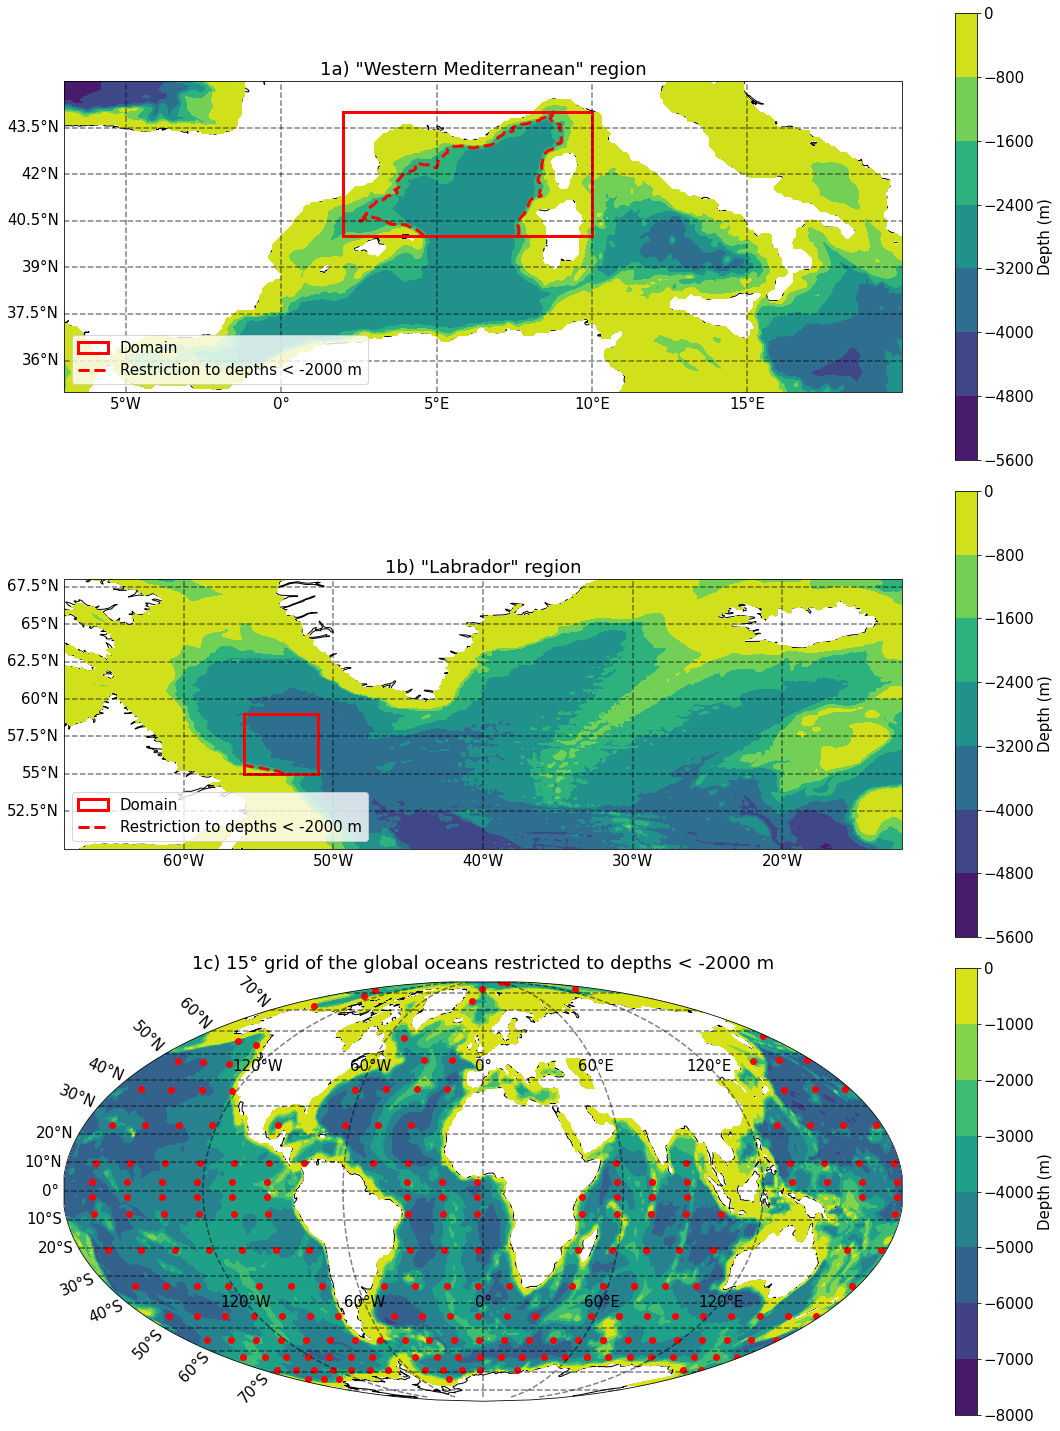

In [7]:
# Figure 1: The three regions of interest



# For loading the bathymetry at the global scale
bathy_global = - xr.open_dataset(path_to_npz_archives + 'eORCA1_R1_bathy_meter_v2.2_regular1.nc').Bathymetry

### For the information the localizations of the points of the 15° grid
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
lon_chosenPoints   = data['lon_chosenPoints']
lat_chosenPoints   = data['lat_chosenPoints']

### For the bathymetries of LIONb and LABs
bathy_eLIONb = - xr.open_dataset(path_to_npz_archives + 'NATLORCA12.L75_bathymetry_v2.4_eLIONb_regular01.nc').Bathymetry
bathy_eLIONb.data[bathy_eLIONb.data == 0] = np.nan # we set the continents to NaN values
bathy_LIONb = - xr.open_dataset(path_to_npz_archives + 'NATLORCA12.L75_bathymetry_v2.4_LIONb_regular01.nc').Bathymetry
bathy_LIONb.data[bathy_LIONb.data == 0] = np.nan   # we set the continents to NaN values

bathy_eLABs = - xr.open_dataset(path_to_npz_archives + 'NATLORCA12.L75_bathymetry_v2.4_eLABs_regular01.nc').Bathymetry
bathy_eLABs.data[bathy_eLABs.data == 0] = np.nan   # we set the continents to NaN values
bathy_LABs = - xr.open_dataset(path_to_npz_archives + 'NATLORCA12.L75_bathymetry_v2.4_LABs_regular01.nc').Bathymetry
bathy_LABs.data[bathy_LABs.data == 0] = np.nan     # we set the continents to NaN values



# ------------------------
#     Figure 1a: LIONb
# ------------------------

fig1 = plt.figure(figsize=(15,20))

ax = plt.subplot(3,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='k', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False

ctf = ax.contourf(bathy_eLIONb.lon, bathy_eLIONb.lat, bathy_eLIONb, transform=ccrs.PlateCarree())
cs = ax.contour(bathy_LIONb.lon, bathy_LIONb.lat, bathy_LIONb,[-2000],linestyles='--',colors=['r','r'],linewidths=3, transform=ccrs.PlateCarree())

cbar = plt.colorbar(ctf)
cbar.set_label('Depth (m)')

ax.add_patch(matplotlib.patches.Rectangle(xy=[2, 40], width=8, height=4,
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=3,
                                    linestyle='-',
                                    label='Domain',
                                    transform=ccrs.PlateCarree()));

plt.title('1a) "Western Mediterranean" region')
plt.tight_layout()



# to add a legend manually
# ------------------------
from matplotlib.lines import Line2D  
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='Restriction to depths < -2000 m', color='r', linestyle='--',linewidth=3)
handles.extend([line])
plt.legend(handles=handles, loc='lower left')



# ------------------------
#     Figure 1b: LABs
# ------------------------

ax2 = plt.subplot(3,1,2, projection=ccrs.PlateCarree())
ax2.set_extent([-68, -12, 50, 68],crs=ccrs.PlateCarree())
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='k', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False

ctf = ax2.contourf(bathy_eLABs.lon, bathy_eLABs.lat, bathy_eLABs, transform=ccrs.PlateCarree())
cs = ax2.contour(bathy_LABs.lon, bathy_LABs.lat, bathy_LABs,[-2000],linestyles='--',colors=['r','r'],linewidths=3, transform=ccrs.PlateCarree())

cbar = plt.colorbar(ctf)
cbar.set_label('Depth (m)')

ax2.add_patch(matplotlib.patches.Rectangle(xy=[-56, 55], width=5, height=4,
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=3,
                                    linestyle='-',
                                    label='Domain',
                                    transform=ccrs.PlateCarree()));

plt.title('1b) "Labrador" region')
plt.tight_layout()

# to add a legend manually
# ------------------------
from matplotlib.lines import Line2D  
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='Restriction to depths < -2000 m', color='r', linestyle='--',linewidth=3)
handles.extend([line])
plt.legend(handles=handles, loc='lower left')




# -----------------------------
#    Figure 1c: global15deg
# -----------------------------

## Map of the localizations of the selected points and the associated values of bathymetry

bathy_data_global = bathy_global.data.copy()
bathy_data_global[bathy_data_global == 0] = np.nan

ax3 = plt.subplot(3,1,3, projection=ccrs.Mollweide())    # projection Mollweide
ax3.coastlines()
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='k', alpha=0.5,
                  linestyle='--', ylocs = np.arange(-90,90,10))
gl.top_labels = gl.right_labels = False

#### Map of the bathymetry
## By using "[0:-1]", we remove the highest latitude (89.5°N) which gives an incomprehensible 
## bug with the Mollweide projection
ctf = plt.contourf(bathy_global.lon, bathy_global.lat[0:-1],bathy_data_global[0:-1,:],transform=ccrs.PlateCarree())
plt.plot(lon_chosenPoints,lat_chosenPoints,'ro', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ctf)
cbar.set_label('Depth (m)')
plt.title('1c) 15° grid of the global oceans restricted to depths < -2000 m')



### Figure 2

NotSignif : 4.3%
Signif : 22%
HighSignif : 74%


Text(0.5, 0.98, '2a) λs - Rh parameter space; 1D simulations global15deg ')

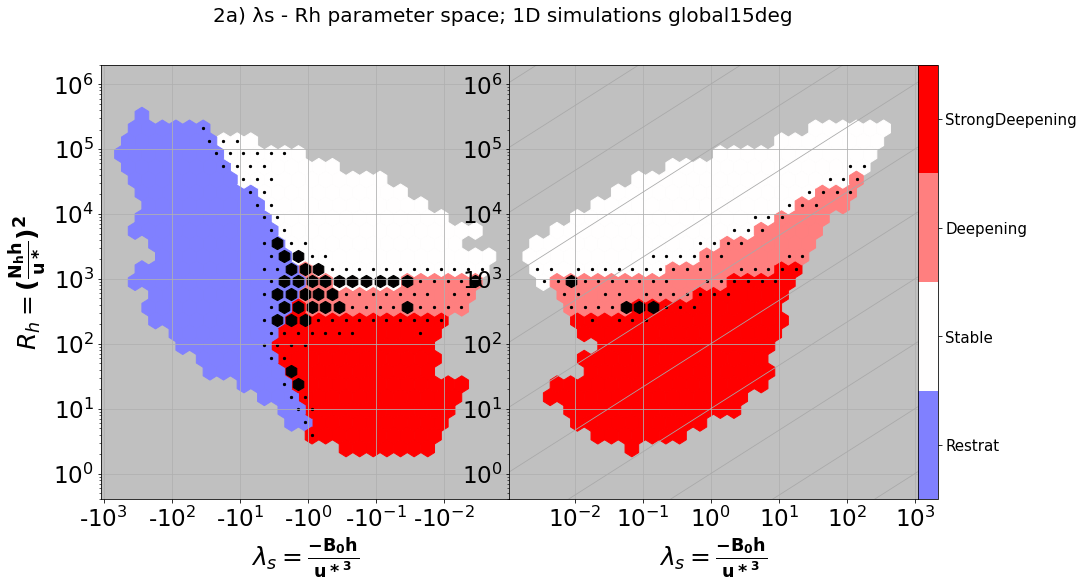

In [8]:
### 2a) λs - Rh parameter space; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"2a) λs - Rh parameter space; 1D simulations global15deg ", fontsize = 20)


NotSignif : 27%
Signif : 50%
HighSignif : 23%


Text(0.5, 0.98, '2b) f/N_h - Rh parameter space; 1D simulations global15deg ')

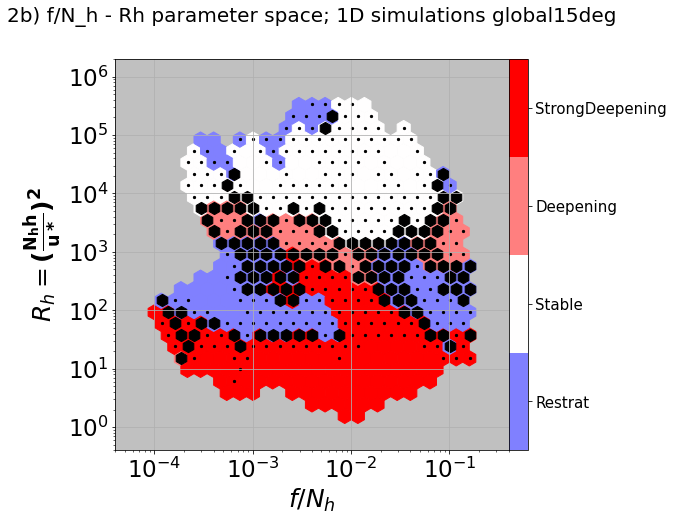

In [9]:
### 2b) f/N_h - Rh parameter space; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = foverN_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 4e-5; xmax = 4e-1; ymin = 4e-1; ymax = 2e6  # for hexbin_log
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,sc0,cb = hexbin_log(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$f/N_h$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid();  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0
Ntot_50 = Nsc0_50
Ntot_75 = Nsc0_75
print(f'NotSignif : {100*Ntot_50/Ntot:.5g}%')
print(f'Signif : {100*Ntot_75/Ntot:.5g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.5g}%')


plt.suptitle(f"2b) f/N_h - Rh parameter space; 1D simulations global15deg ", fontsize = 20)


NotSignif : 27%
Signif : 43%
HighSignif : 30%


Text(0.5, 0.98, '2c) λs - f/N parameter space; 1D simulations global15deg ')

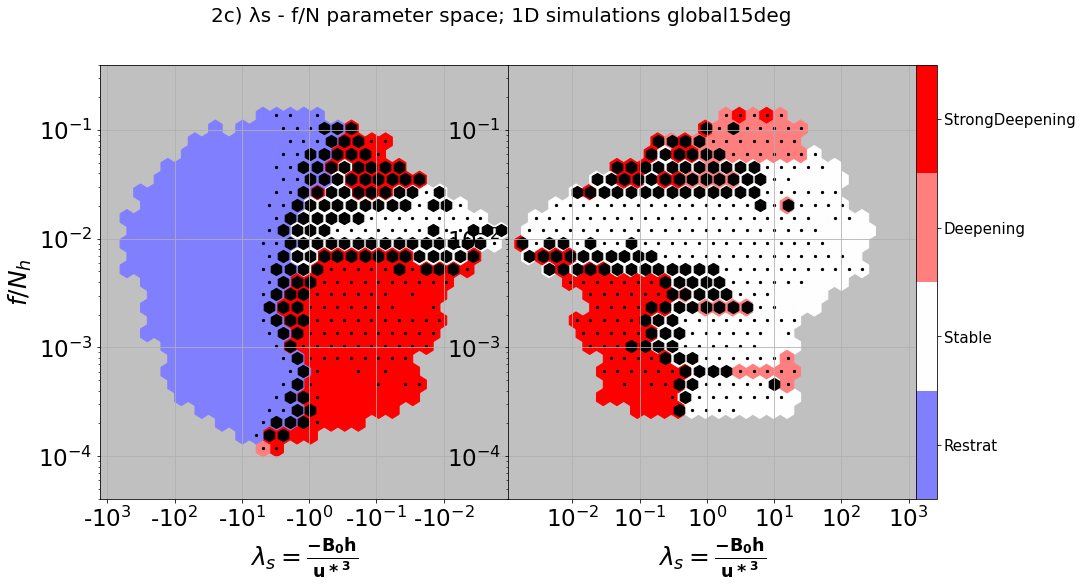

In [10]:
### 2c) λs - f/N_h parameter space; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = foverN_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.3e3; ymin = 4e-5; ymax = 4e-1
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$f/N_h$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"2c) λs - f/N parameter space; 1D simulations global15deg ", fontsize = 20)


### Figure 3

NotSignif : 10%
Signif : 28%
HighSignif : 62%


Text(0.5, 0.98, '3a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]')

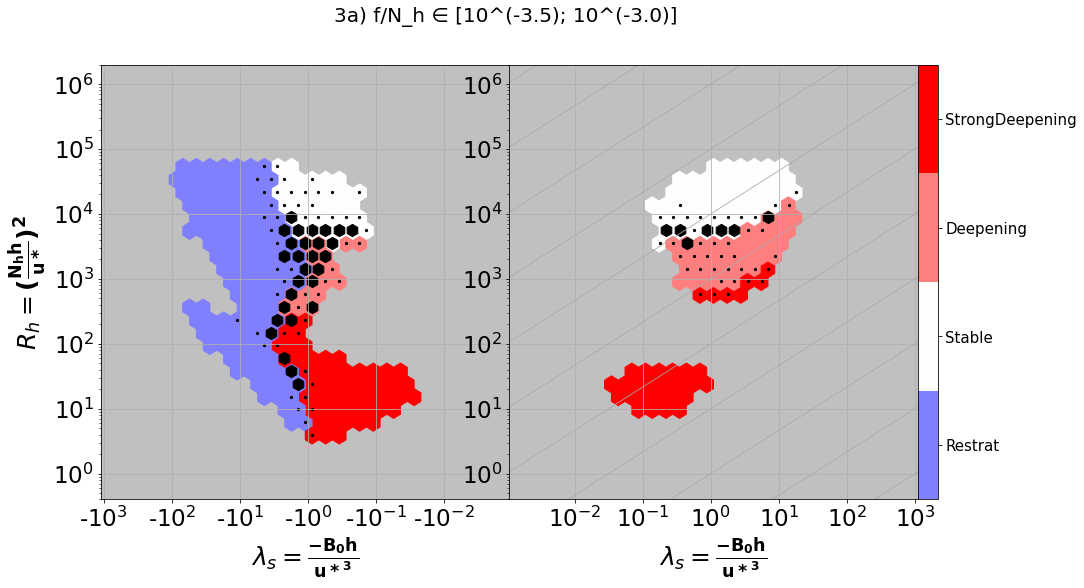

In [11]:
### 3a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# for sorting taking only for points for which f/N_h ∈ [10^(-3.5); 10^(-3.0)]
mask_reduction = (foverN_1Dmodels > 10**(-3.5)) & (foverN_1Dmodels < 10**(-3.0))
lambda_reduced = lambdas_1Dmodels[mask_reduction]
Rh_reduced = Rh_1Dmodels[mask_reduction]
dMLDdt_percent_1Dmodels_ps_reduced = dMLDdt_percent_1Dmodels_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_1Dmodels_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"3a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]", fontsize = 20)


NotSignif : 3%
Signif : 20%
HighSignif : 77%


Text(0.5, 0.98, '3b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]')

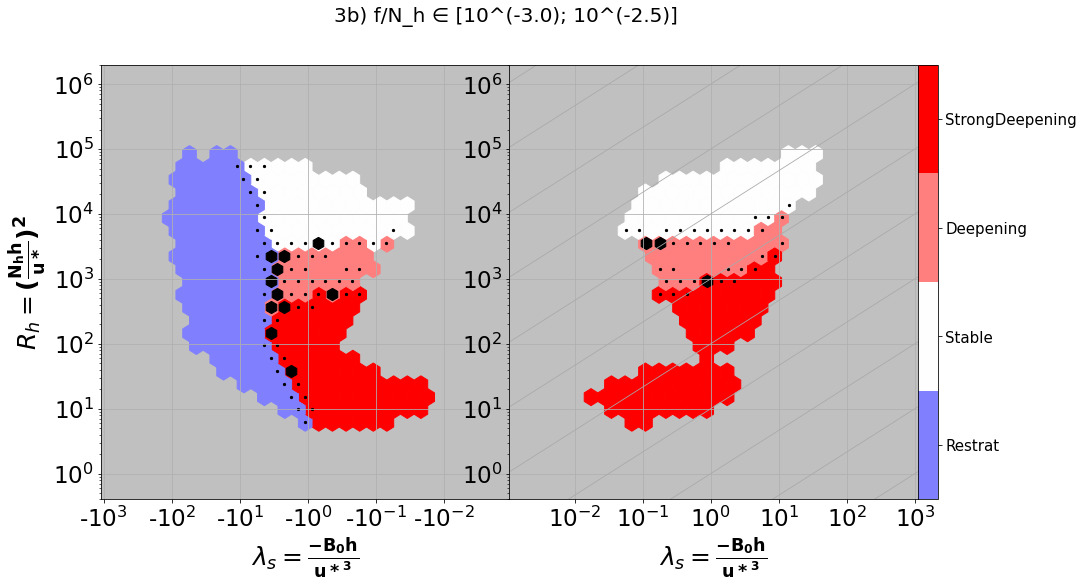

In [12]:
### 3b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# for sorting taking only for points for which f/N_h ∈ [10^(-3.0); 10^(-2.5)]
mask_reduction = (foverN_1Dmodels > 10**(-3.0)) & (foverN_1Dmodels < 10**(-2.5))
lambda_reduced = lambdas_1Dmodels[mask_reduction]
Rh_reduced = Rh_1Dmodels[mask_reduction]
dMLDdt_percent_1Dmodels_ps_reduced = dMLDdt_percent_1Dmodels_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_1Dmodels_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"3b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]", fontsize = 20)


NotSignif : 3.4%
Signif : 24%
HighSignif : 73%


Text(0.5, 0.98, '3c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]')

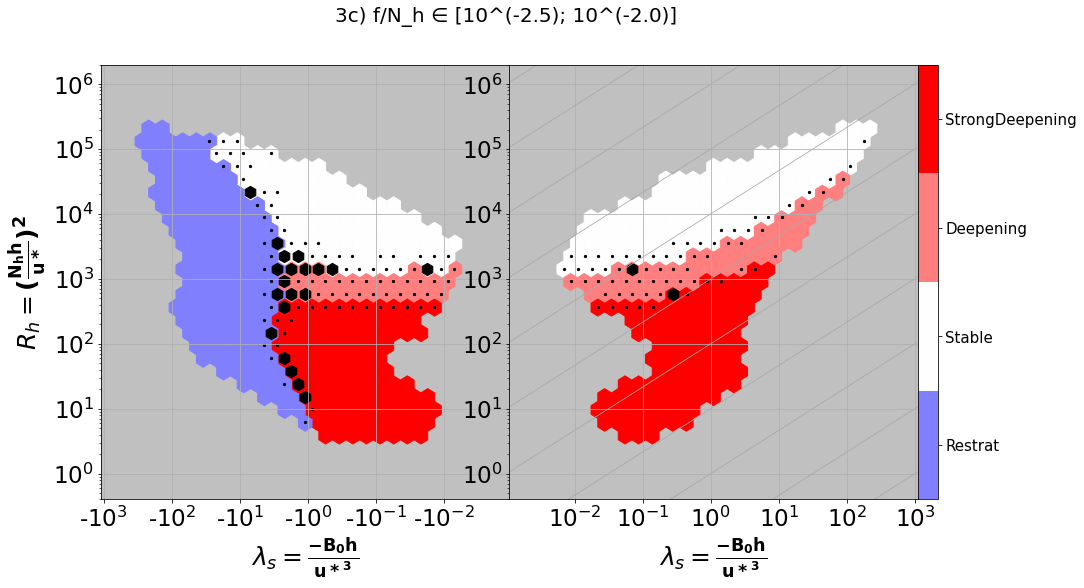

In [13]:
### 3c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# for sorting taking only for points for which f/N_h ∈ [10^(-2.5); 10^(-2.0)]
mask_reduction = (foverN_1Dmodels > 10**(-2.5)) & (foverN_1Dmodels < 10**(-2.0))
lambda_reduced = lambdas_1Dmodels[mask_reduction]
Rh_reduced = Rh_1Dmodels[mask_reduction]
dMLDdt_percent_1Dmodels_ps_reduced = dMLDdt_percent_1Dmodels_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_1Dmodels_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"3c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]", fontsize = 20)


NotSignif : 2.8%
Signif : 21%
HighSignif : 77%


Text(0.5, 0.98, '3d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]')

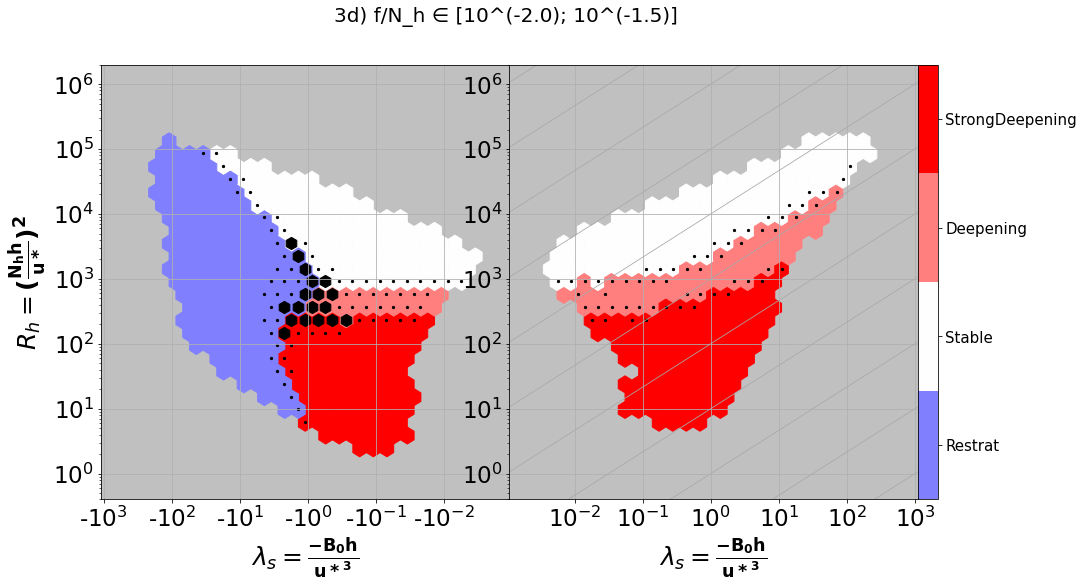

In [14]:
### 3d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# for sorting taking only for points for which f/N_h ∈ [10^(-2.0); 10^(-1.5)]
mask_reduction = (foverN_1Dmodels > 10**(-2.0)) & (foverN_1Dmodels < 10**(-1.5))
lambda_reduced = lambdas_1Dmodels[mask_reduction]
Rh_reduced = Rh_1Dmodels[mask_reduction]
dMLDdt_percent_1Dmodels_ps_reduced = dMLDdt_percent_1Dmodels_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_1Dmodels_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"3d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]", fontsize = 20)


NotSignif : 6.8%
Signif : 29%
HighSignif : 64%


Text(0.5, 0.98, '3e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]')

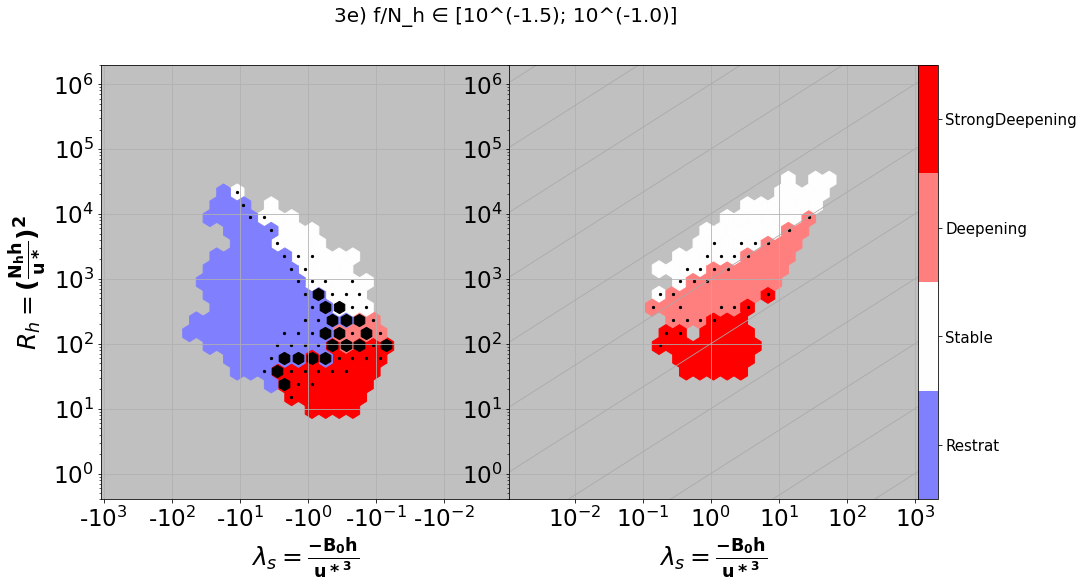

In [15]:
### 3e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]; 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

# for sorting taking only for points for which f/N_h ∈ [10^(-1.5); 10^(-1.0)]
mask_reduction = (foverN_1Dmodels > 10**(-1.5)) & (foverN_1Dmodels < 10**(-1.0))
lambda_reduced = lambdas_1Dmodels[mask_reduction]
Rh_reduced = Rh_1Dmodels[mask_reduction]
dMLDdt_percent_1Dmodels_ps_reduced = dMLDdt_percent_1Dmodels_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_1Dmodels_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"3e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]", fontsize = 20)


### Figure 4

In [16]:
log_Rhc = np.array([3.62,3.62,3.15,2.90,2.42])
log_Rhc_star = np.array([3.48,3.37,3.42,3.33,3.12])
log_lambdac = np.array([0.20,0.37,-0.39,-0.63,-1.05])

log_Rhc_n = (log_Rhc - log_Rhc[0])
log_Rhc_star_n = (log_Rhc_star - log_Rhc_star[0])
log_lambdac_n = (log_lambdac - log_lambdac[0])

Rhc = 10**log_Rhc
Rhc_star = 10**log_Rhc_star
lambdac = 10**log_lambdac

Rhc_n = Rhc/Rhc[0]
Rhc_star_n = Rhc_star/Rhc_star[0]
lambdac_n = lambdac/lambdac[0]

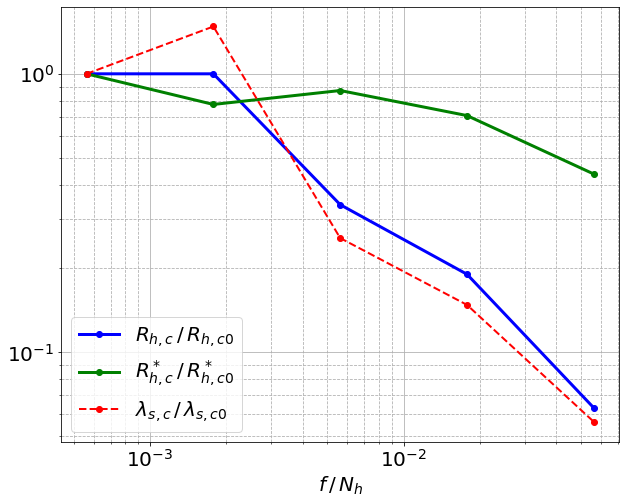

In [17]:
foverN_xaxis = 10**np.array([-3.25,-2.75,-2.25,-1.75,-1.25])
plt.figure(figsize=(10,8))
plt.plot(foverN_xaxis,Rhc_n,label=r'$R_{h,c} \, / \, R_{h,c0}$',color='b',marker='o',linewidth=3)
plt.plot(foverN_xaxis,Rhc_star_n,label=r'$R_{h,c}^* \, / \, R_{h,c0}^*$',color='g',marker='o',linewidth=3)
plt.plot(foverN_xaxis,lambdac_n,label=r'$\lambda_{s,c} \, / \, \lambda_{s,c0}$',color='r',marker='o',linestyle='--',linewidth=2)
#plt.plot(foverN_xaxis,(Rhc_n/Rhc_star_n)**(3/2))   # analytical expression of lambda_c
plt.xscale('log')
plt.yscale('log')
plt.grid(which='major')
plt.grid(which='minor', linestyle='--')
plt.legend(fontsize = 20)
plt.xlabel(r'$f \, / \, N_h$',fontsize = 20)
plt.gca().yaxis.set_tick_params(labelsize = 20)
plt.gca().xaxis.set_tick_params(labelsize = 20)

### Figure 5

In [18]:
### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

9.159571950338051
17.13183699316221
35.42385999475492
32.42188349526983
3.8823822895411837


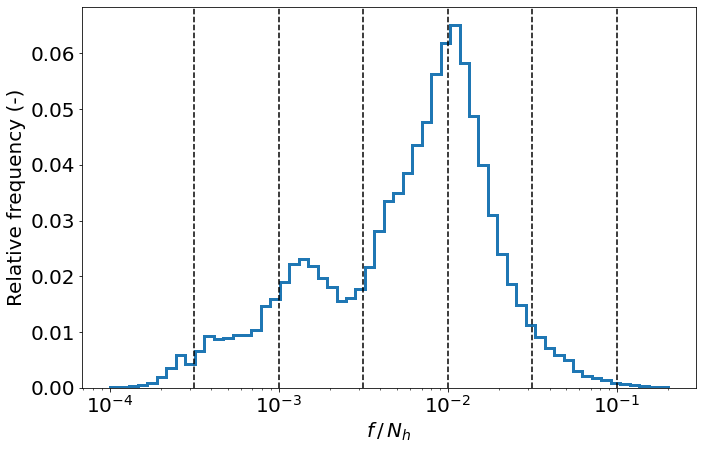

In [19]:
plt.figure(figsize=(11,7))
plt.xscale('log')
bins = 10**np.linspace(-4,-0.7,60)
total_nb = foverN_1Dmodels.size
weights = np.ones((total_nb,1))*1/total_nb
# We do the normalization by hands because the "density" argument does not work with the way
# we plot the log scale (cf https://stackoverflow.com/questions/41000668/log-x-axis-for-histogram)

hist = plt.hist(foverN_1Dmodels,weights=weights,bins=bins,histtype='step',linewidth=3);

plt.xlabel(r'$f \, / \, N_h$',fontsize = 20)
plt.ylabel('Relative frequency (-)',fontsize = 20)
plt.gca().yaxis.set_tick_params(labelsize = 20)
plt.gca().xaxis.set_tick_params(labelsize = 20)
plt.axvline(10**(-1.0),color='k',linestyle='--')
plt.axvline(10**(-1.5),color='k',linestyle='--')
plt.axvline(10**(-2.0),color='k',linestyle='--')
plt.axvline(10**(-2.5),color='k',linestyle='--')
plt.axvline(10**(-3.0),color='k',linestyle='--')
plt.axvline(10**(-3.5),color='k',linestyle='--')

print(((foverN_1Dmodels > 10**(-3.5)) & (foverN_1Dmodels < 10**(-3.0))).sum() / total_nb * 100)
print(((foverN_1Dmodels > 10**(-3.0)) & (foverN_1Dmodels < 10**(-2.5))).sum() / total_nb * 100)
print(((foverN_1Dmodels > 10**(-2.5)) & (foverN_1Dmodels < 10**(-2.0))).sum() / total_nb * 100)
print(((foverN_1Dmodels > 10**(-2.0)) & (foverN_1Dmodels < 10**(-1.5))).sum() / total_nb * 100)
print(((foverN_1Dmodels > 10**(-1.5)) & (foverN_1Dmodels < 10**(-1.0))).sum() / total_nb * 100)

### Figure 6

NotSignif : 4.4%
Signif : 22%
HighSignif : 74%


Text(0.5, 0.98, '6a) 1D simulations global15deg')

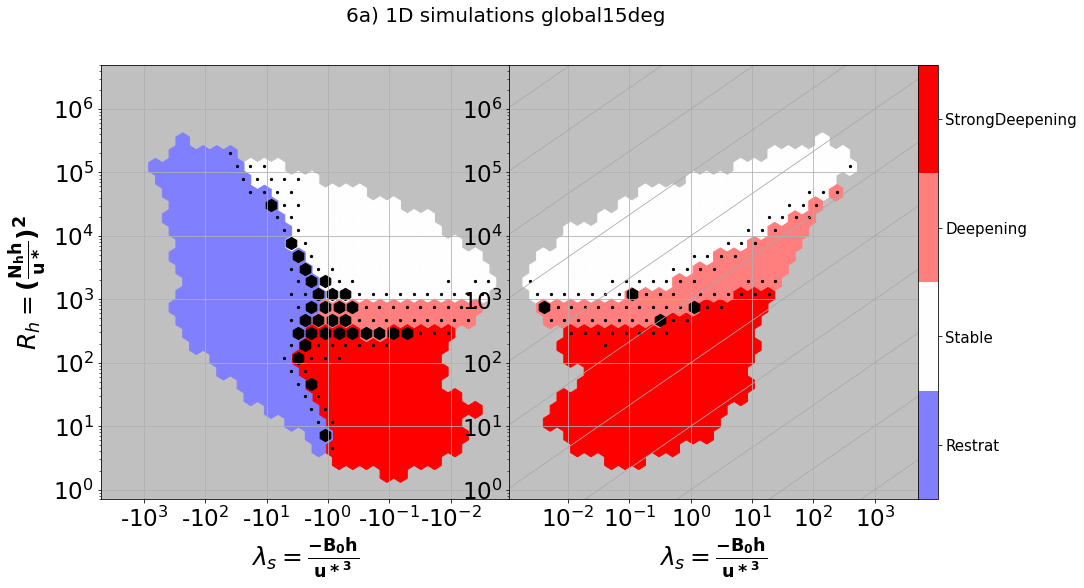

In [20]:
### 6a) 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6a) 1D simulations global15deg", fontsize = 20)


NotSignif : 8.2%
Signif : 42%
HighSignif : 50%


Text(0.5, 0.98, '6b) eORCA1 global15deg')

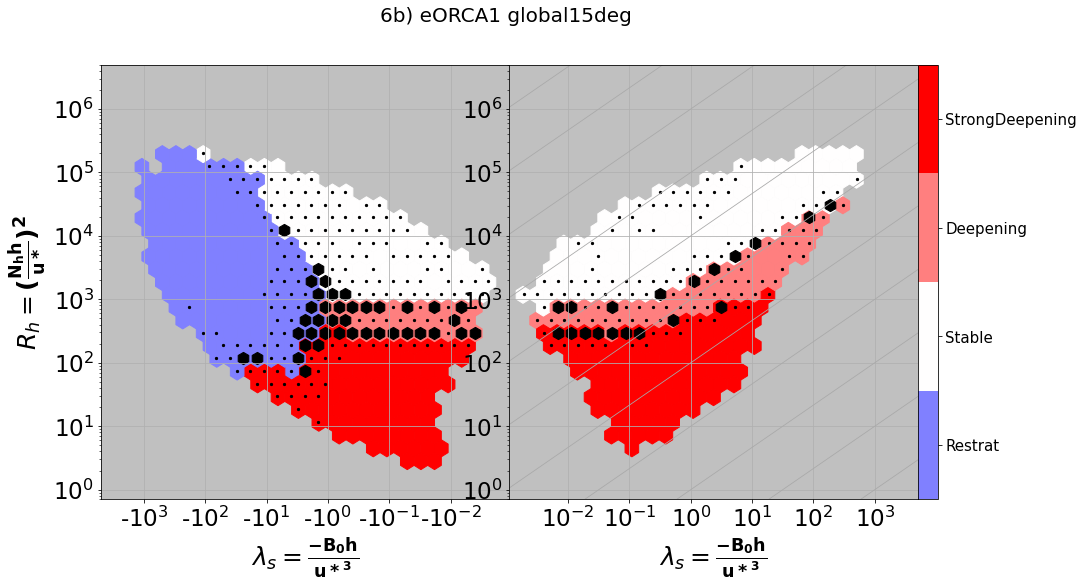

In [21]:
### 6b) eORCA1 global15deg 

### For loading eORCA1 global15deg data
filename = path_to_npz_archives + 'eORCA1_y2006-2015_global15deg_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6b) eORCA1 global15deg", fontsize = 20)


NotSignif : 16%
Signif : 44%
HighSignif : 40%


Text(0.5, 0.98, '6c) eORCA12 global15deg')

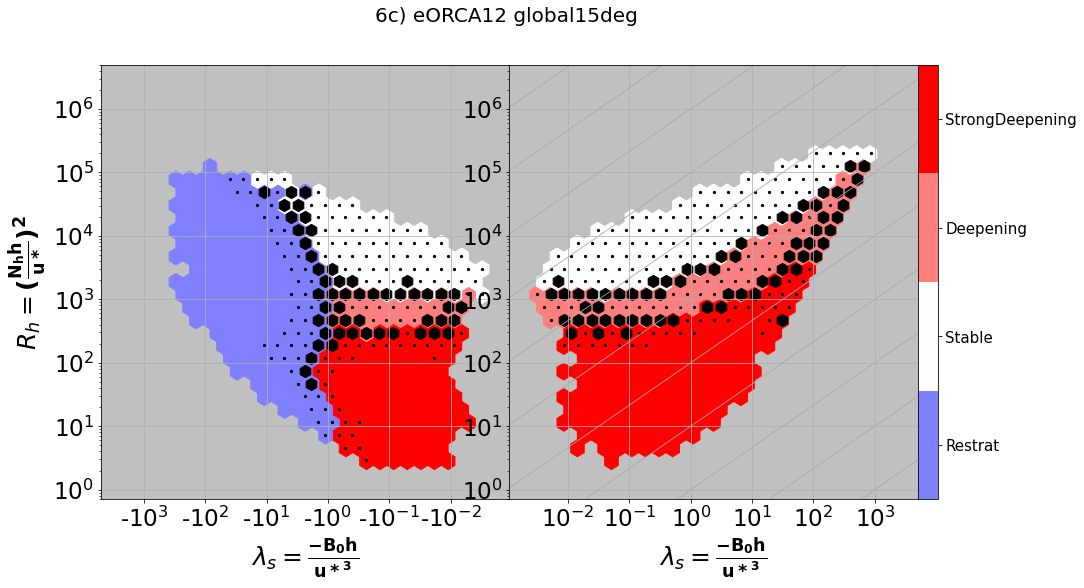

In [22]:
### 6c) eORCA12 global15deg 

### For loading eORCA12 global15deg data
filename = path_to_npz_archives + 'eORCA12_y2006-2015_global15deg_ps.npz'
data = np.load(filename)
dMLDdt_eORCA12_ps  = data['dMLDdt_eORCA12_ps']
MLD_eORCA12_b_ps   = data['MLD_eORCA12_b_ps']
lambdas_eORCA12    = data['lambdas_eORCA12']
Rh_eORCA12         = data['Rh_eORCA12']
dMLDdt_percent_eORCA12_ps = 100*dMLDdt_eORCA12_ps/(MLD_eORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA12
y_array = Rh_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6c) eORCA12 global15deg", fontsize = 20)


NotSignif : 2.9%
Signif : 19%
HighSignif : 78%


Text(0.5, 0.98, '6d) 1D simulations LIONb')

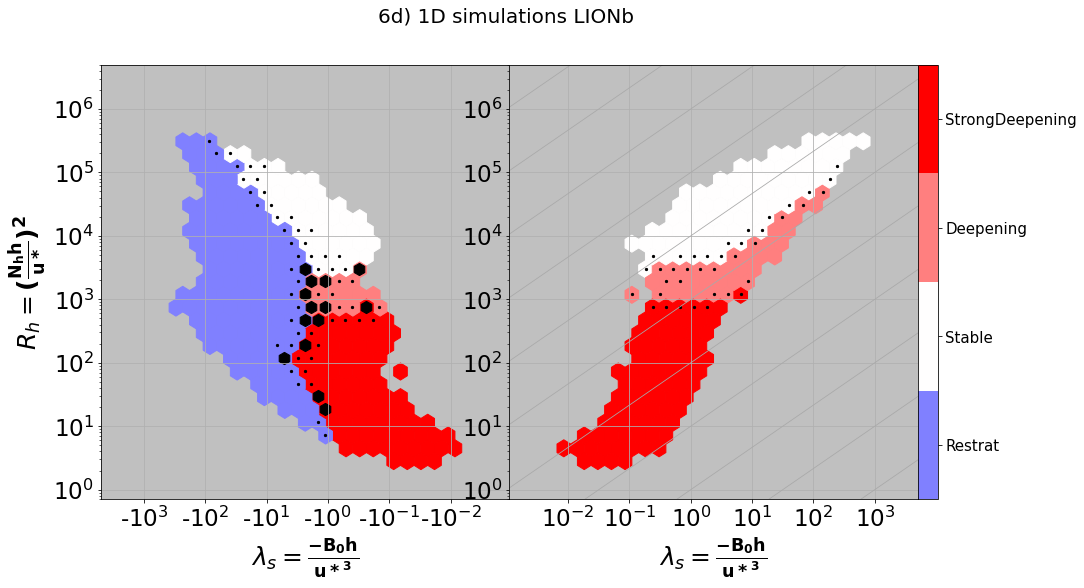

In [23]:
### 6d) 1D simulations LIONb 

### For loading 1D simus LIONb data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples18_nyears20_eORCA1_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6d) 1D simulations LIONb", fontsize = 20)


NotSignif : 12%
Signif : 46%
HighSignif : 42%


Text(0.5, 0.98, '6e) eORCA1 LIONb')

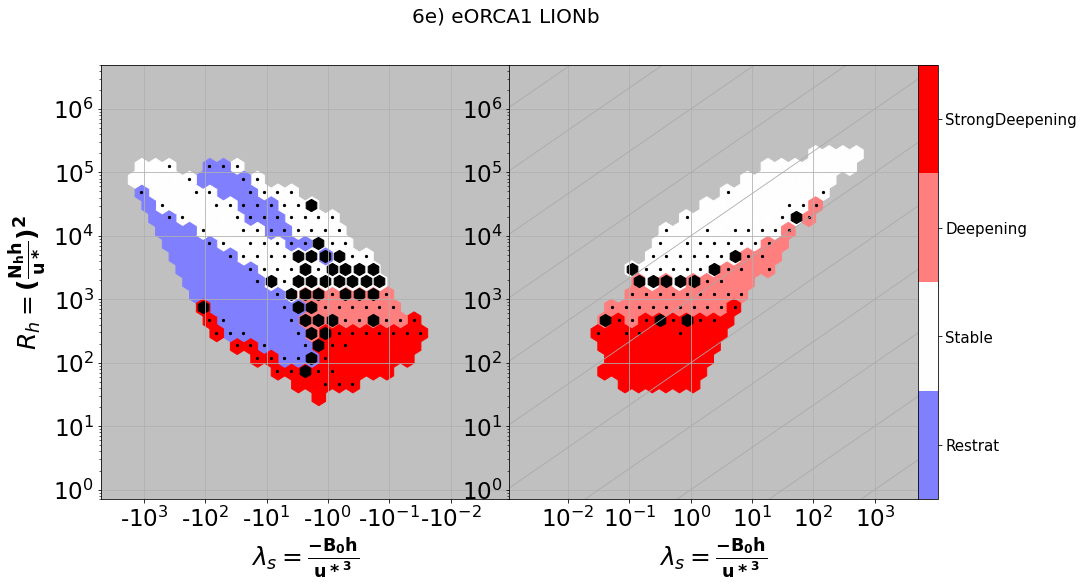

In [24]:
### 6e) eORCA1 LIONb 

### For loading eORCA1 LIONb data
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6e) eORCA1 LIONb", fontsize = 20)


NotSignif : 16%
Signif : 26%
HighSignif : 58%


Text(0.5, 0.98, '6f) eORCA12 LIONb')

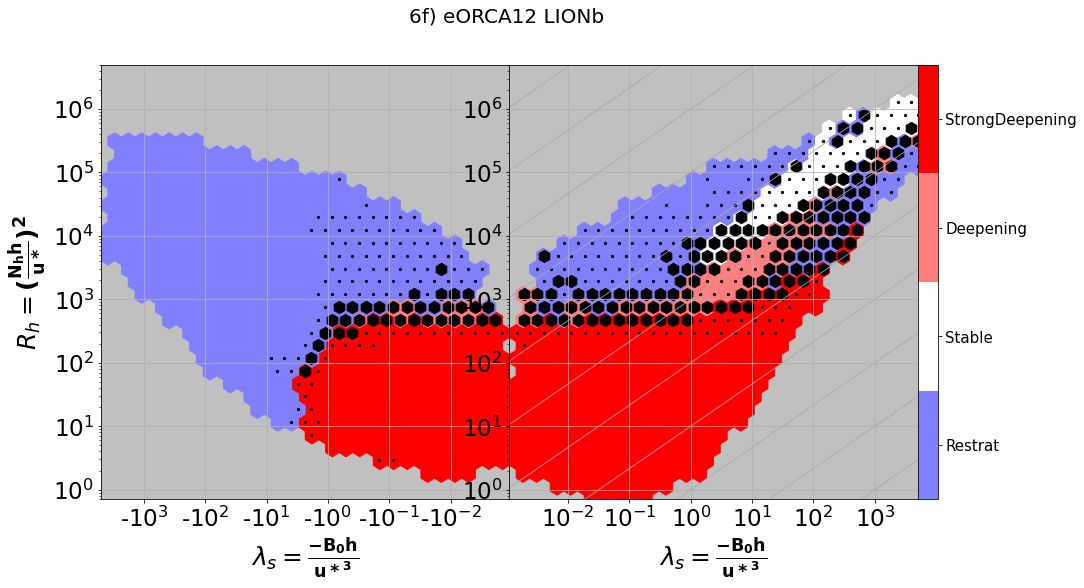

In [25]:
### 6f) eORCA12 LIONb 

### For loading eORCA12 LIONb data
filename = path_to_npz_archives + 'eORCA12_y2006-2015_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA12_ps  = data['dMLDdt_ORCA12_ps']
MLD_eORCA12_b_ps   = data['MLD_ORCA12_b_ps']
lambdas_eORCA12    = data['lambdas_ORCA12']
Rh_eORCA12         = data['Rh_ORCA12']
dMLDdt_percent_eORCA12_ps = 100*dMLDdt_eORCA12_ps/(MLD_eORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA12
y_array = Rh_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6f) eORCA12 LIONb", fontsize = 20)


NotSignif : 22%
Signif : 23%
HighSignif : 55%


Text(0.5, 0.98, '6g) eNATL60 LIONb')

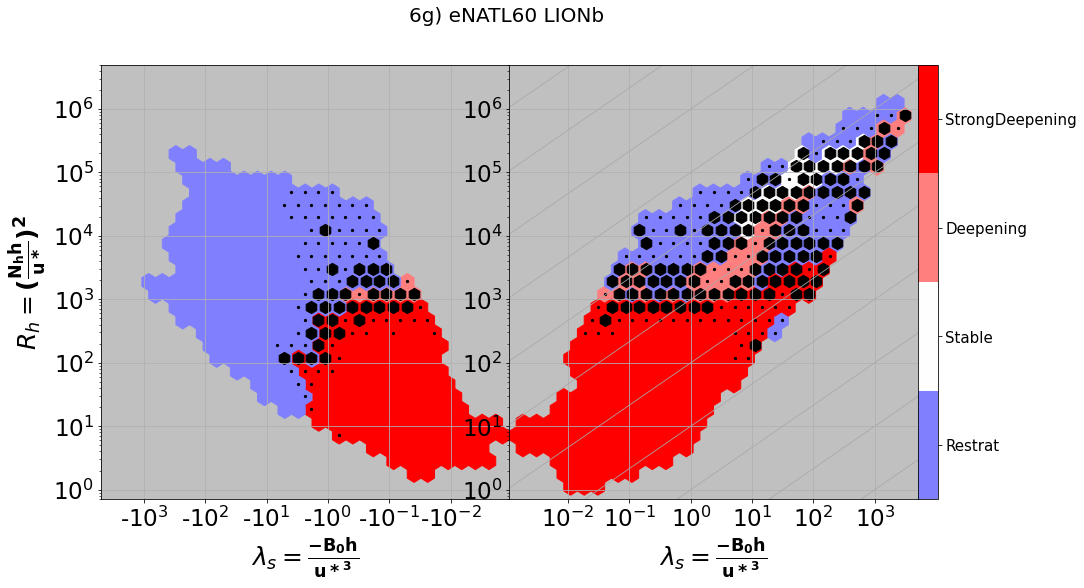

In [26]:
### 6g) eNATL60 LIONb 

### For loading eNATL60 LIONb data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"6g) eNATL60 LIONb", fontsize = 20)


### Figure 7

NotSignif : 12%
Signif : 46%
HighSignif : 42%


Text(0.5, 0.98, '7a) eORCA1 LIONb')

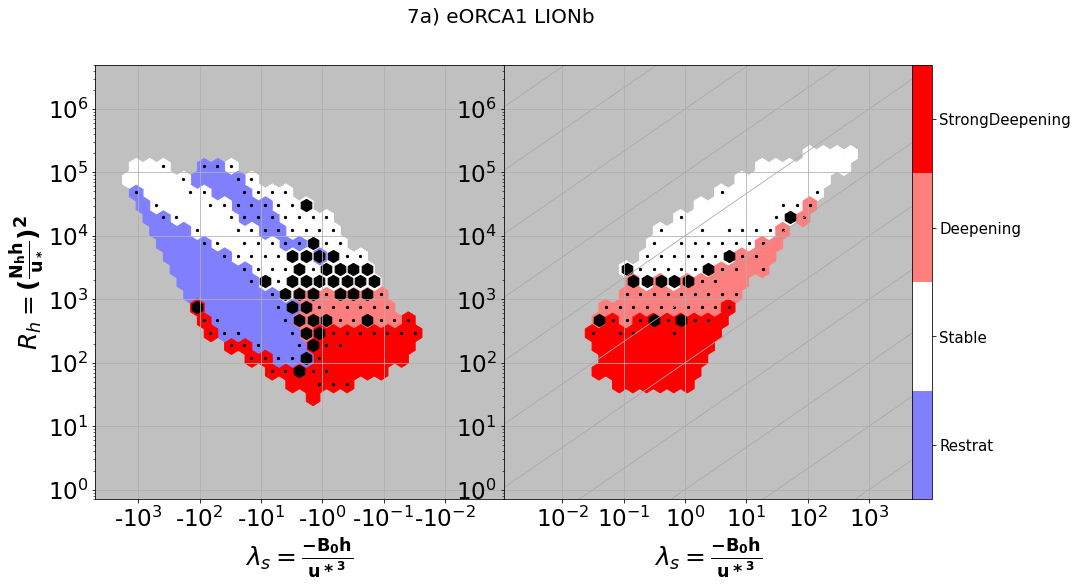

In [27]:
### 7a) eORCA1 LIONb 

#### For loading eORCA1 LIONb data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7a) eORCA1 LIONb", fontsize = 20)


NotSignif : 14%
Signif : 44%
HighSignif : 42%


Text(0.5, 0.98, '7b) eORCA1GM LIONb')

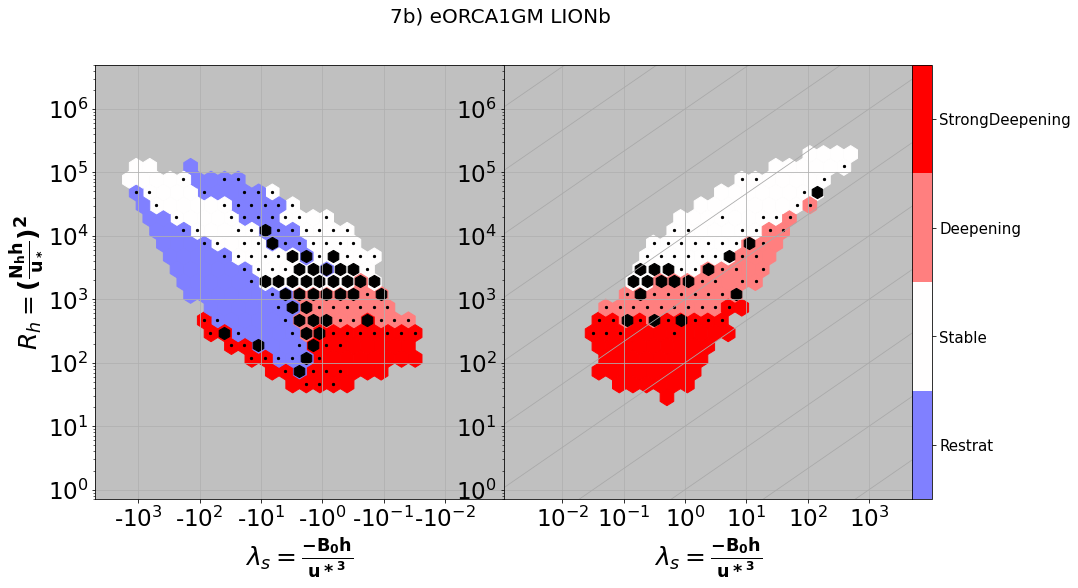

In [28]:
### 7b) eORCA1GM LIONb 

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7b) eORCA1GM LIONb", fontsize = 20)


NotSignif : 22%
Signif : 23%
HighSignif : 55%


Text(0.5, 0.98, '7c) eNATL60 LIONb')

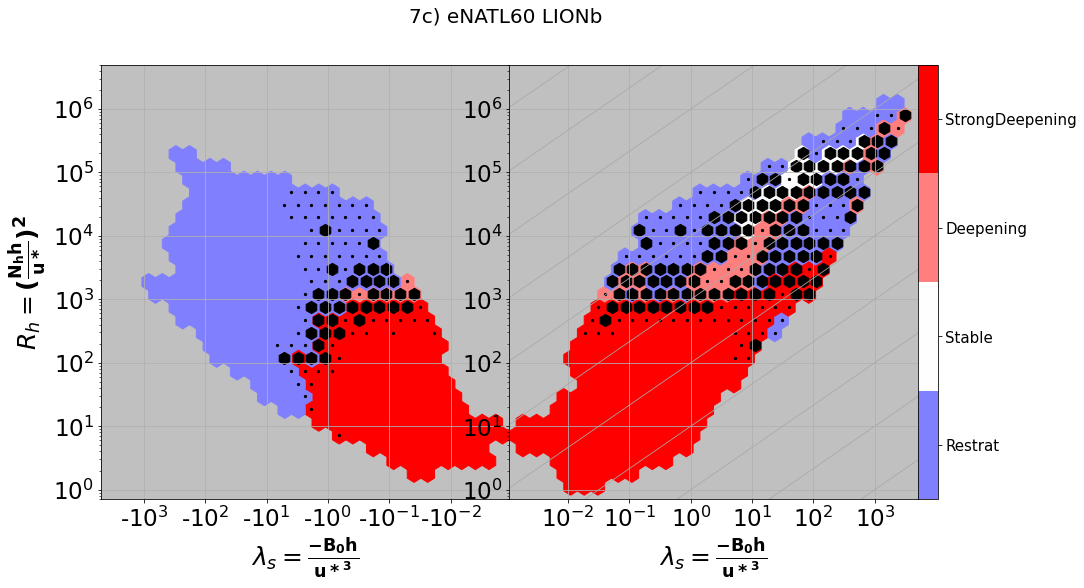

In [29]:
### 7c) eNATL60 LIONb 

### For loading eNATL60 LIONb data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7c) eNATL60 LIONb", fontsize = 20)


NotSignif : 16%
Signif : 36%
HighSignif : 48%


Text(0.5, 0.98, '7d) eORCA1 LABs')

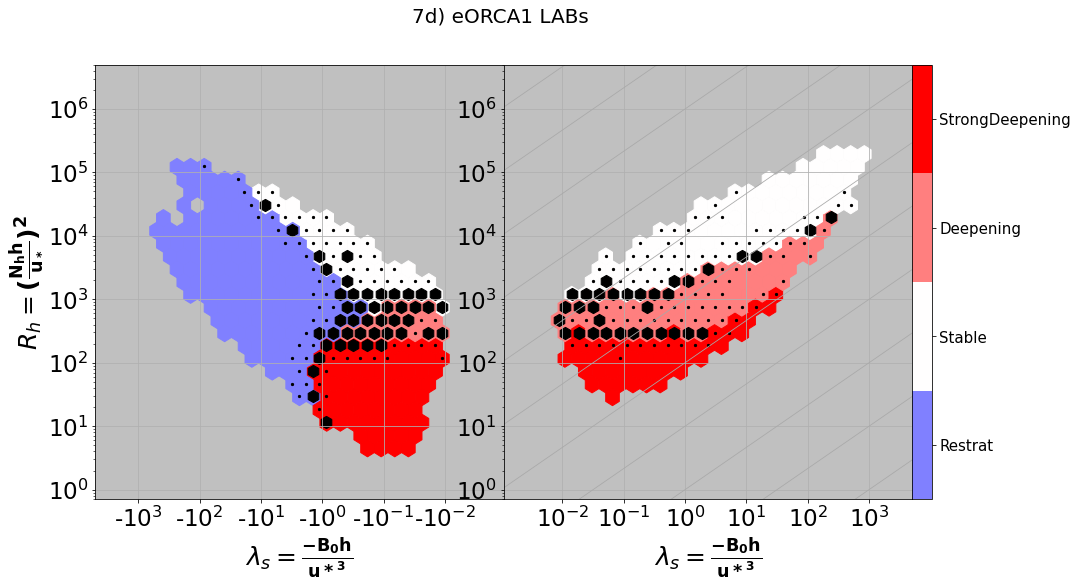

In [30]:
### 7d) eORCA1 LABs 

#### For loading eORCA1 LABs data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7d) eORCA1 LABs", fontsize = 20)


NotSignif : 19%
Signif : 34%
HighSignif : 47%


Text(0.5, 0.98, '7e) eORCA1GM LABs')

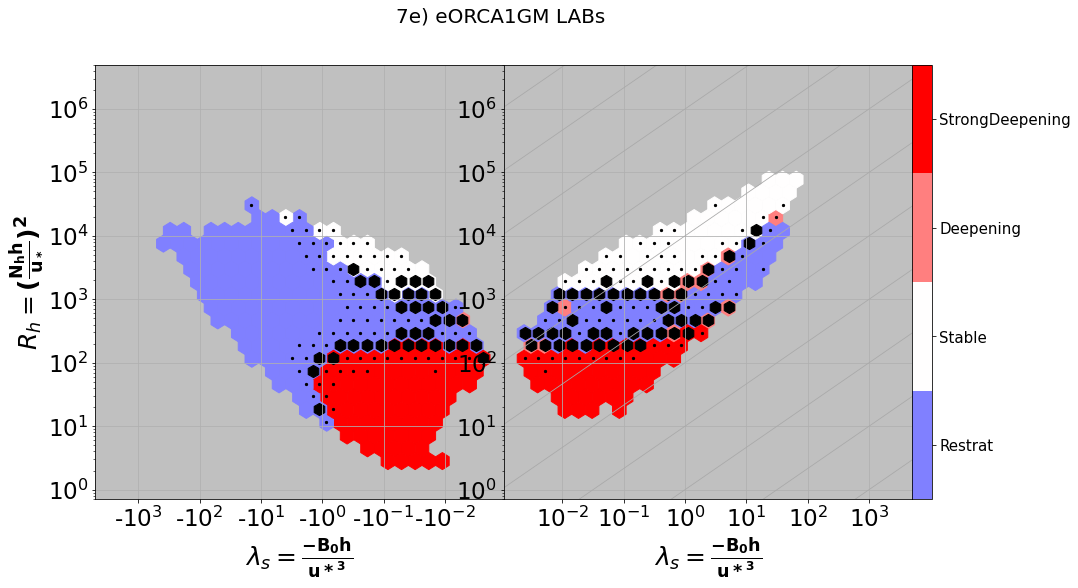

In [31]:
### 7e) eORCA1GM LABs 

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7e) eORCA1GM LABs", fontsize = 20)


NotSignif : 36%
Signif : 27%
HighSignif : 37%


Text(0.5, 0.98, '7f) eNATL60 LABs')

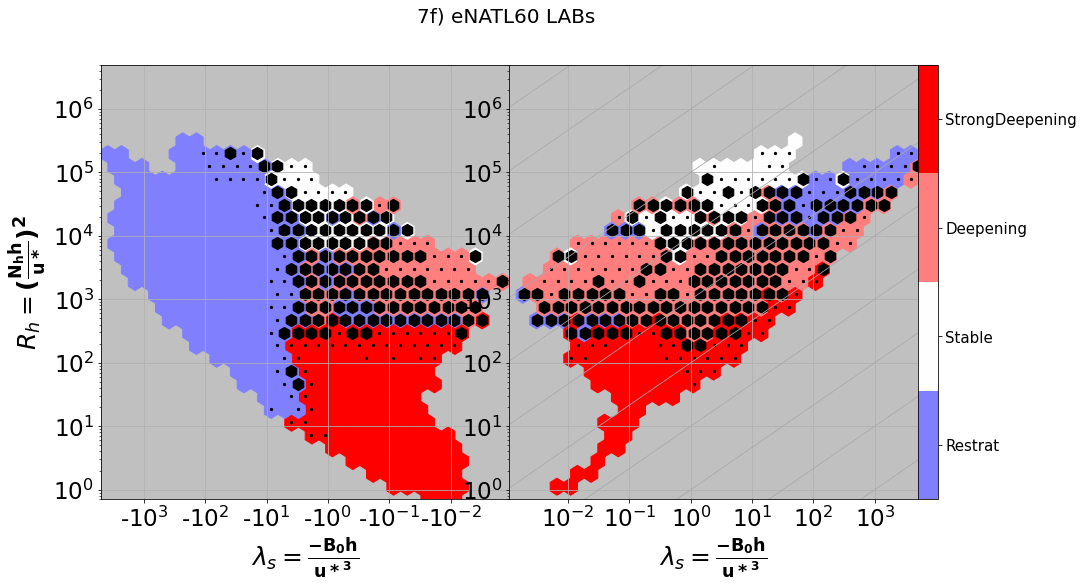

In [32]:
### 7f) eNATL60 LABs 

### For loading eNATL60 LABs data
filename = path_to_npz_archives + 'eNATL60_y2010m01-10_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eNATL60_ps  = data['dMLDdt_eNATL60_ps']
MLD_eNATL60_b_ps  = data['MLD_eNATL60_b_ps']
lambdas_eNATL60    = data['lambdas_eNATL60']
Rh_eNATL60         = data['Rh_eNATL60']
dMLDdt_percent_eNATL60_ps = 100*dMLDdt_eNATL60_ps/(MLD_eNATL60_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eNATL60
y_array = Rh_eNATL60
my_var  = dMLDdt_percent_eNATL60_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"7f) eNATL60 LABs", fontsize = 20)


### Figure 8

In [33]:
####   Calculation Proxy_GM LIONb for eORCA1GM  ###
### ---------------------------------------- ###

#R_earth = 6373.0 * 1000     # earth radius [m]
#
#nav_lon_eORCA1GM = gridT_eORCA1GM.nav_lon
#nav_lat_eORCA1GM = gridT_eORCA1GM.nav_lat
#
#dlon_left = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = 1))
#dlat_left = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = 1))
#a_left = np.sin(dlat_left / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_left / 2)**2
#c_left = 2 * np.arctan2(np.sqrt(a_left), np.sqrt(1 - a_left))
#distance_left = R_earth * c_left
#
#dlon_right = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = -1))
#dlat_right = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = -1))
#a_right = np.sin(dlat_right / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_right / 2)**2
#c_right = 2 * np.arctan2(np.sqrt(a_right), np.sqrt(1 - a_right))
#distance_right = R_earth * c_right
#
#dlon_down = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = 1))
#dlat_down = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = 1))
#a_down = np.sin(dlat_down / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_down / 2)**2
#c_down = 2 * np.arctan2(np.sqrt(a_down), np.sqrt(1 - a_down))
#distance_down = R_earth * c_down
#
#dlon_up = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = -1))
#dlat_up = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = -1))
#a_up = np.sin(dlat_up / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_up / 2)**2
#c_up = 2 * np.arctan2(np.sqrt(a_up), np.sqrt(1 - a_up))
#distance_up = R_earth * c_up
#
#
#drhodx_left = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = 1))  /  distance_left
#drhodx_right = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = -1))  /  distance_right
#drhody_down = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = 1))  /  distance_down
#drhody_up = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = -1))  /  distance_up
#
#dz_partialz = 1.1 * MLD_eORCA1GM_b - 1 * MLD_eORCA1GM_b
#drhodz = (temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]) / dz_partialz
#
##proxy_GM_eORCA1GM_b = np.sqrt(1/4*(drhodx_left**2 + drhodx_right**2 + drhody_down**2 + drhody_up**2)/drhodz**2)
#drhodlateral_square_max_temp = np.maximum(drhodx_left**2,drhodx_right**2)
#drhodlateral_square_max_temp = np.maximum(drhodlateral_square_max_temp,drhody_down**2)
#drhodlateral_square_max = np.maximum(drhodlateral_square_max_temp,drhody_up**2)
#proxy_GM_eORCA1GM_b = np.sqrt(drhodlateral_square_max / drhodz**2)
#
##plt.contourf(proxy_GM_eORCA1GM_b.mean(('time_counter')))
##plt.colorbar()
##
##plt.figure()
##plt.plot(proxy_GM_eORCA1GM_b.mean(('x','y')))
#
#DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
#bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
#mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
#mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)
#
#proxy_GM_eORCA1GM_b_flat = proxy_GM_eORCA1GM_b.values.flatten()
#proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_flat[mask_eORCA1GM_flat]


In [34]:
####   Calculation Proxy_GM LABs for eORCA1GM  ###
### ---------------------------------------- ###

#R_earth = 6373.0 * 1000     # earth radius [m]
#
#nav_lon_eORCA1GM = gridT_eORCA1GM.nav_lon
#nav_lat_eORCA1GM = gridT_eORCA1GM.nav_lat
#
#dlon_left = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = 1))
#dlat_left = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = 1))
#a_left = np.sin(dlat_left / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_left / 2)**2
#c_left = 2 * np.arctan2(np.sqrt(a_left), np.sqrt(1 - a_left))
#distance_left = R_earth * c_left
#
#dlon_right = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(x = -1))
#dlat_right = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(x = -1))
#a_right = np.sin(dlat_right / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_right / 2)**2
#c_right = 2 * np.arctan2(np.sqrt(a_right), np.sqrt(1 - a_right))
#distance_right = R_earth * c_right
#
#dlon_down = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = 1))
#dlat_down = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = 1))
#a_down = np.sin(dlat_down / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_down / 2)**2
#c_down = 2 * np.arctan2(np.sqrt(a_down), np.sqrt(1 - a_down))
#distance_down = R_earth * c_down
#
#dlon_up = np.radians(nav_lon_eORCA1GM - nav_lon_eORCA1GM.shift(y = -1))
#dlat_up = np.radians(nav_lat_eORCA1GM - nav_lat_eORCA1GM.shift(y = -1))
#a_up = np.sin(dlat_up / 2)**2 + np.cos(np.radians(nav_lat_eORCA1GM)) * np.cos(np.radians(nav_lat_eORCA1GM.shift(x = 1))) * np.sin(dlon_up / 2)**2
#c_up = 2 * np.arctan2(np.sqrt(a_up), np.sqrt(1 - a_up))
#distance_up = R_earth * c_up
#
#
#drhodx_left = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = 1))  /  distance_left
#drhodx_right = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(x = -1))  /  distance_right
#drhody_down = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = 1))  /  distance_down
#drhody_up = (temp_DeltaRho[:,:,:,0] - temp_DeltaRho[:,:,:,0].shift(y = -1))  /  distance_up
#
#dz_partialz = 1.1 * MLD_eORCA1GM_b - 1 * MLD_eORCA1GM_b
#drhodz = (temp_DeltaRho[:,:,:,1] - temp_DeltaRho[:,:,:,0]) / dz_partialz
#
##proxy_GM_eORCA1GM_b = np.sqrt(1/4*(drhodx_left**2 + drhodx_right**2 + drhody_down**2 + drhody_up**2)/drhodz**2)
#drhodlateral_square_max_temp = np.maximum(drhodx_left**2,drhodx_right**2)
#drhodlateral_square_max_temp = np.maximum(drhodlateral_square_max_temp,drhody_down**2)
#drhodlateral_square_max = np.maximum(drhodlateral_square_max_temp,drhody_up**2)
#proxy_GM_eORCA1GM_b = np.sqrt(drhodlateral_square_max / drhodz**2)
#
##plt.contourf(proxy_GM_eORCA1GM_b.mean(('time_counter')))
##plt.colorbar()
##
##plt.figure()
##plt.plot(proxy_GM_eORCA1GM_b.mean(('x','y')))
#
#
#DeltaRho_eORCA1GM_b_flat = DeltaRho_eORCA1GM_b.values.flatten()
#bathy_eORCA1GM_flat  = bathy_eORCA1GM.expand_dims(dim={'time_counter':t_eORCA1GM[1::]}).values.flatten()
#mask_eORCA1GM_flat   = (bathy_eORCA1GM_flat < -2000)   # removing the continents (<=> np.isnan(lambdas_full)==False)
#mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (DeltaRho_eORCA1GM_b_flat > 0)
#
#proxy_GM_eORCA1GM_b_flat = proxy_GM_eORCA1GM_b.values.flatten()
#proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_flat[mask_eORCA1GM_flat]


Text(0.5, 0.98, '8a) Index GM LIONb (eORCA1GM)')

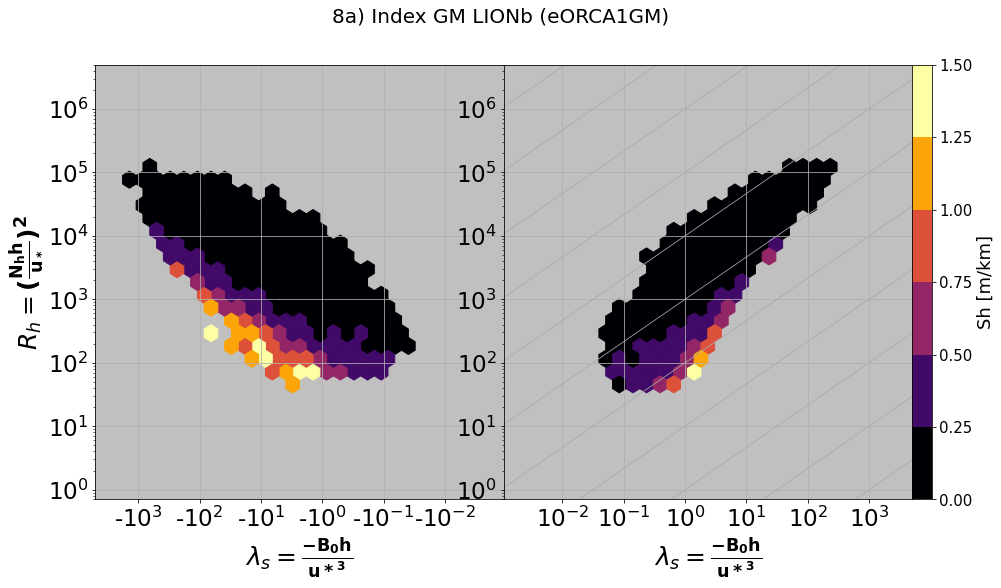

In [35]:
### 8a) eORCA1GM LIONb ProxyGM 

#### For loading LIONb eORCA1GM data
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LIONb proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LIONb_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']


#### -------------------------------- ###
####          HEXBIN PLOT             ###
#### -------------------------------- ###


### Variables that can be plotted
### -----------------------------
### dMLDdt_percent (dMLDdt/MLD)    dMLDdt_percent_classes    Shmax

vmin = 0*1000
vmax = 0.0015*1000
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6

my_norm = None
my_var = proxy_GM_eORCA1GM_b_ps*1000
my_clabel = 'Sh [m/km]'
my_cmap = 'inferno'
my_reduce_C_function = np.mean  # Function used to agregate in the bins. Default = mean

### --------------------------------
### Main plot (by personal function)
### --------------------------------

mincnt = 29     # only the hexagons with more than mincrt points are displayed

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(lambdas_eORCA1GM,Rh_eORCA1GM,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=my_norm,vmin=vmin,vmax=vmax,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel=my_clabel,cmap=my_cmap,mincnt=mincnt)
                        
    
### -----------------------------------------------------
### Adding important straight lines and texts on the plot
### -----------------------------------------------------

print('') ; ax0.grid() ; ax1.grid() ;

n_colors = 6
my_cmap = matplotlib.cm.get_cmap(my_cmap)  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n_colors)
my_cmap.set_over('r')
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5],major=True);

additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

plt.suptitle(f"8a) Index GM LIONb (eORCA1GM)", fontsize = 20)


NotSignif : 14%
Signif : 44%
HighSignif : 42%


Text(0.5, 0.98, '8b) eORCA1GM LIONb')

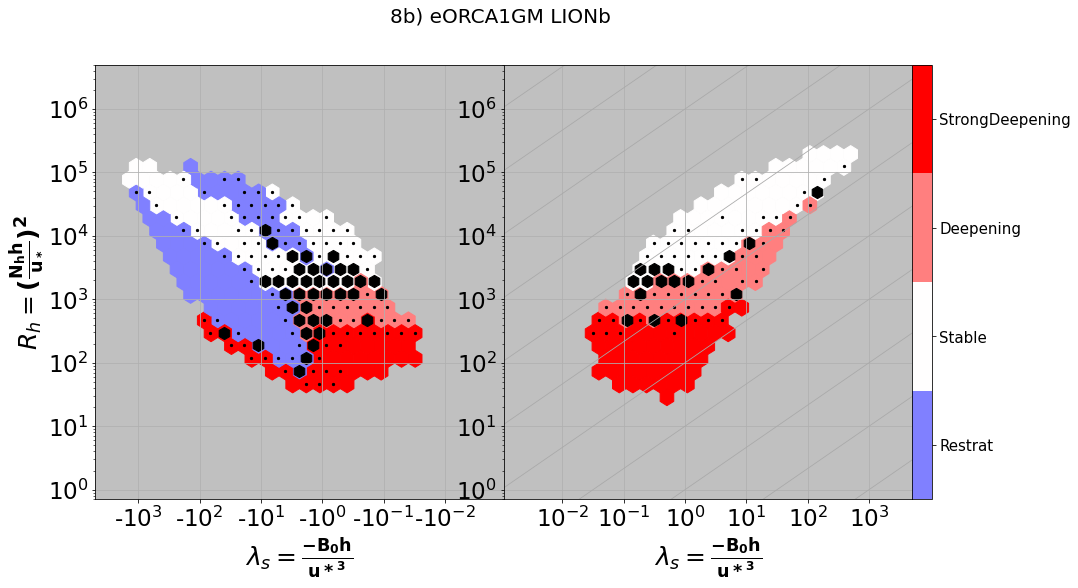

In [36]:
### 8b) eORCA1GM LIONb 

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8b) eORCA1GM LIONb", fontsize = 20)


NotSignif : 15%
Signif : 45%
HighSignif : 40%


Text(0.5, 0.98, '8c) eORCA1GM LIONb restricted to Sh < 0.5m/km')

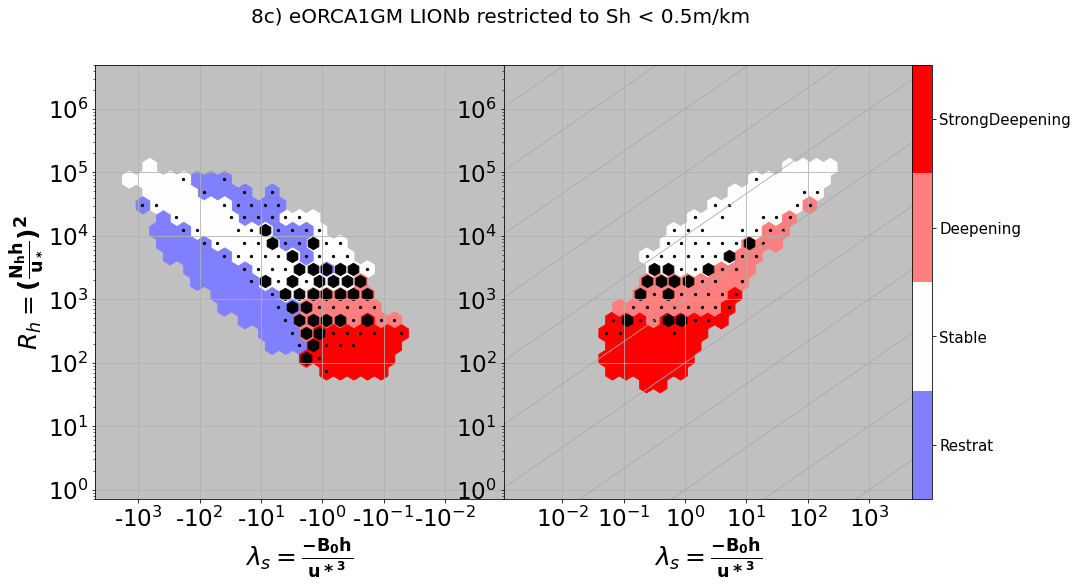

In [37]:
### 8c) eORCA1GM LIONb restricted to Sh < 0.5m/km

#### For loading eORCA1GM LIONb data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
ustar_eORCA1GM_ps   = data['ustar_eORCA1GM_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LIONb proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LIONb_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']

### For restricting to Shmax < 0.5m/km
mask_eORCA1GM_flat   = np.copy(ustar_eORCA1GM_ps > 0)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (proxy_GM_eORCA1GM_b_ps < 0.0005)
lambdas_eORCA1GM       = lambdas_eORCA1GM[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_eORCA1GM[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_ps[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_ps[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]
proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_ps[mask_eORCA1GM_flat]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8c) eORCA1GM LIONb restricted to Sh < 0.5m/km", fontsize = 20)


NotSignif : 12%
Signif : 46%
HighSignif : 42%


Text(0.5, 0.98, '8d) eORCA1 LIONb')

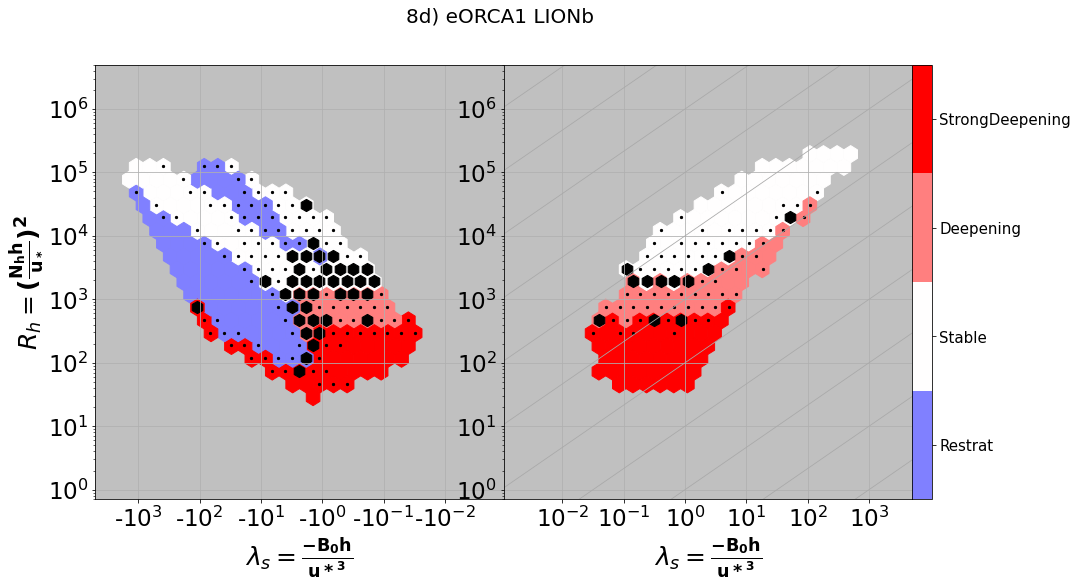

In [38]:
### 8d) eORCA1 LIONb 

#### For loading eORCA1 LIONb data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LIONb_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8d) eORCA1 LIONb", fontsize = 20)


Text(0.5, 0.98, '8e) Index GM LABs (eORCA1GM)')

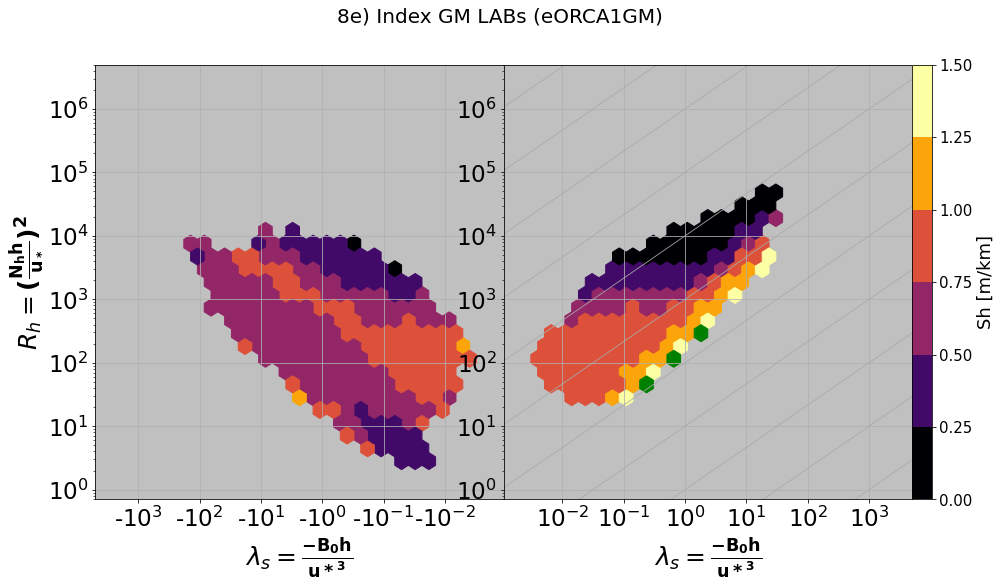

In [39]:
### 8e) eORCA1GM LABs ProxyGM 

#### For loading LABs eORCA1GM data
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LABs proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LABs_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']


#### -------------------------------- ###
####          HEXBIN PLOT             ###
#### -------------------------------- ###


### Variables that can be plotted
### -----------------------------
### dMLDdt_percent (dMLDdt/MLD)    dMLDdt_percent_classes    Shmax

vmin = 0*1000
vmax = 0.0015*1000
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6

my_norm = None
my_var = proxy_GM_eORCA1GM_b_ps*1000
my_clabel = 'Sh [m/km]'
my_cmap = 'inferno'
my_reduce_C_function = np.mean  # Function used to agregate in the bins. Default = mean

### --------------------------------
### Main plot (by personal function)
### --------------------------------

mincnt = 29     # only the hexagons with more than mincrt points are displayed

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(lambdas_eORCA1GM,Rh_eORCA1GM,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=my_norm,vmin=vmin,vmax=vmax,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel=my_clabel,cmap=my_cmap,mincnt=mincnt)
                        
    
### -----------------------------------------------------
### Adding important straight lines and texts on the plot
### -----------------------------------------------------

print('') ; ax0.grid() ; ax1.grid() ;

n_colors = 6
my_cmap = matplotlib.cm.get_cmap(my_cmap)  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n_colors)
my_cmap.set_over('green')
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5],major=True);

additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

plt.suptitle(f"8e) Index GM LABs (eORCA1GM)", fontsize = 20)


NotSignif : 19%
Signif : 34%
HighSignif : 47%


Text(0.5, 0.98, '8f) eORCA1GM LABs')

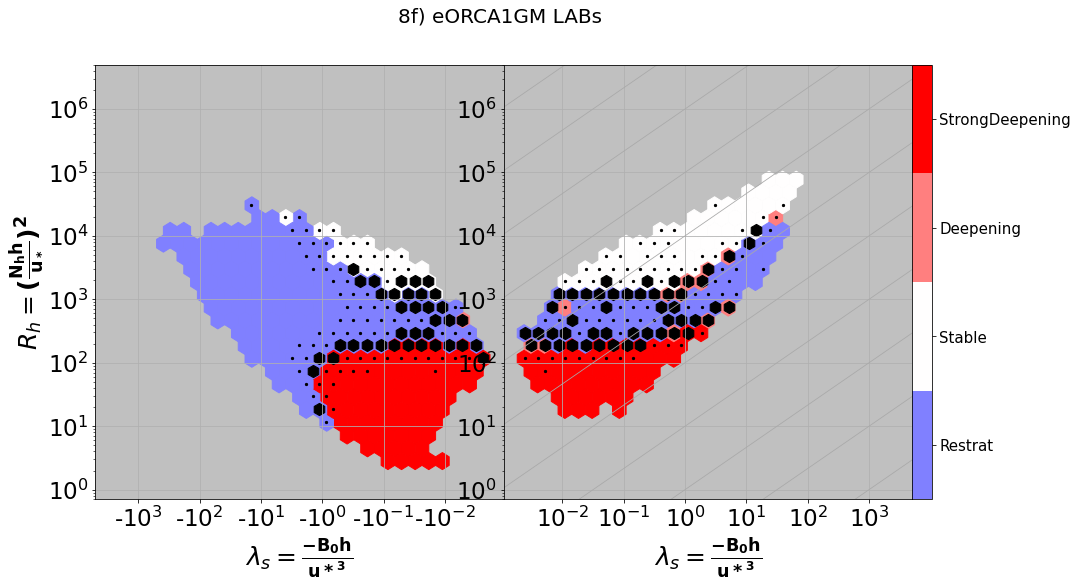

In [40]:
### 8f) eORCA1GM LABs 

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8f) eORCA1GM LABs", fontsize = 20)


NotSignif : 19%
Signif : 35%
HighSignif : 45%


Text(0.5, 0.98, '8g) eORCA1GM LABs restricted to Sh < 0.5m/km')

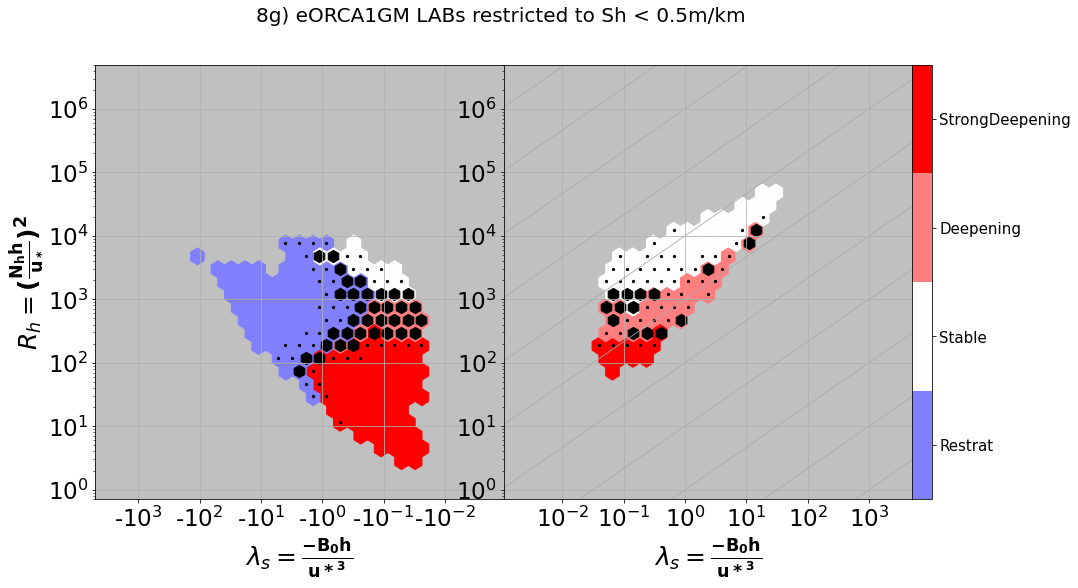

In [41]:
### 8g) eORCA1GM LABs restricted to Sh < 0.5m/km

#### For loading eORCA1GM LABs data 
filename = path_to_npz_archives + 'eORCA1GM_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1GM_ps  = data['dMLDdt_eORCA1GM_ps']
MLD_eORCA1GM_b_ps   = data['MLD_eORCA1GM_b_ps']
ustar_eORCA1GM_ps   = data['ustar_eORCA1GM_ps']
lambdas_eORCA1GM    = data['lambdas_eORCA1GM']
Rh_eORCA1GM         = data['Rh_eORCA1GM']
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]

### For loading LABs proxy_GM
filename = path_to_npz_archives + 'proxy_GM_eORCA1GM_b_LABs_ps.npz'
data = np.load(filename)
proxy_GM_eORCA1GM_b_ps  = data['proxy_GM_eORCA1GM_b_ps']

### For restricting to Shmax < 0.5m/km
mask_eORCA1GM_flat   = np.copy(ustar_eORCA1GM_ps > 0)
mask_eORCA1GM_flat   = mask_eORCA1GM_flat & (proxy_GM_eORCA1GM_b_ps < 0.0005)
lambdas_eORCA1GM       = lambdas_eORCA1GM[mask_eORCA1GM_flat]
Rh_eORCA1GM            = Rh_eORCA1GM[mask_eORCA1GM_flat]
dMLDdt_eORCA1GM_ps     = dMLDdt_eORCA1GM_ps[mask_eORCA1GM_flat]
MLD_eORCA1GM_b_ps      = MLD_eORCA1GM_b_ps[mask_eORCA1GM_flat]
dMLDdt_percent_eORCA1GM_ps = 100*dMLDdt_eORCA1GM_ps/(MLD_eORCA1GM_b_ps)*3600*24   # [%/day]
proxy_GM_eORCA1GM_b_ps = proxy_GM_eORCA1GM_b_ps[mask_eORCA1GM_flat]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1GM
y_array = Rh_eORCA1GM
my_var  = dMLDdt_percent_eORCA1GM_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8g) eORCA1GM LABs restricted to Sh < 0.5m/km", fontsize = 20)


NotSignif : 16%
Signif : 36%
HighSignif : 48%


Text(0.5, 0.98, '8h) eORCA1 LABs')

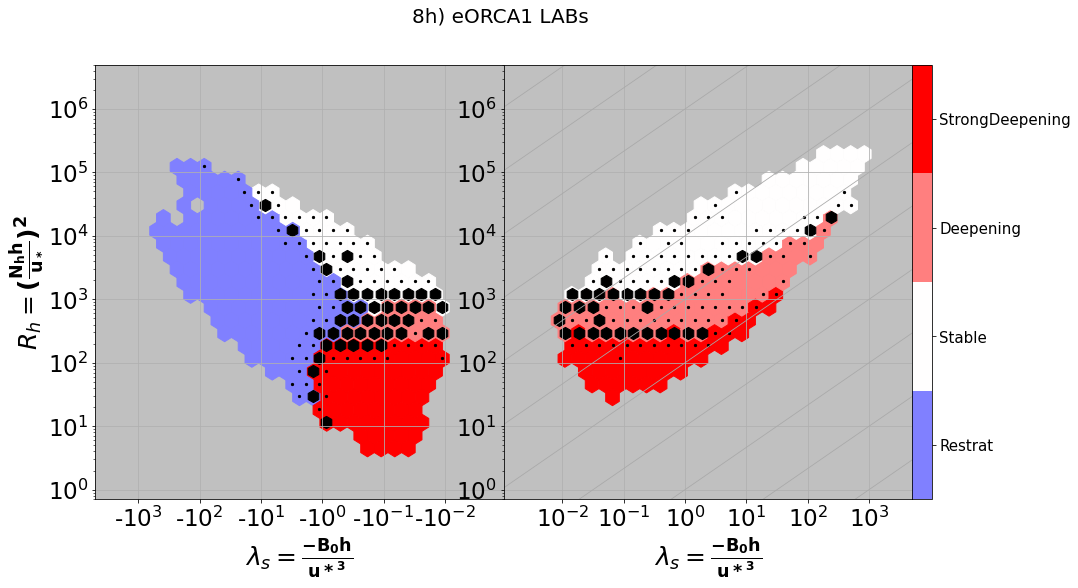

In [42]:
### 8h) eORCA1 LABs 

#### For loading eORCA1 LABs data 
filename = path_to_npz_archives + 'eORCA1_y2000-2019_LABs_ps.npz'
data = np.load(filename)
dMLDdt_eORCA1_ps  = data['dMLDdt_eORCA1_ps']
MLD_eORCA1_b_ps   = data['MLD_eORCA1_b_ps']
lambdas_eORCA1    = data['lambdas_eORCA1']
Rh_eORCA1         = data['Rh_eORCA1']
dMLDdt_percent_eORCA1_ps = 100*dMLDdt_eORCA1_ps/(MLD_eORCA1_b_ps)*3600*24   # [%/day]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA1
y_array = Rh_eORCA1
my_var  = dMLDdt_percent_eORCA1_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^3}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u_*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"8h) eORCA1 LABs", fontsize = 20)


### Figure A1

NotSignif : 3.6%
Signif : 19%
HighSignif : 77%


Text(0.5, 0.98, 'A1a) λs - Rh parameter space; 1D simulations KPP global15deg')

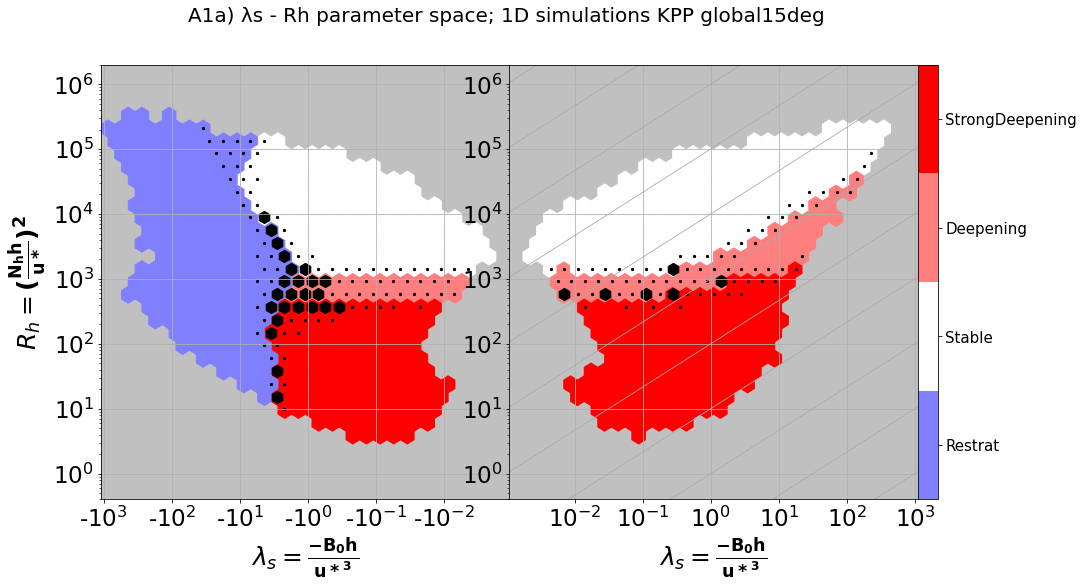

In [62]:
### A1a) λs - Rh parameter space; 1D simulations KPP global15deg 

### For loading 1D simus KPP global15deg data
filename = path_to_npz_archives + '1Dmodels_KPP_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"A1a) λs - Rh parameter space; 1D simulations KPP global15deg", fontsize = 20)


NotSignif : 14%
Signif : 36%
HighSignif : 50%


Text(0.5, 0.98, 'A1b) f/N_h - Rh parameter space; 1D simulations KPP global15deg')

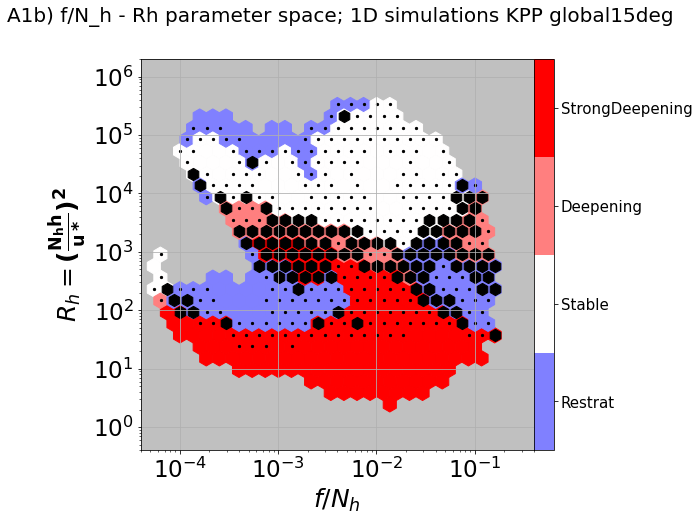

In [63]:
### A1b) f/N_h - Rh parameter space; 1D simulations KPP global15deg 

### For loading 1D simus KPP global15deg data
filename = path_to_npz_archives + '1Dmodels_KPP_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = foverN_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 4e-5; xmax = 4e-1; ymin = 4e-1; ymax = 2e6  # for hexbin_log
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,sc0,cb = hexbin_log(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$f/N_h$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid();  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"A1b) f/N_h - Rh parameter space; 1D simulations KPP global15deg", fontsize = 20)


NotSignif : 23%
Signif : 48%
HighSignif : 29%


Text(0.5, 0.98, 'A1c) λs - f/N_h parameter space; 1D simulations KPP global15deg')

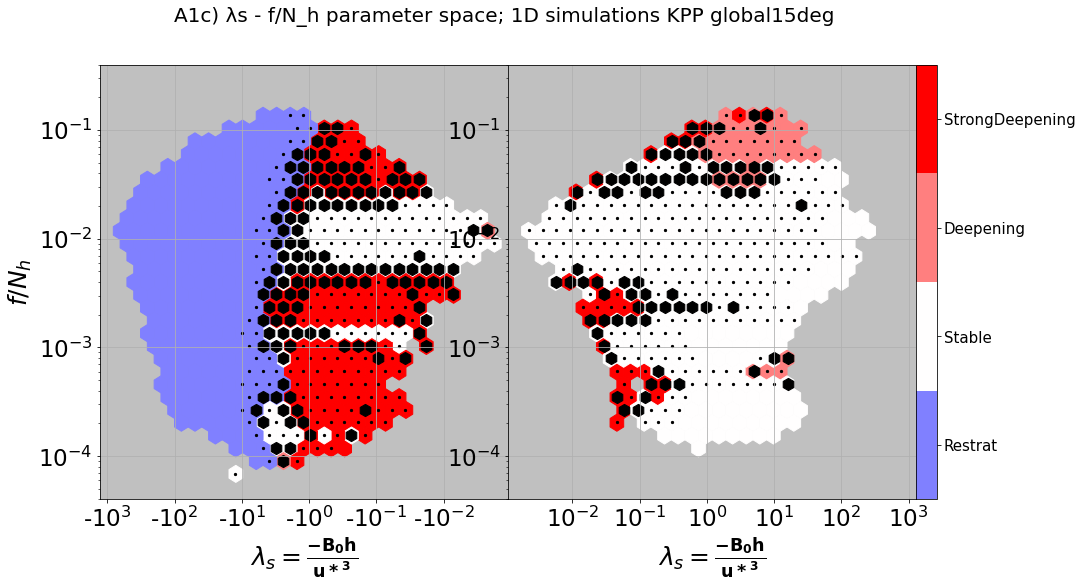

In [64]:
### A1c) λs - f/N_h parameter space; 1D simulations KPP global15deg 

### For loading 1D simus KPP global15deg data
filename = path_to_npz_archives + '1Dmodels_KPP_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = foverN_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.3e3; ymin = 4e-5; ymax = 4e-1
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$f/N_h$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"A1c) λs - f/N_h parameter space; 1D simulations KPP global15deg", fontsize = 20)


### Figure B1

Text(0.5, 0.98, 'B1a) λs - Rh parameter space; Density map 1D simulations global15deg')

<Figure size 1080x576 with 0 Axes>

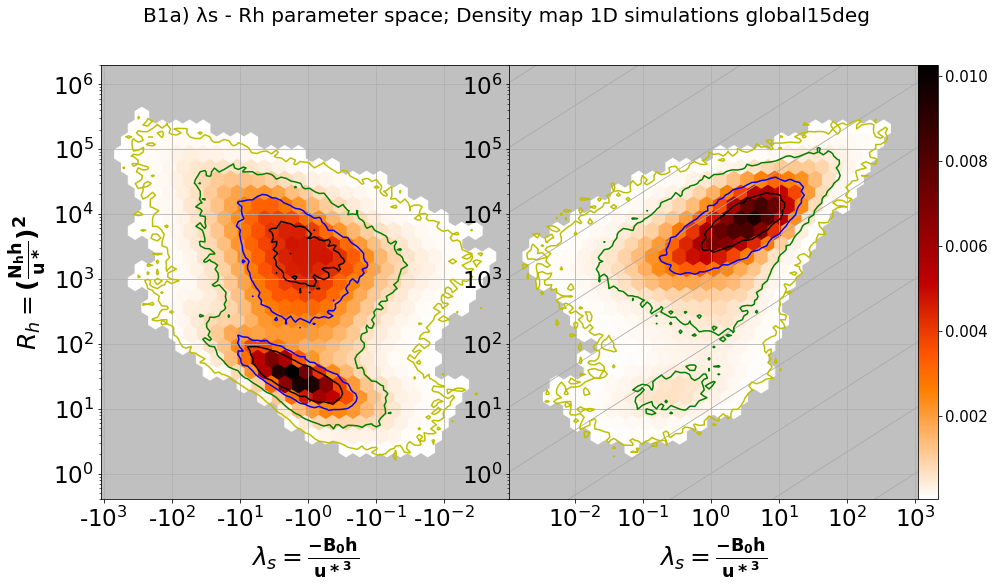

In [65]:
### B1a) λs - Rh parameter space; Density map 1D simulations global15deg

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
total_nb_pts = lambdas_1Dmodels.size     # = Rh_1Dmodels.size = foverN_1Dmodels.size

def relative_frequency(C):
    """ Return the relative frequency"""
    return(np.size(C)/total_nb_pts)

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = relative_frequency  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed

x_left = np.log10(-x_array[x_array<0])
y_left = np.log10(y_array[x_array<0])
hist_left, xi_left, yi_left = loglog_hist2d(x_left, y_left, xpr=[-3, 4], ypr=[0, 6])
x_right = np.log10(x_array[x_array>0])
y_right = np.log10(y_array[x_array>0])
hist_right, xi_right, yi_right = loglog_hist2d(x_right, y_right, xpr=[-3, 4], ypr=[0, 6])


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=None,vmax=None,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap='gist_heat_r',mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 


plot_dist_4p(hist_right, xi_right, yi_right, axis=ax1, colors=('y','g','b','k'), linestyles='-', fcolors = ('r','b','g','k'))
plot_dist_4p(hist_left, xi_left, yi_left, axis=ax0, colors=('y','g','b','k'), linestyles='-')

plt.suptitle(f"B1a) λs - Rh parameter space; Density map 1D simulations global15deg", fontsize = 20)


Text(0.5, 0.98, 'B1b) f/N_h - Rh parameter space; Density map 1D simulations global15deg')

<Figure size 1080x576 with 0 Axes>

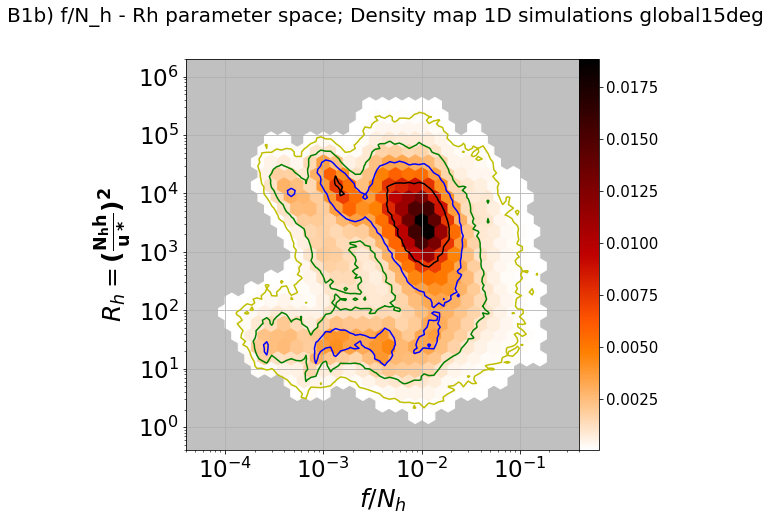

In [66]:
### B1b) f/N_h - Rh parameter space; Density map 1D simulations global15deg

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))
total_nb_pts = lambdas_1Dmodels.size     # = Rh_1Dmodels.size = foverN_1Dmodels.size

def relative_frequency(C):
    """ Return the relative frequency"""
    return(np.size(C)/total_nb_pts)

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = foverN_1Dmodels
y_array = Rh_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 4e-5; xmax = 4e-1; ymin = 4e-1; ymax = 2e6  # for hexbin_log
my_reduce_C_function = relative_frequency  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed

x_right = np.log10(x_array[x_array>0])
y_right = np.log10(y_array[x_array>0])
hist_right, xi_right, yi_right = loglog_hist2d(x_right, y_right, xpr=[-5, 0], ypr=[0, 6])

### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,sc0,cb = hexbin_log(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=None,vmax=None,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$f/N_h$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap='gist_heat_r',mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid();  # Horizontal and vertical grids

plot_dist_4p(hist_right, xi_right, yi_right, axis=ax0, colors=('y','g','b','k'), linestyles='-')


plt.suptitle(f"B1b) f/N_h - Rh parameter space; Density map 1D simulations global15deg", fontsize = 20)


Text(0.5, 0.98, 'B1c) λs - f/N_h parameter space; Density map 1D simulations global15deg')

<Figure size 1080x576 with 0 Axes>

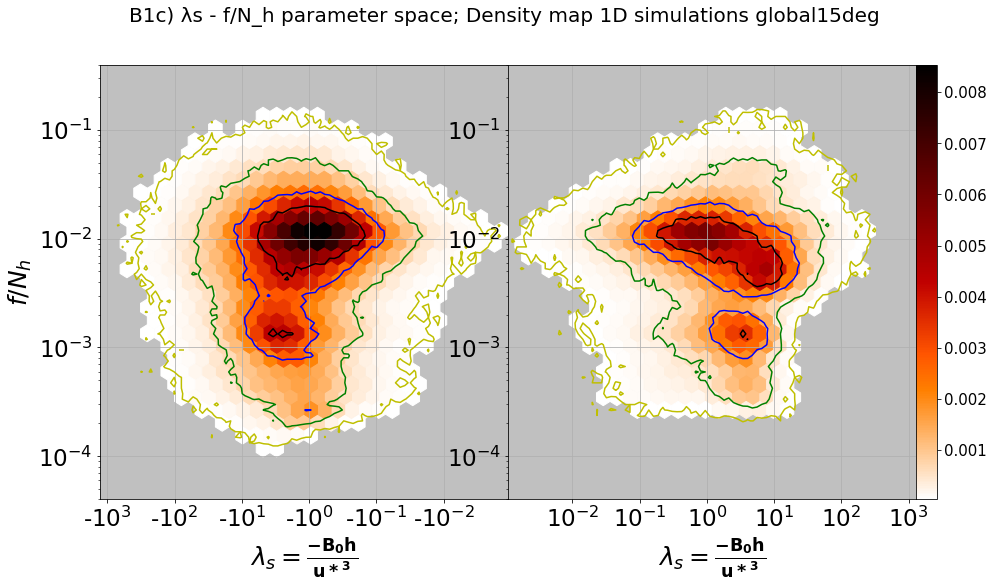

In [67]:
### B1c) λs - f/N_h parameter space; Density map 1D simulations global15deg 

### For loading 1D simus global15deg data
filename = path_to_npz_archives + '1Dmodels_TKEevd_nsamples234_nyears10_eORCA1global15deg_ps.npz'
data = np.load(filename)
dMLDdt_1Dmodels_ps = data['dMLDdt_1Dmodels_ps']
MLD_1Dmodels_b_ps  = data['MLD_1Dmodels_b_ps']
lambdas_1Dmodels   = data['lambdas_1Dmodels']
Rh_1Dmodels        = data['Rh_1Dmodels']
fcor_1Dmodels_ps   = data['fcor_1Dmodels_ps']
N2eq_1Dmodels_b_ps = data['N2eq_1Dmodels_b_ps']
dMLDdt_percent_1Dmodels_ps = 100*dMLDdt_1Dmodels_ps/(MLD_1Dmodels_b_ps)*3600*24   # [%/day]
foverN_1Dmodels = np.abs(fcor_1Dmodels_ps/N2eq_1Dmodels_b_ps**(1/2))
total_nb_pts = lambdas_1Dmodels.size     # = Rh_1Dmodels.size = foverN_1Dmodels.size

def relative_frequency(C):
    """ Return the relative frequency"""
    return(np.size(C)/total_nb_pts)


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_1Dmodels
y_array = foverN_1Dmodels
my_var  = dMLDdt_percent_1Dmodels_ps
xmin = 1.1e-3; xmax = 1.3e3; ymin = 4e-5; ymax = 4e-1
my_reduce_C_function = relative_frequency  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed

x_left = np.log10(-x_array[x_array<0])
y_left = np.log10(y_array[x_array<0])
hist_left, xi_left, yi_left = loglog_hist2d(x_left, y_left, xpr=[-3, 4], ypr=[-5, 0])
x_right = np.log10(x_array[x_array>0])
y_right = np.log10(y_array[x_array>0])
hist_right, xi_right, yi_right = loglog_hist2d(x_right, y_right, xpr=[-3, 4], ypr=[-5, 0])


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=None,vmax=None,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$f/N_h$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap='gist_heat_r',mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids

plot_dist_4p(hist_right, xi_right, yi_right, axis=ax1, colors=('y','g','b','k'), linestyles='-')
plot_dist_4p(hist_left, xi_left, yi_left, axis=ax0, colors=('y','g','b','k'), linestyles='-')

plt.suptitle(f"B1c) λs - f/N_h parameter space; Density map 1D simulations global15deg", fontsize = 20)


### Figure C1

In [68]:
## For loading eORCA12 global15deg data

filename = path_to_npz_archives + 'eORCA12_y2006-2015_global15deg_ps.npz'
data = np.load(filename)
dMLDdt_eORCA12_ps  = data['dMLDdt_eORCA12_ps']
MLD_eORCA12_b_ps   = data['MLD_eORCA12_b_ps']
N2eq_eORCA12_b_ps  = data['N2eq_eORCA12_b_ps']
lambdas_eORCA12    = data['lambdas_eORCA12']
Rh_eORCA12         = data['Rh_eORCA12']
fcor_eORCA12_ps    = data['fcor_eORCA12_ps']
dMLDdt_percent_eORCA12_ps = 100*dMLDdt_eORCA12_ps/(MLD_eORCA12_b_ps)*3600*24   # [%/day]

foverN_eORCA12 = np.abs(fcor_eORCA12_ps/N2eq_eORCA12_b_ps**(1/2))

NotSignif : 17%
Signif : 42%
HighSignif : 41%


Text(0.5, 0.98, 'C1a) λs - Rh parameter space; eORCA12 simulation')

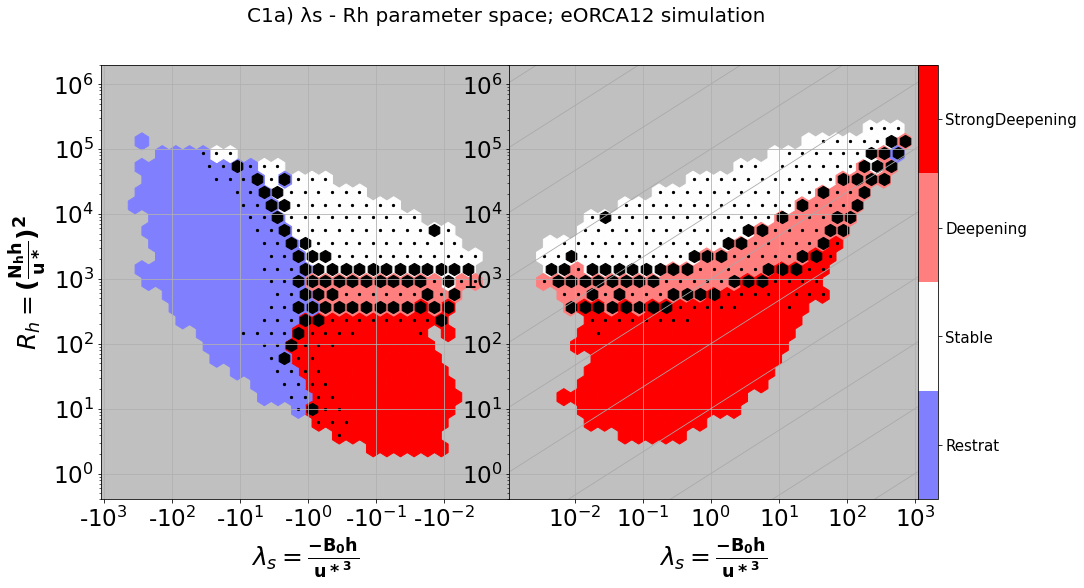

In [69]:
### C1a) λs - Rh parameter space; eORCA12 simulation

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA12
y_array = Rh_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C1a) λs - Rh parameter space; eORCA12 simulation", fontsize = 20)


NotSignif : 47%
Signif : 37%
HighSignif : 16%


Text(0.5, 0.98, 'C1b) f/N_h - Rh parameter space; eORCA12 simulation')

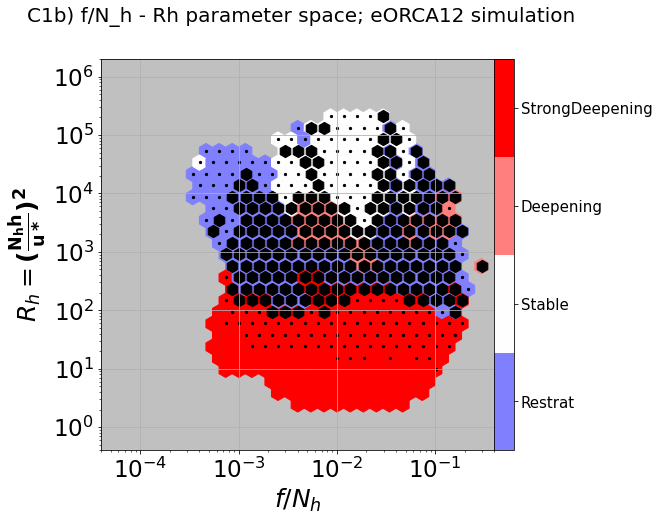

In [70]:
### C1b) f/N_h - Rh parameter space; eORCA12 simulation

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = foverN_eORCA12
y_array = Rh_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 4e-5; xmax = 4e-1; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,sc0,cb = hexbin_log(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$f / N_h$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)


### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 


### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0
Ntot_50 = Nsc0_50
Ntot_75 = Nsc0_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C1b) f/N_h - Rh parameter space; eORCA12 simulation", fontsize = 20)


NotSignif : 53%
Signif : 27%
HighSignif : 20%


Text(0.5, 0.98, 'C1c) λs - f/N_h parameter space; eORCA12 simulation')

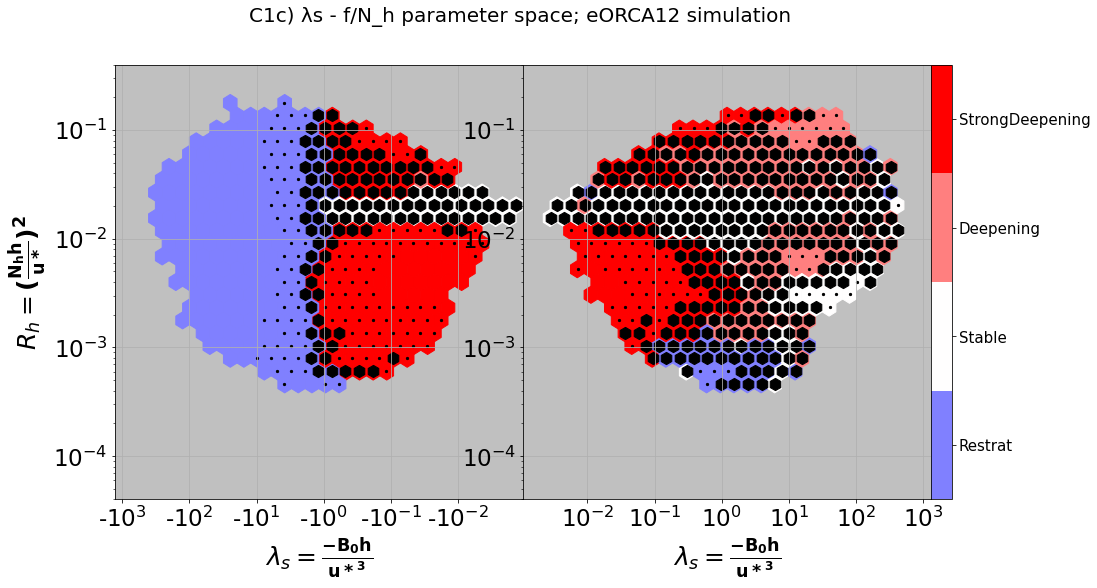

In [71]:
### C1c) λs - f/N_h parameter space; eORCA12 simulation

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA12
y_array = foverN_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 1.1e-3; xmax = 1.3e3; ymin = 4e-5; ymax = 4e-1
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C1c) λs - f/N_h parameter space; eORCA12 simulation", fontsize = 20)


### Figure C2

In [72]:
## For loading eORCA12 global15deg data

filename = path_to_npz_archives + 'eORCA12_y2006-2015_global15deg_ps.npz'
data = np.load(filename)
dMLDdt_eORCA12_ps  = data['dMLDdt_eORCA12_ps']
MLD_eORCA12_b_ps   = data['MLD_eORCA12_b_ps']
N2eq_eORCA12_b_ps  = data['N2eq_eORCA12_b_ps']
lambdas_eORCA12    = data['lambdas_eORCA12']
Rh_eORCA12         = data['Rh_eORCA12']
fcor_eORCA12_ps    = data['fcor_eORCA12_ps']
dMLDdt_percent_eORCA12_ps = 100*dMLDdt_eORCA12_ps/(MLD_eORCA12_b_ps)*3600*24   # [%/day]

foverN_eORCA12 = np.abs(fcor_eORCA12_ps/N2eq_eORCA12_b_ps**(1/2))

NotSignif : 39%
Signif : 36%
HighSignif : 25%


Text(0.5, 0.98, 'C2a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]')

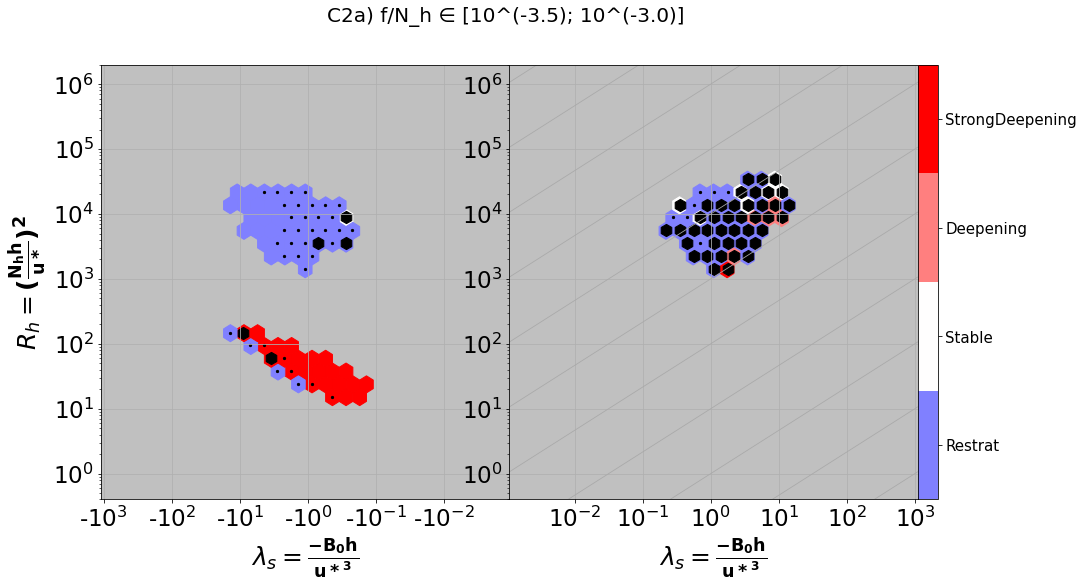

In [73]:
### C2a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]; eORCA12 simulation 

# for sorting taking only for points for which f/N_h ∈ [10^(-3.5); 10^(-3.0)]
mask_reduction = (foverN_eORCA12 > 10**(-3.5)) & (foverN_eORCA12 < 10**(-3.0))
lambda_reduced = lambdas_eORCA12[mask_reduction]
Rh_reduced = Rh_eORCA12[mask_reduction]
dMLDdt_percent_eORCA12_ps_reduced = dMLDdt_percent_eORCA12_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_eORCA12_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C2a) f/N_h ∈ [10^(-3.5); 10^(-3.0)]", fontsize = 20)


NotSignif : 39%
Signif : 26%
HighSignif : 35%


Text(0.5, 0.98, 'C2b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]')

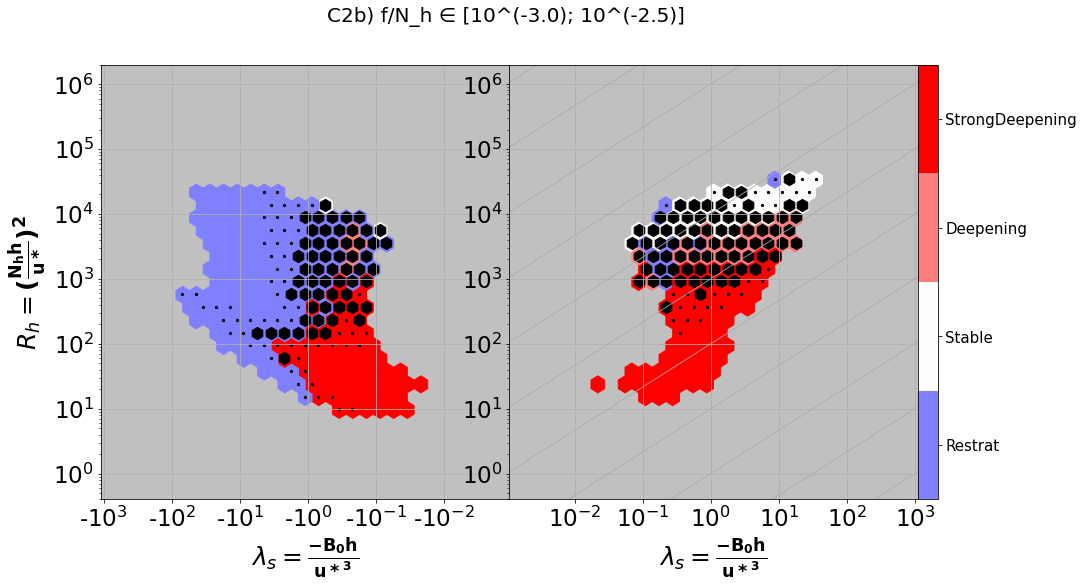

In [74]:
### C2b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]; eORCA12 simulation 

# for sorting taking only for points for which f/N_h ∈ [10^(-3.0); 10^(-2.5)]
mask_reduction = (foverN_eORCA12 > 10**(-3.0)) & (foverN_eORCA12 < 10**(-2.5))
lambda_reduced = lambdas_eORCA12[mask_reduction]
Rh_reduced = Rh_eORCA12[mask_reduction]
dMLDdt_percent_eORCA12_ps_reduced = dMLDdt_percent_eORCA12_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_eORCA12_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C2b) f/N_h ∈ [10^(-3.0); 10^(-2.5)]", fontsize = 20)


NotSignif : 15%
Signif : 38%
HighSignif : 47%


Text(0.5, 0.98, 'C2c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]')

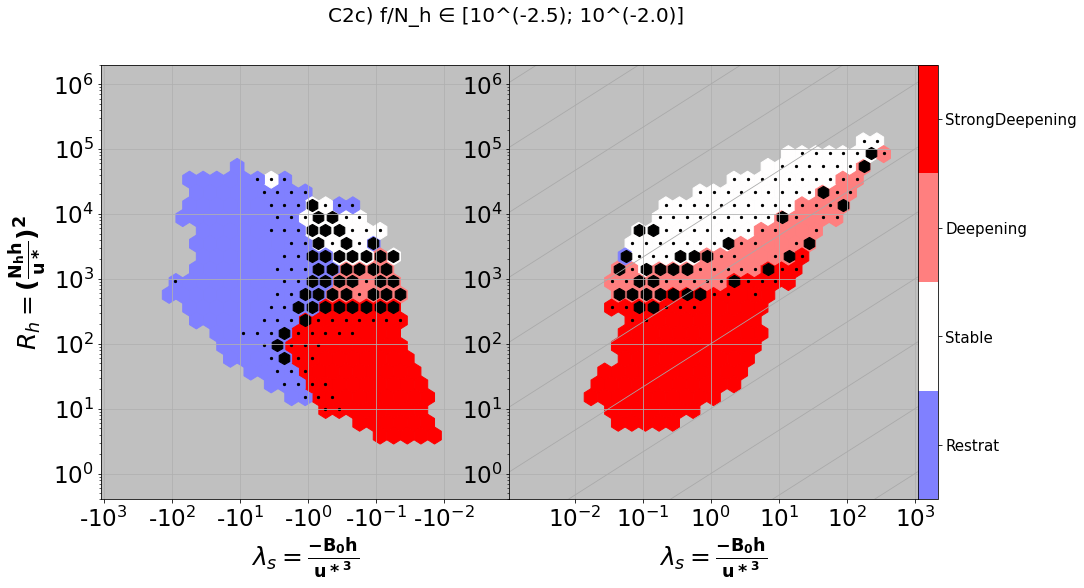

In [75]:
### C2c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]; eORCA12 simulation 

# for sorting taking only for points for which f/N_h ∈ [10^(-2.5); 10^(-2.0)]
mask_reduction = (foverN_eORCA12 > 10**(-2.5)) & (foverN_eORCA12 < 10**(-2.0))
lambda_reduced = lambdas_eORCA12[mask_reduction]
Rh_reduced = Rh_eORCA12[mask_reduction]
dMLDdt_percent_eORCA12_ps_reduced = dMLDdt_percent_eORCA12_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_eORCA12_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C2c) f/N_h ∈ [10^(-2.5); 10^(-2.0)]", fontsize = 20)


NotSignif : 12%
Signif : 47%
HighSignif : 41%


Text(0.5, 0.98, 'C2d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]')

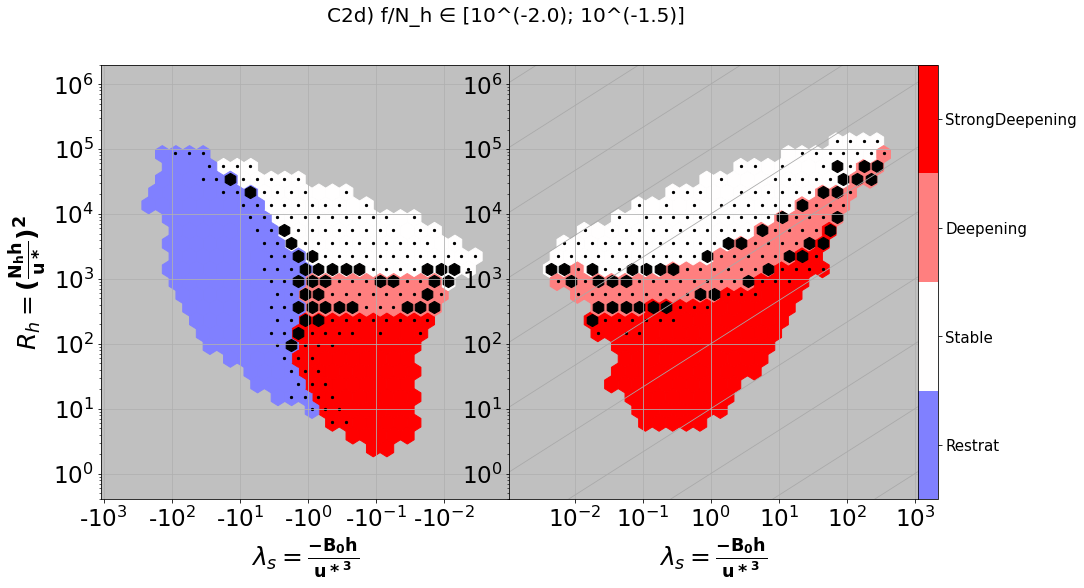

In [76]:
### C2d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]; eORCA12 simulation 

# for sorting taking only for points for which f/N_h ∈ [10^(-2.0); 10^(-1.5)]
mask_reduction = (foverN_eORCA12 > 10**(-2.0)) & (foverN_eORCA12 < 10**(-1.5))
lambda_reduced = lambdas_eORCA12[mask_reduction]
Rh_reduced = Rh_eORCA12[mask_reduction]
dMLDdt_percent_eORCA12_ps_reduced = dMLDdt_percent_eORCA12_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_eORCA12_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C2d) f/N_h ∈ [10^(-2.0); 10^(-1.5)]", fontsize = 20)


NotSignif : 35%
Signif : 34%
HighSignif : 31%


Text(0.5, 0.98, 'C2e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]')

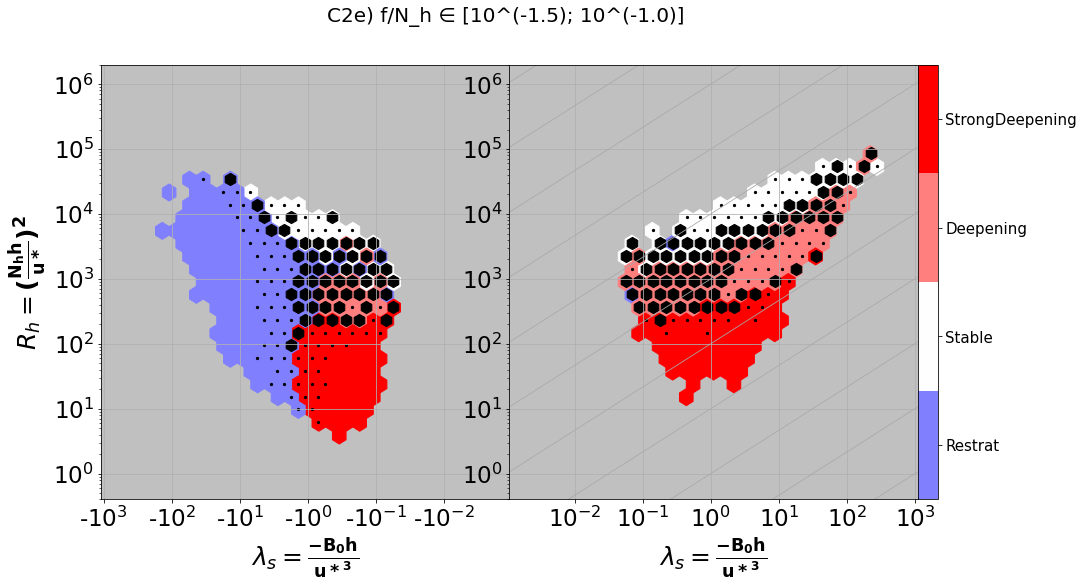

In [77]:
### C2e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]; eORCA12 simulation 

# for sorting taking only for points for which f/N_h ∈ [10^(-1.5); 10^(-1.0)]
mask_reduction = (foverN_eORCA12 > 10**(-1.5)) & (foverN_eORCA12 < 10**(-1.0))
lambda_reduced = lambdas_eORCA12[mask_reduction]
Rh_reduced = Rh_eORCA12[mask_reduction]
dMLDdt_percent_eORCA12_ps_reduced = dMLDdt_percent_eORCA12_ps[mask_reduction]

### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambda_reduced
y_array = Rh_reduced
my_var  = dMLDdt_percent_eORCA12_ps_reduced
xmin = 1.1e-3; xmax = 1.1e3; ymin = 4e-1; ymax = 2e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 29     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
        
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"C2e) f/N_h ∈ [10^(-1.5); 10^(-1.0)]", fontsize = 20)


### Figure D1

In [78]:
### Important remark: The mininum number of points needed to plot a hexagon is here decreased 
### to mincnt = 4 because the absolute sample size is quite small and the threshold mincnt = 29
### was a bit to restrictive

NotSignif : 31%
Signif : 46%
HighSignif : 23%


Text(0.5, 0.98, 'D1a) Observations PAPA')

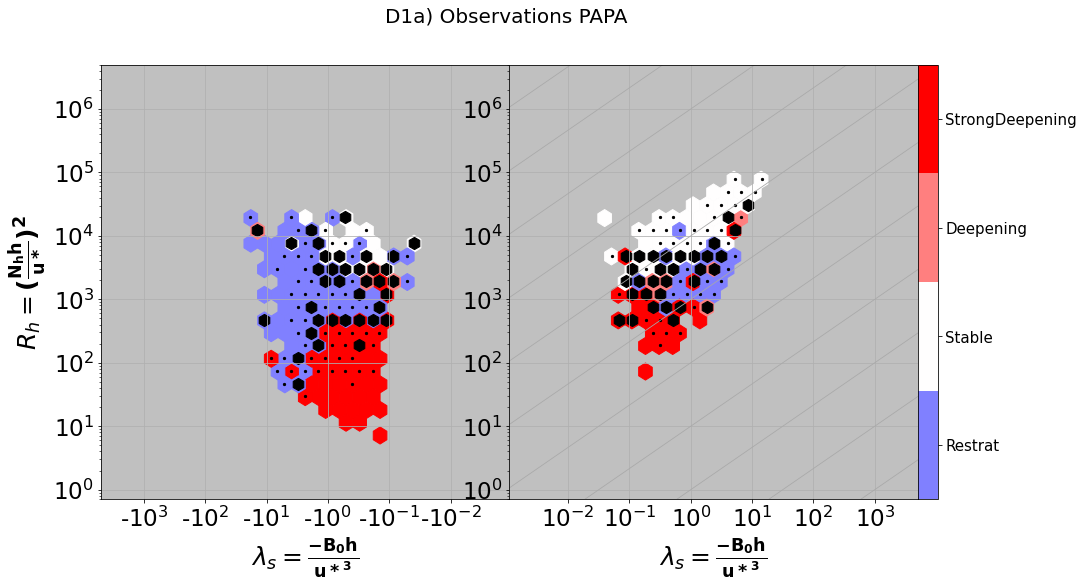

In [79]:
### D1a) Observations PAPA

### For loading obs PAPA
filename = path_to_npz_archives + 'obs_y2010-2020_PAPA_withSalt_ps.npz'
data = np.load(filename)
dMLDdt_PAPA_ps  = data['dMLDdt_PAPA_ps']
MLD_PAPA_b_ps   = data['MLD_PAPA_b_ps']
lambdas_PAPA    = data['lambdas_PAPA']
Rh_PAPA         = data['Rh_PAPA']
dMLDdt_percent_PAPA_ps = 100*dMLDdt_PAPA_ps/(MLD_PAPA_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_PAPA
y_array = Rh_PAPA
my_var  = dMLDdt_percent_PAPA_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 4     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1a) Observations PAPA", fontsize = 20)


NotSignif : 6.4%
Signif : 34%
HighSignif : 59%


Text(0.5, 0.98, 'D1b) eORCA12 PAPA')

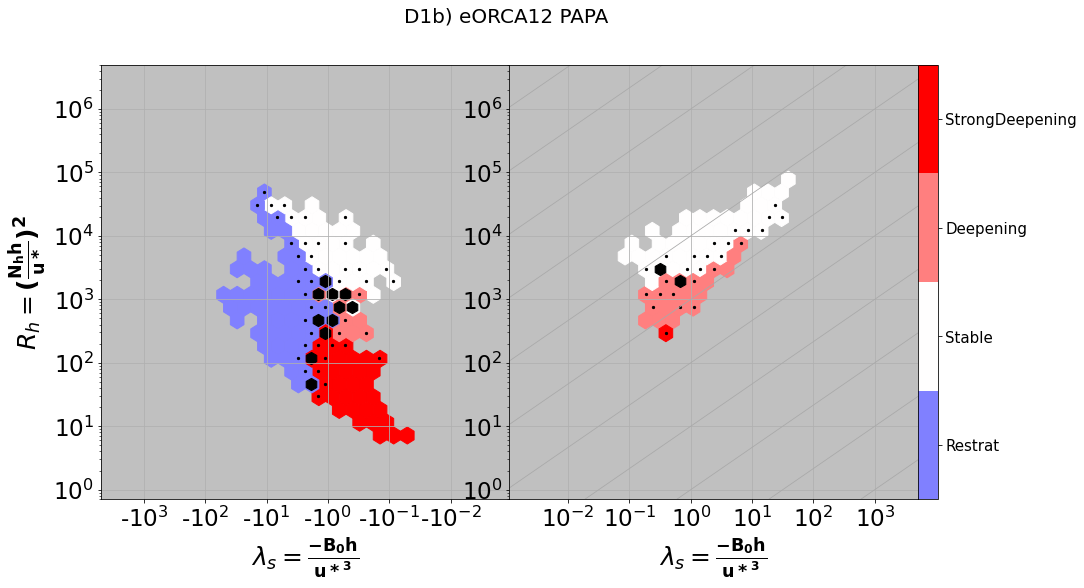

In [80]:
### D1b) eORCA12 PAPA

### For loading eORCA12 PAPA
filename = path_to_npz_archives + 'eORCA12_y2006-2015_PAPA_ps.npz'
data = np.load(filename)
dMLDdt_eORCA12_ps  = data['dMLDdt_eORCA12_ps']
MLD_eORCA12_b_ps   = data['MLD_eORCA12_b_ps']
lambdas_eORCA12    = data['lambdas_eORCA12']
Rh_eORCA12         = data['Rh_eORCA12']
dMLDdt_percent_eORCA12_ps = 100*dMLDdt_eORCA12_ps/(MLD_eORCA12_b_ps)*3600*24   # [%/day]


### -------------------------------- ###
###          HEXBIN PLOT             ###
### -------------------------------- ###

x_array = lambdas_eORCA12
y_array = Rh_eORCA12
my_var  = dMLDdt_percent_eORCA12_ps
xmin = 1.1e-3; xmax = 5e3; ymin = 7e-1; ymax = 5e6
my_reduce_C_function = assign_MLDregime  # Function used to agregate in the bins. Default = mean
mincnt = 4     # only the hexagons with more than mincrt points are displayed


### --------------------------------
### Main plot (by personal function)
### --------------------------------

ax0,ax1,ax2,sc0,sc1,cb = hexbin_symlog(x_array,y_array,my_var,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,gridsize=30,
                        norm=None,vmin=0,vmax=1,reduce_C_function=my_reduce_C_function,
                        xlabel=r'$\lambda_s = \mathbf{\frac{- B_0 h}{u*^{3}}}$',ylabel=r'$R_h = \mathbf{(\frac{N_{h} h}{u*})^2}$',
                        ticksize=23,dynamicalNbTicks=False,clabel='',cmap=None,mincnt=mincnt)

### --------------------------------------
### Adding additional features on the plot
### --------------------------------------

ax0.grid() ; ax1.grid() ;  # Horizontal and vertical grids


### To create the custom colormap associated with the MLD dynamics classes
### ----------------------------------------------------------------------
n_colors = 4
my_cmap = matplotlib.cm.get_cmap('bwr').copy()  # define the colormap
cmaplist = [my_cmap(i) for i in range(my_cmap.N)]
cmaplist = cmaplist[64::]   # for cutting the dark blue and offsetting the colormap
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, n_colors)
sc0.set_cmap(my_cmap)
sc1.set_cmap(my_cmap)
cb.ax.yaxis.set_ticks([0.125, 0.375, 0.625, 0.875],major=True);
cb.ax.set_yticklabels(['Restrat','Stable','Deepening','StrongDeepening']);
cb.ax.minorticks_off()
cb.set_label('')


### To add the black hexagons/dots representing the significativy, non significant hexagons are
### contains in the L75 lists, the significant hexagons in the L50 lists and the highly significant
### are the other ones.
### -----------------------------------------------------------------------------------------------
paths = sc0.get_paths()       # sc0 = left panel
color_map = sc0.get_array()
Lx75 = list(); Ly75 = list() 
Lx50 = list(); Ly50 = list() 
for i in range(len(paths)):  
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax0.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax0.scatter(Lx50,Ly50,color='black', s=150, marker = "h")  # add the black hexagons (non-significant hexagons)
Nsc0 = len(paths); Nsc0_50 = len(Lx50); Nsc0_75 = len(Lx75); 

paths = sc1.get_paths()       # sc1 = right panel
color_map = sc1.get_array()
Lx75 = list(); Ly75 = list()
Lx50 = list(); Ly50 = list()
for i in range(len(paths)):
    color = color_map[i]
    path = paths[i]
    if color in [0.0175,0.3375,0.6675,0.9975]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx75.append(xx); Ly75.append(yy)    # store this information for the later plot
    elif color in [0.0150,0.3350,0.6650,0.9950]:
        xx = np.mean(path.vertices[0:6,0])  # abscissa of the hexagon center
        yy = np.mean(path.vertices[0:6,1])  # ordinate of the hexagon center
        Lx50.append(xx); Ly50.append(yy)    # store this information for the later plot
ax1.scatter(Lx75,Ly75,color='black',s=5)    # add the black dots (significant hexagons)
ax1.scatter(Lx50,Ly50,color='black', s=150, marker = "h")
Nsc1 = len(paths); Nsc1_50 = len(Lx50); Nsc1_75 = len(Lx75); 


### To add the grid of Rh*
### ----------------------
additional_grid = True
if additional_grid == True:

    fitt2 = 10**np.linspace(-4,4,40)
    b_fitt2 = 2/3

    ax1.plot(fitt2, 10**8 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**7 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**6 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**5 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**4 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**0 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-1 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-2 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8)
    ax1.plot(fitt2, 10**-3 * fitt2**b_fitt2, color='darkgray', linestyle='-', linewidth=0.8) 

    
### To calculate the percentages of significant hexagons
### ----------------------------------------------------
Ntot = Nsc0 + Nsc1
Ntot_50 = Nsc0_50 + Nsc1_50
Ntot_75 = Nsc0_75 + Nsc1_75
print(f'NotSignif : {100*Ntot_50/Ntot:.2g}%')
print(f'Signif : {100*Ntot_75/Ntot:.2g}%')
print(f'HighSignif : {100*(1 - Ntot_50/Ntot - Ntot_75/Ntot):.2g}%')


plt.suptitle(f"D1b) eORCA12 PAPA", fontsize = 20)
